In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
!pip install mmcv-full -f https://download.openmmlab.com/mmcv/dist/cu111/torch1.10.0/index.html
!git clone https://github.com/open-mmlab/mmsegmentation.git

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in links: https://download.openmmlab.com/mmcv/dist/cu111/torch1.10.0/index.html
     |████████████████████████████████| 46.4 MB 12.5 MB/s 
     |████████████████████████████████| 190 kB 7.8 MB/s 
Cloning into 'mmsegmentation'...
remote: Enumerating objects: 7196, done.
remote: Counting objects: 100% (201/201), done.
remote: Compressing objects: 100% (159/159), done.
remote: Total 7196 (delta 54), reused 155 (delta 42), pack-reused 6995
Receiving objects: 100% (7196/7196), 13.44 MiB | 33.07 MiB/s, done.
Resolving deltas: 100% (5241/5241), done.


In [3]:
import torch

print(f"Setup complete. Using torch {torch.__version__} ({torch.cuda.get_device_properties(0).name if torch.cuda.is_available() else 'CPU'})")

Setup complete. Using torch 1.11.0+cu113 (Tesla P100-PCIE-16GB)


In [4]:
%cd mmsegmentation

/content/mmsegmentation


In [5]:
from mmseg.apis import inference_segmentor, init_segmentor, show_result_pyplot
import mmcv

In [6]:
import os.path as osp
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt

In [7]:
!mkdir checkpoints
!wget -O //content/mmsegmentation/checkpoints/segformer_mit-b5_8x1_1024x1024_160k_cityscapes_20211206_072934-87a052ec.pth https://download.openmmlab.com/mmsegmentation/v0.5/segformer/segformer_mit-b5_8x1_1024x1024_160k_cityscapes/segformer_mit-b5_8x1_1024x1024_160k_cityscapes_20211206_072934-87a052ec.pth

--2022-06-02 02:21:52--  https://download.openmmlab.com/mmsegmentation/v0.5/segformer/segformer_mit-b5_8x1_1024x1024_160k_cityscapes/segformer_mit-b5_8x1_1024x1024_160k_cityscapes_20211206_072934-87a052ec.pth
Resolving download.openmmlab.com (download.openmmlab.com)... 47.88.36.72
Connecting to download.openmmlab.com (download.openmmlab.com)|47.88.36.72|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 328290585 (313M) [application/octet-stream]
Saving to: ‘//content/mmsegmentation/checkpoints/segformer_mit-b5_8x1_1024x1024_160k_cityscapes_20211206_072934-87a052ec.pth’

//content/mmsegment 100%[===================>] 313.08M  10.2MB/s    in 27s     

2022-06-02 02:22:20 (11.6 MB/s) - ‘//content/mmsegmentation/checkpoints/segformer_mit-b5_8x1_1024x1024_160k_cityscapes_20211206_072934-87a052ec.pth’ saved [328290585/328290585]



In [8]:
from mmseg.datasets.builder import DATASETS
from mmseg.datasets.custom import CustomDataset

classes = ('background', 'road')
palette = [[0, 0, 0], [255, 255, 0]]

@DATASETS.register_module()
class SIADataset(CustomDataset):
  CLASSES = classes
  PALETTE = palette
  def __init__(self, split, **kwargs):
    super().__init__(img_suffix='.png', seg_map_suffix='.png', 
                     split=split, **kwargs)
    assert osp.exists(self.img_dir) and self.split is not None

In [9]:
# config 파일을 설정하고, 다운로드 받은 pretrained 모델을 checkpoint로 설정. 
config_file = '/content/mmsegmentation/configs/segformer/segformer_mit-b5_8x1_1024x1024_160k_cityscapes.py'
checkpoint_file = '/content/mmsegmentation/checkpoints/segformer_mit-b5_8x1_1024x1024_160k_cityscapes_20211206_072934-87a052ec.pth'

from mmcv import Config

cfg = Config.fromfile(config_file)
print(cfg.pretty_text)

norm_cfg = dict(type='SyncBN', requires_grad=True)
model = dict(
    type='EncoderDecoder',
    pretrained=None,
    backbone=dict(
        type='MixVisionTransformer',
        in_channels=3,
        embed_dims=64,
        num_stages=4,
        num_layers=[3, 6, 40, 3],
        num_heads=[1, 2, 5, 8],
        patch_sizes=[7, 3, 3, 3],
        sr_ratios=[8, 4, 2, 1],
        out_indices=(0, 1, 2, 3),
        mlp_ratio=4,
        qkv_bias=True,
        drop_rate=0.0,
        attn_drop_rate=0.0,
        drop_path_rate=0.1,
        init_cfg=dict(type='Pretrained', checkpoint='pretrain/mit_b5.pth')),
    decode_head=dict(
        type='SegformerHead',
        in_channels=[64, 128, 320, 512],
        in_index=[0, 1, 2, 3],
        channels=256,
        dropout_ratio=0.1,
        num_classes=19,
        norm_cfg=dict(type='SyncBN', requires_grad=True),
        align_corners=False,
        loss_decode=dict(
            type='CrossEntropyLoss', use_sigmoid=False, loss_weight=1.0)),
    train_cf

In [10]:
model = dict(
    type='EncoderDecoder',
    pretrained='open-mmlab://resnet101_v1c',
    backbone=dict(
        type='ResNetV1c',
        depth=101,
        num_stages=4,
        out_indices=(0, 1, 2, 3),
        dilations=(1, 1, 1, 1),
        strides=(1, 2, 2, 2),
        norm_cfg=dict(type='BN', requires_grad=True),
        norm_eval=False,
        style='pytorch',
        contract_dilation=True),
    neck=dict(
        type='FPN',
        in_channels=[256, 512, 1024, 2048],
        out_channels=256,
        num_outs=4),
    decode_head=dict(
        type='FPNHead',
        in_channels=[256, 256, 256, 256],
        in_index=[0, 1, 2, 3],
        feature_strides=[4, 8, 16, 32],
        channels=128,
        dropout_ratio=0.1,
        num_classes=19,
        norm_cfg=dict(type='BN', requires_grad=True),
        align_corners=False,
        loss_decode=dict(
            type='CrossEntropyLoss', use_sigmoid=False, loss_weight=1.0)),
    train_cfg=dict(),
    test_cfg=dict(mode='whole'))

In [11]:
img_norm_cfg = dict(
    mean=[123.675, 116.28, 103.53], std=[58.395, 57.12, 57.375], to_rgb=True)
crop_size = (512, 512)
train_pipeline = [
    dict(type='LoadImageFromFile'),
    dict(type='LoadAnnotations'),
    dict(type='Resize', img_scale=(1024, 1024), ratio_range=(0.5, 1.5)),
    dict(type='RandomCrop', crop_size=(512, 512), cat_max_ratio=0.75),
    dict(type='RandomFlip', prob=0.5),
    dict(type='PhotoMetricDistortion'),
    dict(
        type='Normalize',
        mean=[123.675, 116.28, 103.53],
        std=[58.395, 57.12, 57.375],
        to_rgb=True),
    dict(type='Pad', size=(512, 512), pad_val=0, seg_pad_val=255),
    dict(type='DefaultFormatBundle'),
    dict(type='Collect', keys=['img', 'gt_semantic_seg'])
]
test_pipeline = [
    dict(type='LoadImageFromFile'),
    dict(
        type='MultiScaleFlipAug',
        img_scale=(1024, 1024),
        flip=False,
        transforms=[
            dict(type='Resize', keep_ratio=True),
            dict(type='RandomFlip'),
            dict(
                type='Normalize',
                mean=[123.675, 116.28, 103.53],
                std=[58.395, 57.12, 57.375],
                to_rgb=True),
            dict(type='ImageToTensor', keys=['img']),
            dict(type='Collect', keys=['img'])
        ])
]

In [12]:
dataset_type = 'CityscapesDataset'
data_root = 'data/cityscapes/'

data = dict(
    samples_per_gpu=2,  #batch size
    workers_per_gpu=2,  
    train=dict(
        type='CityscapesDataset',
        data_root='data/cityscapes/',
        img_dir='leftImg8bit/train',
        ann_dir='gtFine/train',
        pipeline=[
            dict(type='LoadImageFromFile'),
            dict(type='LoadAnnotations'),
            dict(
                type='Resize', img_scale=(1024, 1024), ratio_range=(0.5, 1.5)),
            dict(type='RandomCrop', crop_size=(512, 512), cat_max_ratio=0.75),
            dict(type='RandomFlip', prob=0.5),
            dict(type='PhotoMetricDistortion'),
            dict(
                type='Normalize',
                mean=[123.675, 116.28, 103.53],
                std=[58.395, 57.12, 57.375],
                to_rgb=True),
            dict(type='Pad', size=(512, 512), pad_val=0, seg_pad_val=255),
            dict(type='DefaultFormatBundle'),
            dict(type='Collect', keys=['img', 'gt_semantic_seg'])
        ]),
    val=dict(
        type='CityscapesDataset',
        data_root='data/cityscapes/',
        img_dir='leftImg8bit/val',
        ann_dir='gtFine/val',
        pipeline=[
            dict(type='LoadImageFromFile'),
            dict(
                type='MultiScaleFlipAug',
                img_scale=(1024, 1024),
                flip=False,
                transforms=[
                    dict(type='Resize', keep_ratio=True),
                    dict(type='RandomFlip'),
                    dict(
                        type='Normalize',
                        mean=[123.675, 116.28, 103.53],
                        std=[58.395, 57.12, 57.375],
                        to_rgb=True),
                    dict(type='ImageToTensor', keys=['img']),
                    dict(type='Collect', keys=['img'])
                ])
        ]),
    test=dict(
        type='CityscapesDataset',
        data_root='data/cityscapes/',
        img_dir='leftImg8bit/val',
        ann_dir='gtFine/val',
        pipeline=[
            dict(type='LoadImageFromFile'),
            dict(
                type='MultiScaleFlipAug',
                img_scale=(1024, 1024),
                flip=False,
                transforms=[
                    dict(type='Resize', keep_ratio=True),
                    dict(type='RandomFlip'),
                    dict(
                        type='Normalize',
                        mean=[123.675, 116.28, 103.53],
                        std=[58.395, 57.12, 57.375],
                        to_rgb=True),
                    dict(type='ImageToTensor', keys=['img']),
                    dict(type='Collect', keys=['img'])
                ])
        ]))

In [13]:
cfg.norm_cfg = dict(type='BN', requires_grad=True)
#cfg.model.backbone.norm_cfg = cfg.norm_cfg
cfg.model.decode_head.norm_cfg = cfg.norm_cfg

cfg.model.decode_head.num_classes = 2

cfg.model.decode_head.sampler=dict(type='OHEMPixelSampler', thresh=0.7, min_kept=100000)

cfg.device='cuda'

cfg.model.decode_head.loss_decode = [dict(type='DiceLoss', loss_weight = 1.0),                                    
                                     dict(type='LovaszLoss', loss_weight = 1.0, reduction='none')]

In [14]:
cfg.img_norm_cfg = dict(
    mean=[123.675, 116.28, 103.53], std=[58.395, 57.12, 57.375], to_rgb=True)
cfg.crop_size = (512, 512)
cfg.train_pipeline = [
    dict(type='LoadImageFromFile'),
    dict(type='LoadAnnotations'),
    dict(type='Resize', img_scale=(1024, 1024), ratio_range=(0.5, 2.0)),
    dict(type='RandomCrop', crop_size=cfg.crop_size, cat_max_ratio=0.75),
    dict(type='RandomFlip', flip_ratio=0.5),
    dict(type='RandomCutOut',prob=0.5,n_holes=(1,10),cutout_ratio=(0.25,0.75)),
    dict(type='PhotoMetricDistortion'),
    dict(type='Normalize', **cfg.img_norm_cfg),
    dict(type='Pad', size=cfg.crop_size, pad_val=0, seg_pad_val=255),
    dict(type='DefaultFormatBundle'),
    dict(type='Collect', keys=['img', 'gt_semantic_seg']),
]

cfg.val_pipeline = [
                    dict(type='LoadImageFromFile'),
                    dict(
                        type='MultiScaleFlipAug',
                        img_scale=(1024, 1024),
                        flip=False,
                        transforms=[
                                    dict(type='Resize', keep_ratio=True),
                                    dict(type='RandomFlip'),
                                    dict(
                                        type='Normalize',
                                        mean=[123.675, 116.28, 103.53],
                                        std=[58.395, 57.12, 57.375],
                                        to_rgb=True),
                                    dict(type='ImageToTensor', keys=['img']),
                                    dict(type='Collect', keys=['img'])
                                    ]),
                    
]

cfg.test_pipeline = [
    dict(type='LoadImageFromFile'),
    dict(
        type='MultiScaleFlipAug',
        img_scale=(1024, 1024),
        img_ratios=[0.5, 0.75, 1.0, 1.25, 1.5, 1.75],
        flip=False,
        transforms=[
            dict(type='Resize', keep_ratio=True),
            #dict(type='ResizeToMultiple', size_divisor=32),
            dict(type='RandomFlip'),
            dict(type='Normalize', **cfg.img_norm_cfg),
            dict(type='ImageToTensor', keys=['img']),
            dict(type='Collect', keys=['img']),
        ])
]

In [15]:
cfg.dataset_type = 'SIADataset'
cfg.data_root = '/content/drive/MyDrive/SIA'

cfg.data.train.type = 'SIADataset'
cfg.data.train.data_root = '/content/drive/MyDrive/SIA'
cfg.data.train.img_dir = 'Data_set/road_dataset/img_dir/train'
cfg.data.train.ann_dir = 'Data_set/road_dataset/ann_01_dir/train'
cfg.data.train.pipeline = cfg.train_pipeline
cfg.data.train.split = '/content/drive/MyDrive/SIA/Data_set/road_dataset/mask_dir/train/up_train_road.txt'

cfg.data.val.type = 'SIADataset'
cfg.data.val.data_root = '/content/drive/MyDrive/SIA'
cfg.data.val.img_dir = 'Data_set/road_dataset/img_dir/train'
cfg.data.val.ann_dir = 'Data_set/road_dataset/ann_01_dir/train'
cfg.data.val.pipeline = cfg.test_pipeline
cfg.data.val.split = '/content/drive/MyDrive/SIA/Data_set/road_dataset/mask_dir/train/up_val_road.txt'

cfg.data.test.type = 'SIADataset'
cfg.data.test.data_root = '/content/drive/MyDrive/SIA'
cfg.data.test.img_dir = 'Data_set/road_dataset/img_dir/val'
cfg.data.test.ann_dir = 'Data_set/road_dataset/ann_01_dir/val'
cfg.data.test.pipeline = cfg.test_pipeline
cfg.data.test.split = '/content/drive/MyDrive/SIA/Data_set/road_dataset/mask_dir/val/up.txt'

In [16]:
'''
cfg.data.train.type = 'SIADataset'
cfg.data.train.data_root = '/content/drive/MyDrive/SIA'
cfg.data.train.img_dir = 'images/up025'
cfg.data.train.ann_dir = 'labels'
cfg.data.train.pipeline = cfg.train_pipeline
cfg.data.train.split = '/content/drive/MyDrive/SIA/splits/road/train_road.txt'
'''

"\ncfg.data.train.type = 'SIADataset'\ncfg.data.train.data_root = '/content/drive/MyDrive/SIA'\ncfg.data.train.img_dir = 'images/up025'\ncfg.data.train.ann_dir = 'labels'\ncfg.data.train.pipeline = cfg.train_pipeline\ncfg.data.train.split = '/content/drive/MyDrive/SIA/splits/road/train_road.txt'\n"

In [17]:
cfg.load_from = '/content/mmsegmentation/checkpoints/segformer_mit-b5_8x1_1024x1024_160k_cityscapes_20211206_072934-87a052ec.pth'

# Set up working dir to save files and logs.
cfg.work_dir = '/content/drive/MyDrive/SIA/semantic_checkpoint/Segformer/road/DL_cutout_sampler'

In [ ]:
cfg.runner.max_iteTrs = 200
cfg.log_config.interval = 100
cfg.evaluation.interval = 1000  # 모델 학습시 평가를 몇 번째 iteration마다 할 것인지 지정
cfg.checkpoint_config.interval = 1000  # 모델 학습시 학습한 모델을 몇 번째 iteration마다 저장할 것인지 지정

cfg.runner = dict(type='IterBasedRunner', max_iters=20000)  # Iteration으로 동작, Epoch로 동작하게 변경할 수도 있음
# cfg.runner = dict(type='EpochBasedRunner', max_epochs=4000)  # Epoch로 변경
cfg.workflow = [('train', 1)]

# Set seed to facitate reproducing the result
cfg.seed = 0
#set_random_seed(0, deterministic=False)
cfg.gpu_ids = range(1)

# Let's have a look at the final config used for training
print(f'Config:\n{cfg.pretty_text}')

Config:
norm_cfg = dict(type='BN', requires_grad=True)
model = dict(
    type='EncoderDecoder',
    pretrained=None,
    backbone=dict(
        type='MixVisionTransformer',
        in_channels=3,
        embed_dims=64,
        num_stages=4,
        num_layers=[3, 6, 40, 3],
        num_heads=[1, 2, 5, 8],
        patch_sizes=[7, 3, 3, 3],
        sr_ratios=[8, 4, 2, 1],
        out_indices=(0, 1, 2, 3),
        mlp_ratio=4,
        qkv_bias=True,
        drop_rate=0.0,
        attn_drop_rate=0.0,
        drop_path_rate=0.1,
        init_cfg=dict(type='Pretrained', checkpoint='pretrain/mit_b5.pth')),
    decode_head=dict(
        type='SegformerHead',
        in_channels=[64, 128, 320, 512],
        in_index=[0, 1, 2, 3],
        channels=256,
        dropout_ratio=0.1,
        num_classes=2,
        norm_cfg=dict(type='BN', requires_grad=True),
        align_corners=False,
        loss_decode=[
            dict(type='DiceLoss', loss_weight=1.0),
            dict(type='LovaszLoss', loss

### 모델 학습

In [ ]:
from mmseg.datasets import build_dataset
from mmseg.models import build_segmentor
from mmseg.apis import train_segmentor

# Build the dataset
datasets = [build_dataset(cfg.data.train)]

# Build the detector
model = build_segmentor(
    cfg.model, train_cfg=cfg.get('train_cfg'), test_cfg=cfg.get('test_cfg'))

# Add an attribute for visualization convenience
model.CLASSES = datasets[0].CLASSES

# Create work_dir
mmcv.mkdir_or_exist(osp.abspath(cfg.work_dir))
train_segmentor(model, datasets, cfg, distributed=False, validate=True,
                meta=dict(CLASSES=classes, PALETTE=palette))

2022-05-27 06:52:06,301 - mmseg - INFO - Loaded 542 images
2022-05-27 06:52:20,160 - mmseg - INFO - Loaded 66 images
2022-05-27 06:52:20,166 - mmseg - INFO - load checkpoint from local path: /content/mmsegmentation/checkpoints/segformer_mit-b5_8x1_1024x1024_160k_cityscapes_20211206_072934-87a052ec.pth
2022-05-27 06:52:20,701 - mmseg - WARNING - The model and loaded state dict do not match exactly

size mismatch for decode_head.conv_seg.weight: copying a param with shape torch.Size([19, 256, 1, 1]) from checkpoint, the shape in current model is torch.Size([2, 256, 1, 1]).
size mismatch for decode_head.conv_seg.bias: copying a param with shape torch.Size([19]) from checkpoint, the shape in current model is torch.Size([2]).
2022-05-27 06:52:20,710 - mmseg - INFO - Start running, host: root@b1637296fc78, work_dir: /content/drive/MyDrive/SIA/semantic_checkpoint/Segformer/road/DL_cutout_sampler
2022-05-27 06:52:20,712 - mmseg - INFO - Hooks will be executed in the following order:
before_run

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 66/66, 0.2 task/s, elapsed: 275s, ETA:     0s

2022-05-27 07:07:11,923 - mmseg - INFO - per class results:
2022-05-27 07:07:11,926 - mmseg - INFO - 
+------------+-------+-------+
|   Class    |  IoU  |  Acc  |
+------------+-------+-------+
| background | 89.56 | 94.41 |
|    road    | 57.94 | 73.67 |
+------------+-------+-------+
2022-05-27 07:07:11,928 - mmseg - INFO - Summary:
2022-05-27 07:07:11,929 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc |  mIoU |  mAcc |
+-------+-------+-------+
| 90.87 | 73.75 | 84.04 |
+-------+-------+-------+
2022-05-27 07:07:11,932 - mmseg - INFO - Iter(val) [66]	aAcc: 0.9087, mIoU: 0.7375, mAcc: 0.8404, IoU.background: 0.8956, IoU.road: 0.5794, Acc.background: 0.9441, Acc.road: 0.7367
2022-05-27 07:07:54,422 - mmseg - INFO - Iter [1100/20000]	lr: 4.154e-05, eta: 4:27:21, time: 3.170, data_time: 2.774, memory: 3323, decode.loss_dice: 0.1979, decode.loss_lovasz: 0.3486, decode.acc_seg: 86.4278, loss: 0.5465
2022-05-27 07:08:34,764 - mmseg - INFO - Iter [1200/20000]	lr: 4.508e-05, eta: 4:14:

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 66/66, 0.3 task/s, elapsed: 253s, ETA:     0s

2022-05-27 07:18:19,232 - mmseg - INFO - per class results:
2022-05-27 07:18:19,234 - mmseg - INFO - 
+------------+-------+-------+
|   Class    |  IoU  |  Acc  |
+------------+-------+-------+
| background | 90.73 | 96.11 |
|    road    | 59.89 | 71.22 |
+------------+-------+-------+
2022-05-27 07:18:19,235 - mmseg - INFO - Summary:
2022-05-27 07:18:19,237 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc |  mIoU |  mAcc |
+-------+-------+-------+
| 91.86 | 75.31 | 83.66 |
+-------+-------+-------+
2022-05-27 07:18:19,240 - mmseg - INFO - Iter(val) [66]	aAcc: 0.9186, mIoU: 0.7531, mAcc: 0.8366, IoU.background: 0.9073, IoU.road: 0.5989, Acc.background: 0.9611, Acc.road: 0.7122
2022-05-27 07:18:59,579 - mmseg - INFO - Iter [2100/20000]	lr: 5.370e-05, eta: 3:47:07, time: 2.935, data_time: 2.538, memory: 3323, decode.loss_dice: 0.1623, decode.loss_lovasz: 0.2991, decode.acc_seg: 88.4451, loss: 0.4613
2022-05-27 07:19:41,955 - mmseg - INFO - Iter [2200/20000]	lr: 5.340e-05, eta: 3:41:

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 66/66, 0.3 task/s, elapsed: 253s, ETA:     0s

2022-05-27 07:29:24,967 - mmseg - INFO - per class results:
2022-05-27 07:29:24,969 - mmseg - INFO - 
+------------+------+-------+
|   Class    | IoU  |  Acc  |
+------------+------+-------+
| background | 90.6 | 94.99 |
|    road    | 61.5 | 76.46 |
+------------+------+-------+
2022-05-27 07:29:24,971 - mmseg - INFO - Summary:
2022-05-27 07:29:24,973 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc |  mIoU |  mAcc |
+-------+-------+-------+
| 91.83 | 76.05 | 85.73 |
+-------+-------+-------+
2022-05-27 07:29:24,976 - mmseg - INFO - Iter(val) [66]	aAcc: 0.9183, mIoU: 0.7605, mAcc: 0.8573, IoU.background: 0.9060, IoU.road: 0.6150, Acc.background: 0.9499, Acc.road: 0.7646
2022-05-27 07:30:05,022 - mmseg - INFO - Iter [3100/20000]	lr: 5.070e-05, eta: 3:25:43, time: 2.932, data_time: 2.538, memory: 3323, decode.loss_dice: 0.1665, decode.loss_lovasz: 0.2966, decode.acc_seg: 88.1366, loss: 0.4632
2022-05-27 07:30:45,216 - mmseg - INFO - Iter [3200/20000]	lr: 5.040e-05, eta: 3:21:38, ti

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 66/66, 0.3 task/s, elapsed: 253s, ETA:     0s

2022-05-27 07:40:28,777 - mmseg - INFO - per class results:
2022-05-27 07:40:28,779 - mmseg - INFO - 
+------------+-------+-------+
|   Class    |  IoU  |  Acc  |
+------------+-------+-------+
| background | 90.98 | 95.88 |
|    road    | 61.53 | 73.84 |
+------------+-------+-------+
2022-05-27 07:40:28,780 - mmseg - INFO - Summary:
2022-05-27 07:40:28,782 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc |  mIoU |  mAcc |
+-------+-------+-------+
| 92.12 | 76.26 | 84.86 |
+-------+-------+-------+
2022-05-27 07:40:28,786 - mmseg - INFO - Iter(val) [66]	aAcc: 0.9212, mIoU: 0.7626, mAcc: 0.8486, IoU.background: 0.9098, IoU.road: 0.6153, Acc.background: 0.9588, Acc.road: 0.7384
2022-05-27 07:41:08,911 - mmseg - INFO - Iter [4100/20000]	lr: 4.770e-05, eta: 3:09:15, time: 2.932, data_time: 2.538, memory: 3323, decode.loss_dice: 0.1640, decode.loss_lovasz: 0.2914, decode.acc_seg: 88.7432, loss: 0.4554
2022-05-27 07:41:48,800 - mmseg - INFO - Iter [4200/20000]	lr: 4.740e-05, eta: 3:06:

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 66/66, 0.3 task/s, elapsed: 253s, ETA:     0s

2022-05-27 07:51:31,425 - mmseg - INFO - per class results:
2022-05-27 07:51:31,427 - mmseg - INFO - 
+------------+-------+-------+
|   Class    |  IoU  |  Acc  |
+------------+-------+-------+
| background | 91.34 | 96.27 |
|    road    | 62.46 | 73.78 |
+------------+-------+-------+
2022-05-27 07:51:31,430 - mmseg - INFO - Summary:
2022-05-27 07:51:31,433 - mmseg - INFO - 
+-------+------+-------+
|  aAcc | mIoU |  mAcc |
+-------+------+-------+
| 92.43 | 76.9 | 85.03 |
+-------+------+-------+
2022-05-27 07:51:31,436 - mmseg - INFO - Iter(val) [66]	aAcc: 0.9243, mIoU: 0.7690, mAcc: 0.8503, IoU.background: 0.9134, IoU.road: 0.6246, Acc.background: 0.9627, Acc.road: 0.7378
2022-05-27 07:52:11,612 - mmseg - INFO - Iter [5100/20000]	lr: 4.470e-05, eta: 2:54:50, time: 2.934, data_time: 2.539, memory: 3323, decode.loss_dice: 0.1585, decode.loss_lovasz: 0.2804, decode.acc_seg: 89.1667, loss: 0.4389
2022-05-27 07:52:51,769 - mmseg - INFO - Iter [5200/20000]	lr: 4.440e-05, eta: 2:52:14, t

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 66/66, 0.3 task/s, elapsed: 253s, ETA:     0s

2022-05-27 08:02:37,131 - mmseg - INFO - per class results:
2022-05-27 08:02:37,134 - mmseg - INFO - 
+------------+-------+-------+
|   Class    |  IoU  |  Acc  |
+------------+-------+-------+
| background | 91.24 | 95.42 |
|    road    | 63.57 | 77.72 |
+------------+-------+-------+
2022-05-27 08:02:37,135 - mmseg - INFO - Summary:
2022-05-27 08:02:37,138 - mmseg - INFO - 
+------+------+-------+
| aAcc | mIoU |  mAcc |
+------+------+-------+
| 92.4 | 77.4 | 86.57 |
+------+------+-------+
2022-05-27 08:02:37,142 - mmseg - INFO - Iter(val) [66]	aAcc: 0.9240, mIoU: 0.7740, mAcc: 0.8657, IoU.background: 0.9124, IoU.road: 0.6357, Acc.background: 0.9542, Acc.road: 0.7772
2022-05-27 08:03:17,363 - mmseg - INFO - Iter [6100/20000]	lr: 4.170e-05, eta: 2:41:39, time: 2.933, data_time: 2.538, memory: 3323, decode.loss_dice: 0.1550, decode.loss_lovasz: 0.2892, decode.acc_seg: 88.9065, loss: 0.4442
2022-05-27 08:03:57,455 - mmseg - INFO - Iter [6200/20000]	lr: 4.140e-05, eta: 2:39:23, time: 

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 66/66, 0.3 task/s, elapsed: 253s, ETA:     0s

2022-05-27 08:13:39,841 - mmseg - INFO - per class results:
2022-05-27 08:13:39,843 - mmseg - INFO - 
+------------+-------+-------+
|   Class    |  IoU  |  Acc  |
+------------+-------+-------+
| background | 91.27 | 95.49 |
|    road    |  63.6 | 77.53 |
+------------+-------+-------+
2022-05-27 08:13:39,845 - mmseg - INFO - Summary:
2022-05-27 08:13:39,847 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc |  mIoU |  mAcc |
+-------+-------+-------+
| 92.43 | 77.44 | 86.51 |
+-------+-------+-------+
2022-05-27 08:13:39,850 - mmseg - INFO - Iter(val) [66]	aAcc: 0.9243, mIoU: 0.7744, mAcc: 0.8651, IoU.background: 0.9127, IoU.road: 0.6360, Acc.background: 0.9549, Acc.road: 0.7753
2022-05-27 08:14:21,823 - mmseg - INFO - Iter [7100/20000]	lr: 3.870e-05, eta: 2:29:00, time: 2.951, data_time: 2.559, memory: 3323, decode.loss_dice: 0.1510, decode.loss_lovasz: 0.2805, decode.acc_seg: 89.4675, loss: 0.4315
2022-05-27 08:15:01,552 - mmseg - INFO - Iter [7200/20000]	lr: 3.840e-05, eta: 2:26:

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 66/66, 0.3 task/s, elapsed: 253s, ETA:     0s

2022-05-27 08:24:44,585 - mmseg - INFO - per class results:
2022-05-27 08:24:44,588 - mmseg - INFO - 
+------------+-------+-------+
|   Class    |  IoU  |  Acc  |
+------------+-------+-------+
| background | 91.33 | 95.06 |
|    road    | 64.63 | 80.16 |
+------------+-------+-------+
2022-05-27 08:24:44,590 - mmseg - INFO - Summary:
2022-05-27 08:24:44,592 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc |  mIoU |  mAcc |
+-------+-------+-------+
| 92.51 | 77.98 | 87.61 |
+-------+-------+-------+
2022-05-27 08:24:44,595 - mmseg - INFO - Iter(val) [66]	aAcc: 0.9251, mIoU: 0.7798, mAcc: 0.8761, IoU.background: 0.9133, IoU.road: 0.6463, Acc.background: 0.9506, Acc.road: 0.8016
2022-05-27 08:25:25,004 - mmseg - INFO - Iter [8100/20000]	lr: 3.570e-05, eta: 2:16:43, time: 2.934, data_time: 2.537, memory: 3323, decode.loss_dice: 0.1357, decode.loss_lovasz: 0.2576, decode.acc_seg: 90.2495, loss: 0.3933
2022-05-27 08:26:07,306 - mmseg - INFO - Iter [8200/20000]	lr: 3.540e-05, eta: 2:14:

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 66/66, 0.3 task/s, elapsed: 253s, ETA:     0s

2022-05-27 08:35:46,831 - mmseg - INFO - per class results:
2022-05-27 08:35:46,833 - mmseg - INFO - 
+------------+-------+-------+
|   Class    |  IoU  |  Acc  |
+------------+-------+-------+
| background | 91.75 | 96.13 |
|    road    | 64.65 | 76.82 |
+------------+-------+-------+
2022-05-27 08:35:46,835 - mmseg - INFO - Summary:
2022-05-27 08:35:46,839 - mmseg - INFO - 
+-------+------+-------+
|  aAcc | mIoU |  mAcc |
+-------+------+-------+
| 92.83 | 78.2 | 86.47 |
+-------+------+-------+
2022-05-27 08:35:46,842 - mmseg - INFO - Iter(val) [66]	aAcc: 0.9283, mIoU: 0.7820, mAcc: 0.8647, IoU.background: 0.9175, IoU.road: 0.6465, Acc.background: 0.9613, Acc.road: 0.7682
2022-05-27 08:36:26,736 - mmseg - INFO - Iter [9100/20000]	lr: 3.270e-05, eta: 2:04:41, time: 2.929, data_time: 2.537, memory: 3323, decode.loss_dice: 0.1441, decode.loss_lovasz: 0.2605, decode.acc_seg: 90.9661, loss: 0.4046
2022-05-27 08:37:08,664 - mmseg - INFO - Iter [9200/20000]	lr: 3.240e-05, eta: 2:03:01, t

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 66/66, 0.3 task/s, elapsed: 253s, ETA:     0s

2022-05-27 08:46:56,618 - mmseg - INFO - per class results:
2022-05-27 08:46:56,620 - mmseg - INFO - 
+------------+-------+-------+
|   Class    |  IoU  |  Acc  |
+------------+-------+-------+
| background | 91.33 | 95.26 |
|    road    | 64.29 |  79.1 |
+------------+-------+-------+
2022-05-27 08:46:56,622 - mmseg - INFO - Summary:
2022-05-27 08:46:56,626 - mmseg - INFO - 
+------+-------+-------+
| aAcc |  mIoU |  mAcc |
+------+-------+-------+
| 92.5 | 77.81 | 87.18 |
+------+-------+-------+
2022-05-27 08:46:56,628 - mmseg - INFO - Iter(val) [66]	aAcc: 0.9250, mIoU: 0.7781, mAcc: 0.8718, IoU.background: 0.9133, IoU.road: 0.6429, Acc.background: 0.9526, Acc.road: 0.7910
2022-05-27 08:47:36,781 - mmseg - INFO - Iter [10100/20000]	lr: 2.970e-05, eta: 1:52:58, time: 2.933, data_time: 2.538, memory: 3323, decode.loss_dice: 0.1449, decode.loss_lovasz: 0.2713, decode.acc_seg: 89.8746, loss: 0.4162
2022-05-27 08:48:18,117 - mmseg - INFO - Iter [10200/20000]	lr: 2.940e-05, eta: 1:51:24,

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 66/66, 0.3 task/s, elapsed: 253s, ETA:     0s

2022-05-27 08:58:06,725 - mmseg - INFO - per class results:
2022-05-27 08:58:06,727 - mmseg - INFO - 
+------------+-------+-------+
|   Class    |  IoU  |  Acc  |
+------------+-------+-------+
| background | 91.83 | 96.61 |
|    road    | 64.16 | 74.74 |
+------------+-------+-------+
2022-05-27 08:58:06,729 - mmseg - INFO - Summary:
2022-05-27 08:58:06,732 - mmseg - INFO - 
+-------+------+-------+
|  aAcc | mIoU |  mAcc |
+-------+------+-------+
| 92.87 | 78.0 | 85.67 |
+-------+------+-------+
2022-05-27 08:58:06,735 - mmseg - INFO - Iter(val) [66]	aAcc: 0.9287, mIoU: 0.7800, mAcc: 0.8567, IoU.background: 0.9183, IoU.road: 0.6416, Acc.background: 0.9661, Acc.road: 0.7474
2022-05-27 08:58:46,696 - mmseg - INFO - Iter [11100/20000]	lr: 2.670e-05, eta: 1:41:22, time: 2.931, data_time: 2.539, memory: 3323, decode.loss_dice: 0.1316, decode.loss_lovasz: 0.2531, decode.acc_seg: 90.3005, loss: 0.3847
2022-05-27 08:59:26,600 - mmseg - INFO - Iter [11200/20000]	lr: 2.640e-05, eta: 1:39:51,

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 66/66, 0.3 task/s, elapsed: 253s, ETA:     0s

2022-05-27 09:09:17,565 - mmseg - INFO - per class results:
2022-05-27 09:09:17,568 - mmseg - INFO - 
+------------+-------+-------+
|   Class    |  IoU  |  Acc  |
+------------+-------+-------+
| background | 91.72 | 95.73 |
|    road    | 65.21 | 78.73 |
+------------+-------+-------+
2022-05-27 09:09:17,569 - mmseg - INFO - Summary:
2022-05-27 09:09:17,571 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc |  mIoU |  mAcc |
+-------+-------+-------+
| 92.83 | 78.47 | 87.23 |
+-------+-------+-------+
2022-05-27 09:09:17,577 - mmseg - INFO - Iter(val) [66]	aAcc: 0.9283, mIoU: 0.7847, mAcc: 0.8723, IoU.background: 0.9172, IoU.road: 0.6521, Acc.background: 0.9573, Acc.road: 0.7873
2022-05-27 09:09:57,521 - mmseg - INFO - Iter [12100/20000]	lr: 2.370e-05, eta: 1:29:50, time: 2.932, data_time: 2.540, memory: 3323, decode.loss_dice: 0.1455, decode.loss_lovasz: 0.2560, decode.acc_seg: 91.0668, loss: 0.4015
2022-05-27 09:10:37,705 - mmseg - INFO - Iter [12200/20000]	lr: 2.340e-05, eta: 1:2

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 66/66, 0.3 task/s, elapsed: 254s, ETA:     0s

2022-05-27 09:20:26,825 - mmseg - INFO - per class results:
2022-05-27 09:20:26,829 - mmseg - INFO - 
+------------+-------+-------+
|   Class    |  IoU  |  Acc  |
+------------+-------+-------+
| background | 91.71 | 95.71 |
|    road    | 65.19 | 78.78 |
+------------+-------+-------+
2022-05-27 09:20:26,830 - mmseg - INFO - Summary:
2022-05-27 09:20:26,835 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc |  mIoU |  mAcc |
+-------+-------+-------+
| 92.82 | 78.45 | 87.25 |
+-------+-------+-------+
2022-05-27 09:20:26,837 - mmseg - INFO - Iter(val) [66]	aAcc: 0.9282, mIoU: 0.7845, mAcc: 0.8725, IoU.background: 0.9171, IoU.road: 0.6519, Acc.background: 0.9571, Acc.road: 0.7878
2022-05-27 09:21:11,112 - mmseg - INFO - Iter [13100/20000]	lr: 2.070e-05, eta: 1:18:23, time: 2.987, data_time: 2.573, memory: 3323, decode.loss_dice: 0.1385, decode.loss_lovasz: 0.2479, decode.acc_seg: 91.0286, loss: 0.3864
2022-05-27 09:21:51,258 - mmseg - INFO - Iter [13200/20000]	lr: 2.040e-05, eta: 1:1

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 66/66, 0.3 task/s, elapsed: 254s, ETA:     0s

2022-05-27 09:31:38,539 - mmseg - INFO - per class results:
2022-05-27 09:31:38,541 - mmseg - INFO - 
+------------+-------+-------+
|   Class    |  IoU  |  Acc  |
+------------+-------+-------+
| background | 91.93 | 96.37 |
|    road    | 65.07 | 76.56 |
+------------+-------+-------+
2022-05-27 09:31:38,543 - mmseg - INFO - Summary:
2022-05-27 09:31:38,546 - mmseg - INFO - 
+-------+------+-------+
|  aAcc | mIoU |  mAcc |
+-------+------+-------+
| 92.99 | 78.5 | 86.46 |
+-------+------+-------+
2022-05-27 09:31:38,552 - mmseg - INFO - Iter(val) [66]	aAcc: 0.9299, mIoU: 0.7850, mAcc: 0.8646, IoU.background: 0.9193, IoU.road: 0.6507, Acc.background: 0.9637, Acc.road: 0.7656
2022-05-27 09:32:22,610 - mmseg - INFO - Iter [14100/20000]	lr: 1.770e-05, eta: 1:06:57, time: 2.986, data_time: 2.574, memory: 3323, decode.loss_dice: 0.1319, decode.loss_lovasz: 0.2438, decode.acc_seg: 91.2047, loss: 0.3757
2022-05-27 09:33:02,951 - mmseg - INFO - Iter [14200/20000]	lr: 1.740e-05, eta: 1:05:38,

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 66/66, 0.3 task/s, elapsed: 255s, ETA:     0s

2022-05-27 09:42:54,772 - mmseg - INFO - per class results:
2022-05-27 09:42:54,774 - mmseg - INFO - 
+------------+-------+-------+
|   Class    |  IoU  |  Acc  |
+------------+-------+-------+
| background | 91.75 | 95.42 |
|    road    | 65.89 | 80.56 |
+------------+-------+-------+
2022-05-27 09:42:54,776 - mmseg - INFO - Summary:
2022-05-27 09:42:54,778 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc |  mIoU |  mAcc |
+-------+-------+-------+
| 92.88 | 78.82 | 87.99 |
+-------+-------+-------+
2022-05-27 09:42:54,781 - mmseg - INFO - Iter(val) [66]	aAcc: 0.9288, mIoU: 0.7882, mAcc: 0.8799, IoU.background: 0.9175, IoU.road: 0.6589, Acc.background: 0.9542, Acc.road: 0.8056
2022-05-27 09:43:36,116 - mmseg - INFO - Iter [15100/20000]	lr: 1.470e-05, eta: 0:55:34, time: 2.967, data_time: 2.561, memory: 3323, decode.loss_dice: 0.1394, decode.loss_lovasz: 0.2428, decode.acc_seg: 90.9432, loss: 0.3822
2022-05-27 09:44:21,648 - mmseg - INFO - Iter [15200/20000]	lr: 1.440e-05, eta: 0:5

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 66/66, 0.3 task/s, elapsed: 253s, ETA:     0s

2022-05-27 09:54:08,527 - mmseg - INFO - per class results:
2022-05-27 09:54:08,529 - mmseg - INFO - 
+------------+-------+-------+
|   Class    |  IoU  |  Acc  |
+------------+-------+-------+
| background | 92.15 |  96.7 |
|    road    | 65.52 | 76.04 |
+------------+-------+-------+
2022-05-27 09:54:08,531 - mmseg - INFO - Summary:
2022-05-27 09:54:08,533 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc |  mIoU |  mAcc |
+-------+-------+-------+
| 93.17 | 78.83 | 86.37 |
+-------+-------+-------+
2022-05-27 09:54:08,535 - mmseg - INFO - Iter(val) [66]	aAcc: 0.9317, mIoU: 0.7883, mAcc: 0.8637, IoU.background: 0.9215, IoU.road: 0.6552, Acc.background: 0.9670, Acc.road: 0.7604
2022-05-27 09:54:48,759 - mmseg - INFO - Iter [16100/20000]	lr: 1.170e-05, eta: 0:44:11, time: 2.936, data_time: 2.541, memory: 3323, decode.loss_dice: 0.1351, decode.loss_lovasz: 0.2376, decode.acc_seg: 92.0057, loss: 0.3728
2022-05-27 09:55:31,224 - mmseg - INFO - Iter [16200/20000]	lr: 1.140e-05, eta: 0:4

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 66/66, 0.3 task/s, elapsed: 253s, ETA:     0s

2022-05-27 10:05:23,152 - mmseg - INFO - per class results:
2022-05-27 10:05:23,154 - mmseg - INFO - 
+------------+-------+-------+
|   Class    |  IoU  |  Acc  |
+------------+-------+-------+
| background | 91.91 | 96.09 |
|    road    | 65.47 |  77.9 |
+------------+-------+-------+
2022-05-27 10:05:23,156 - mmseg - INFO - Summary:
2022-05-27 10:05:23,159 - mmseg - INFO - 
+-------+-------+------+
|  aAcc |  mIoU | mAcc |
+-------+-------+------+
| 92.99 | 78.69 | 87.0 |
+-------+-------+------+
2022-05-27 10:05:23,163 - mmseg - INFO - Iter(val) [66]	aAcc: 0.9299, mIoU: 0.7869, mAcc: 0.8700, IoU.background: 0.9191, IoU.road: 0.6547, Acc.background: 0.9609, Acc.road: 0.7790
2022-05-27 10:06:03,587 - mmseg - INFO - Iter [17100/20000]	lr: 8.703e-06, eta: 0:32:51, time: 2.939, data_time: 2.541, memory: 3324, decode.loss_dice: 0.1354, decode.loss_lovasz: 0.2470, decode.acc_seg: 91.1004, loss: 0.3824
2022-05-27 10:06:44,211 - mmseg - INFO - Iter [17200/20000]	lr: 8.403e-06, eta: 0:31:38,

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 66/66, 0.3 task/s, elapsed: 253s, ETA:     0s

2022-05-27 10:16:36,302 - mmseg - INFO - per class results:
2022-05-27 10:16:36,305 - mmseg - INFO - 
+------------+-------+-------+
|   Class    |  IoU  |  Acc  |
+------------+-------+-------+
| background | 92.06 | 96.19 |
|    road    | 65.96 | 78.17 |
+------------+-------+-------+
2022-05-27 10:16:36,307 - mmseg - INFO - Summary:
2022-05-27 10:16:36,309 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc |  mIoU |  mAcc |
+-------+-------+-------+
| 93.12 | 79.01 | 87.18 |
+-------+-------+-------+
2022-05-27 10:16:36,312 - mmseg - INFO - Iter(val) [66]	aAcc: 0.9312, mIoU: 0.7901, mAcc: 0.8718, IoU.background: 0.9206, IoU.road: 0.6596, Acc.background: 0.9619, Acc.road: 0.7817
2022-05-27 10:17:21,946 - mmseg - INFO - Iter [18100/20000]	lr: 5.703e-06, eta: 0:21:31, time: 2.987, data_time: 2.539, memory: 3324, decode.loss_dice: 0.1211, decode.loss_lovasz: 0.2339, decode.acc_seg: 91.1340, loss: 0.3550
2022-05-27 10:18:02,430 - mmseg - INFO - Iter [18200/20000]	lr: 5.403e-06, eta: 0:2

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 66/66, 0.3 task/s, elapsed: 254s, ETA:     0s

2022-05-27 10:27:55,511 - mmseg - INFO - per class results:
2022-05-27 10:27:55,513 - mmseg - INFO - 
+------------+-------+-------+
|   Class    |  IoU  |  Acc  |
+------------+-------+-------+
| background | 91.97 | 95.74 |
|    road    | 66.34 | 80.08 |
+------------+-------+-------+
2022-05-27 10:27:55,515 - mmseg - INFO - Summary:
2022-05-27 10:27:55,520 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc |  mIoU |  mAcc |
+-------+-------+-------+
| 93.07 | 79.16 | 87.91 |
+-------+-------+-------+
2022-05-27 10:27:55,522 - mmseg - INFO - Iter(val) [66]	aAcc: 0.9307, mIoU: 0.7916, mAcc: 0.8791, IoU.background: 0.9197, IoU.road: 0.6634, Acc.background: 0.9574, Acc.road: 0.8008
2022-05-27 10:28:38,337 - mmseg - INFO - Iter [19100/20000]	lr: 2.703e-06, eta: 0:10:11, time: 2.964, data_time: 2.544, memory: 3324, decode.loss_dice: 0.1235, decode.loss_lovasz: 0.2331, decode.acc_seg: 91.3874, loss: 0.3566
2022-05-27 10:29:19,298 - mmseg - INFO - Iter [19200/20000]	lr: 2.403e-06, eta: 0:0

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 66/66, 0.3 task/s, elapsed: 253s, ETA:     0s

2022-05-27 10:39:08,686 - mmseg - INFO - per class results:
2022-05-27 10:39:08,688 - mmseg - INFO - 
+------------+-------+-------+
|   Class    |  IoU  |  Acc  |
+------------+-------+-------+
| background | 92.08 | 96.08 |
|    road    | 66.29 | 78.92 |
+------------+-------+-------+
2022-05-27 10:39:08,690 - mmseg - INFO - Summary:
2022-05-27 10:39:08,692 - mmseg - INFO - 
+-------+-------+------+
|  aAcc |  mIoU | mAcc |
+-------+-------+------+
| 93.15 | 79.19 | 87.5 |
+-------+-------+------+
2022-05-27 10:39:08,695 - mmseg - INFO - Iter(val) [66]	aAcc: 0.9315, mIoU: 0.7919, mAcc: 0.8750, IoU.background: 0.9208, IoU.road: 0.6629, Acc.background: 0.9608, Acc.road: 0.7892


### 모델 결과 시각화

In [ ]:
img_result = ['BLD00002_PS3_K3A_NIA0276.png',
              'BLD00010_PS3_K3A_NIA0276.png',
              'BLD00047_PS3_K3A_NIA0276.png',
              'BLD12071_PS3_K3A_NIA0391.png',
              'BLD11907_PS3_K3A_NIA0391.png',
              'BLD11611_PS3_K3A_NIA0390.png',
              'BLD11474_PS3_K3A_NIA0390.png',
              'BLD10413_PS3_K3A_NIA0388.png',
              'BLD10150_PS3_K3A_NIA0388.png',
              'BLD00836_PS3_K3A_NIA0277.png']

checkpoint_file = '/content/drive/MyDrive/SIA/semantic_checkpoint/Segformer/road/DL_cutout_sampler/iter_20000.pth'  #학습된 모델


# checkpoint 저장된 model 파일을 이용하여 모델을 생성, 이때 Config는 위에서 update된 config 사용. 
model_ckpt = init_segmentor(cfg, checkpoint_file, device='cuda:0')  #cuda gpu 사용

for ir in range(len(img_result)):
  img = mmcv.imread('/content/drive/MyDrive/SIA/Data_set/road_dataset/img_dir/val/'+img_result[ir])
  result = inference_segmentor(model_ckpt, img)
  show_result_pyplot(model_ckpt, img, result, palette)


Output hidden; open in https://colab.research.google.com to view.

In [ ]:
import os
file_list = os.listdir('/content/drive/MyDrive/SIA/Data_set/road_dataset/img_dir/val')
test_png = []
for i in file_list:
  if '.png' in i:
    test_png.append(i)

for j in test_png:
  img = mmcv.imread('/content/drive/MyDrive/SIA/Data_set/road_dataset/img_dir/val/'+j)
  result = inference_segmentor(model_ckpt, img)
  show_result_pyplot(model_ckpt, img, result, palette)

Output hidden; open in https://colab.research.google.com to view.

load checkpoint from local path: /content/drive/MyDrive/SIA/semantic_checkpoint/Segformer/road/DL_cutout_sampler/iter_20000.pth


/content/mmsegmentation/mmseg/models/segmentors/base.py:289: UserWarning: show==False and out_file is not specified, only result image will be returned
  warnings.warn('show==False and out_file is not specified, only '


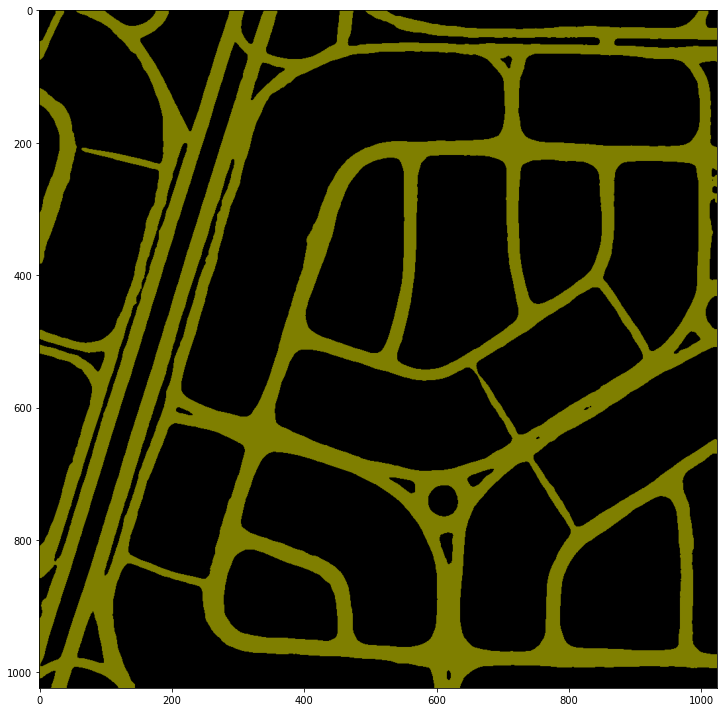

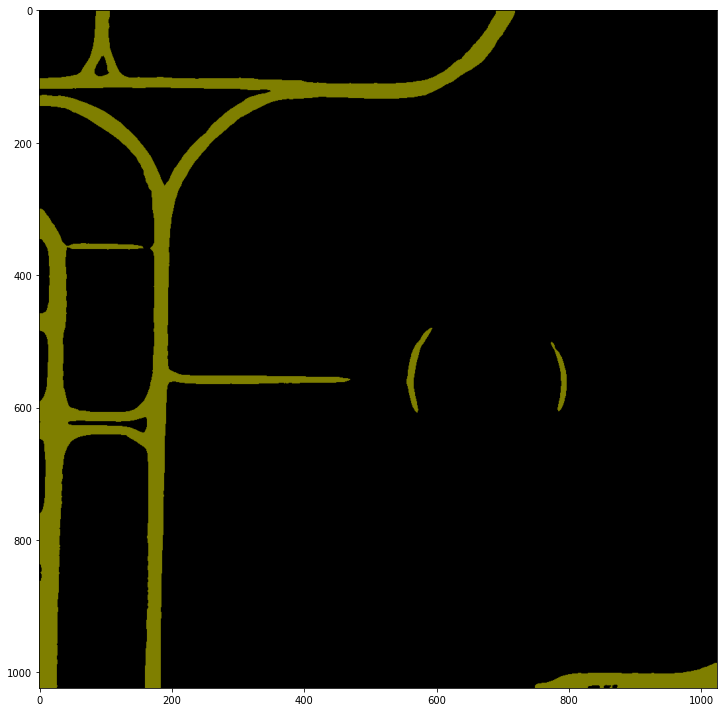

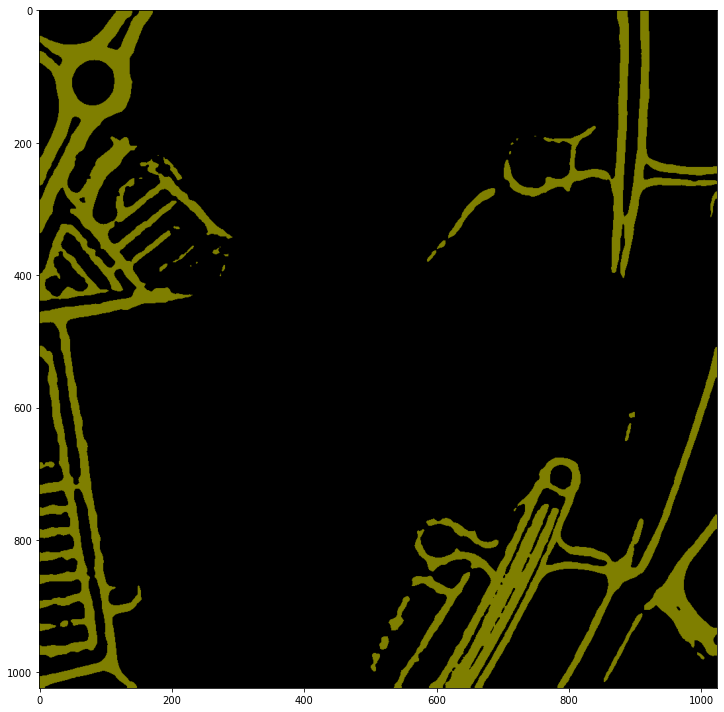

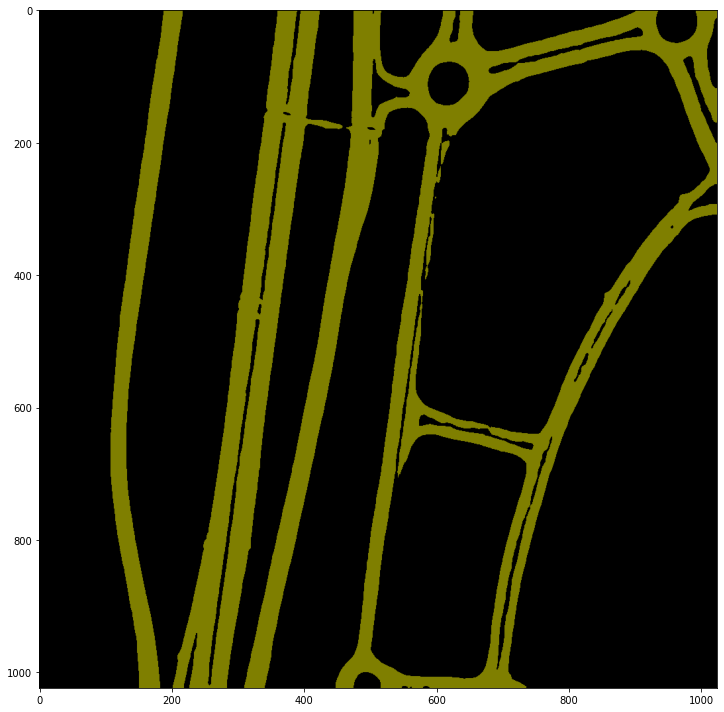

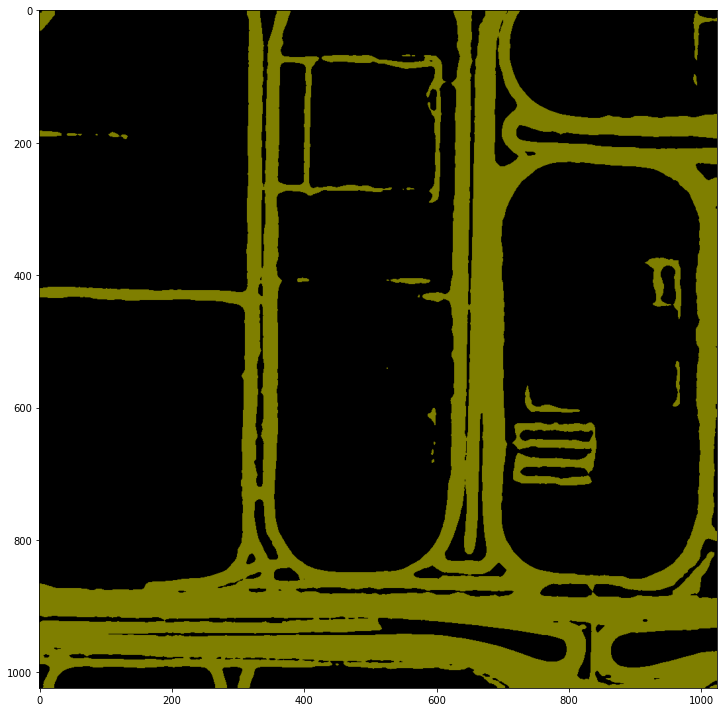

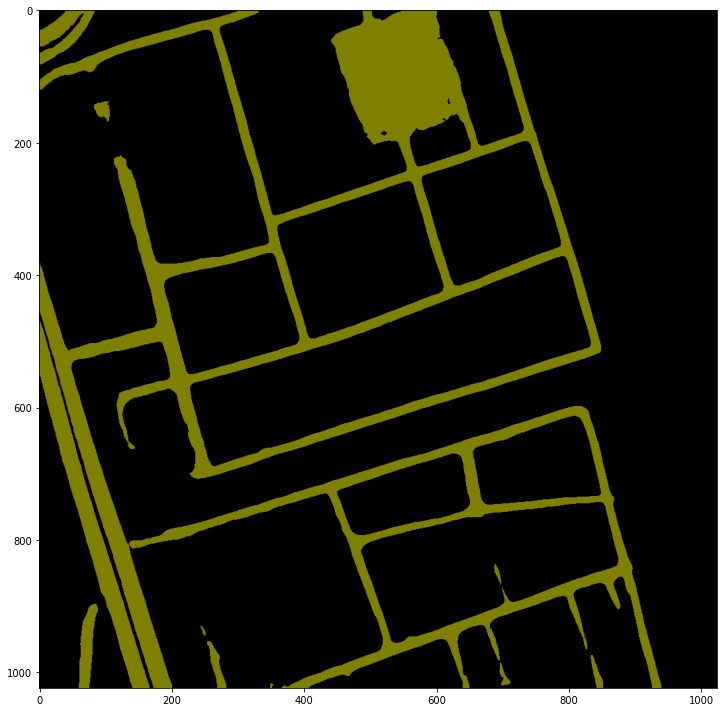

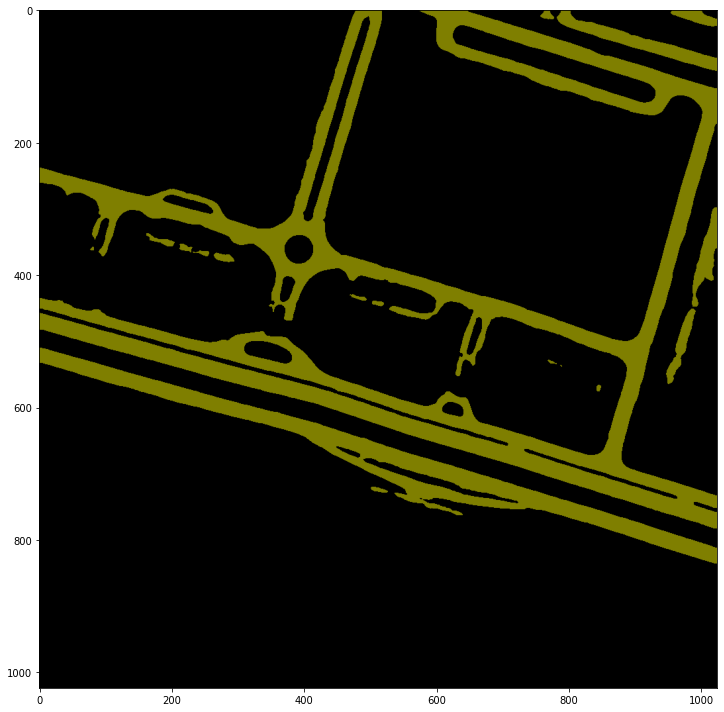

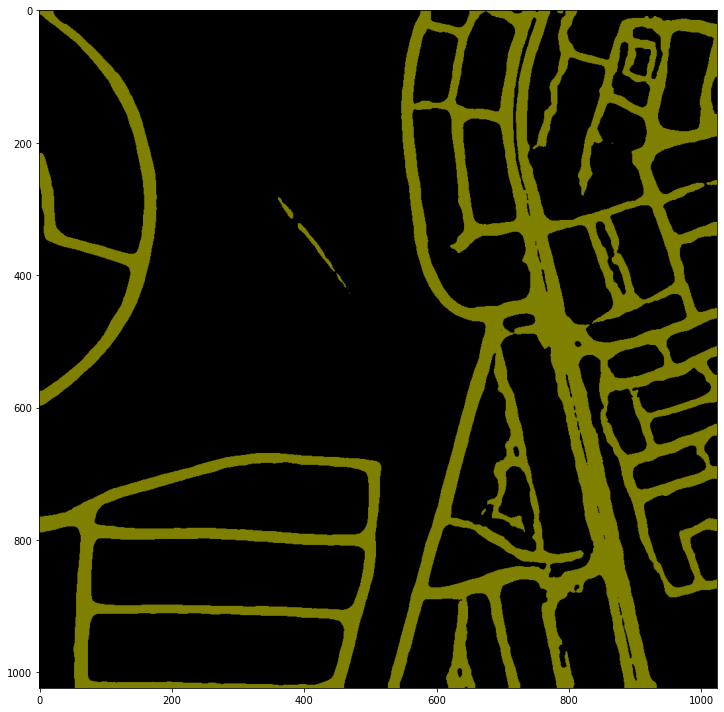

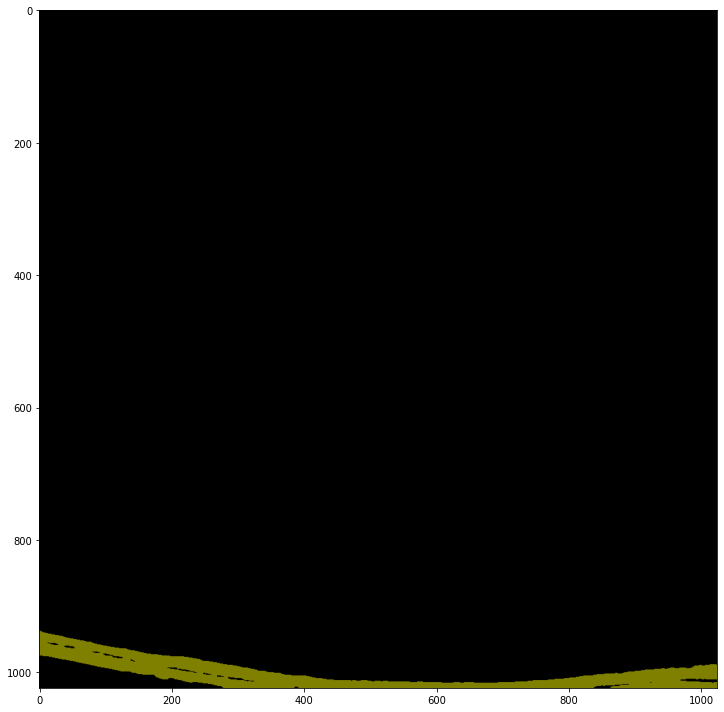

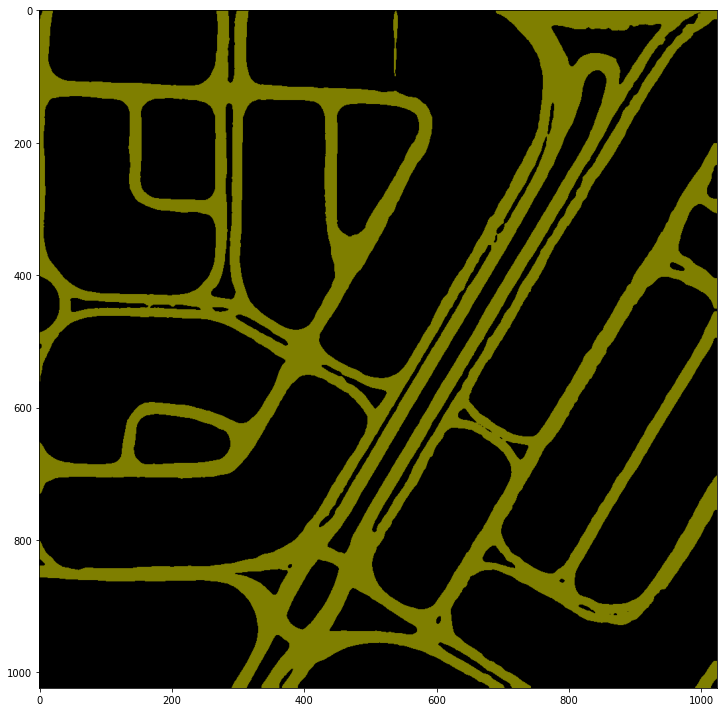

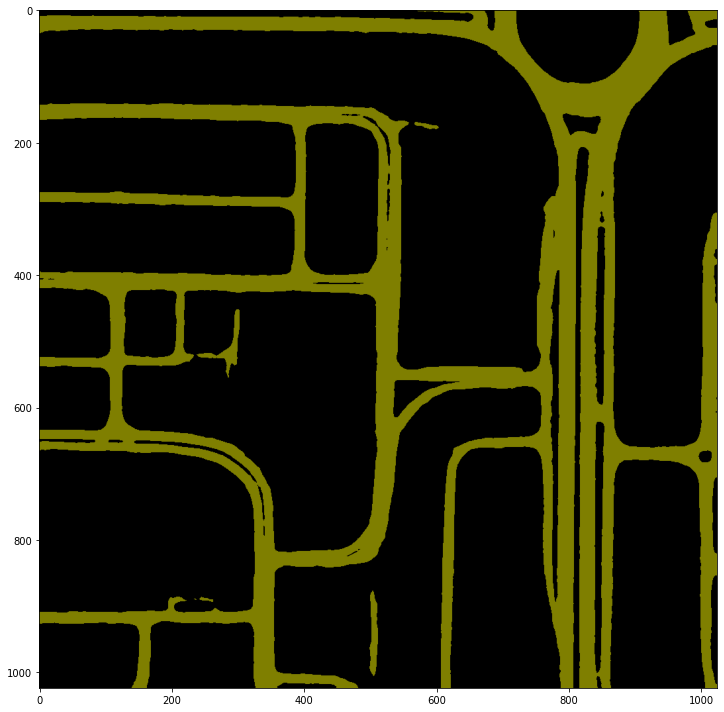

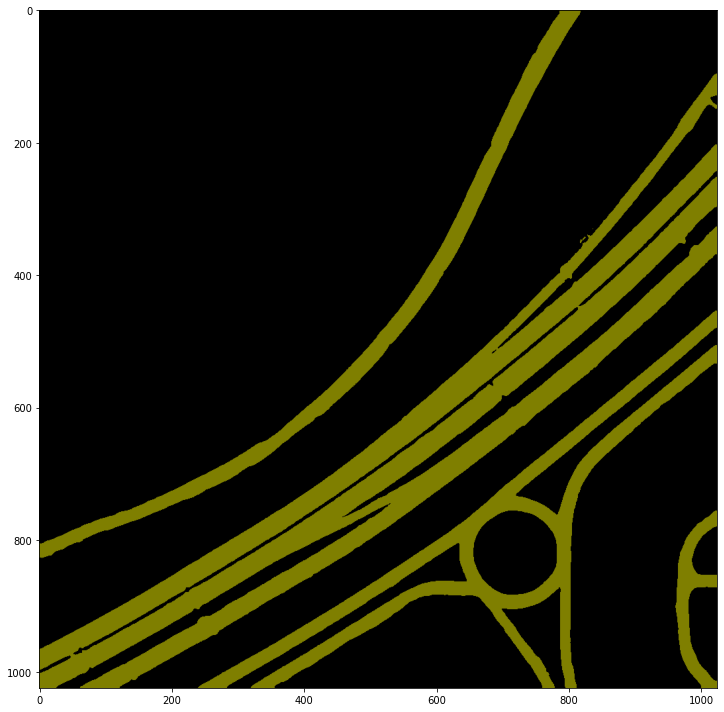

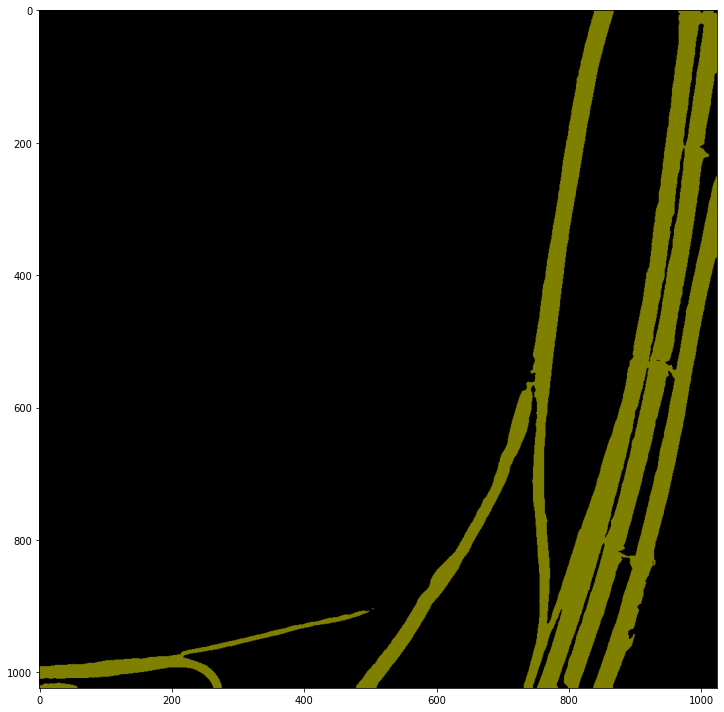

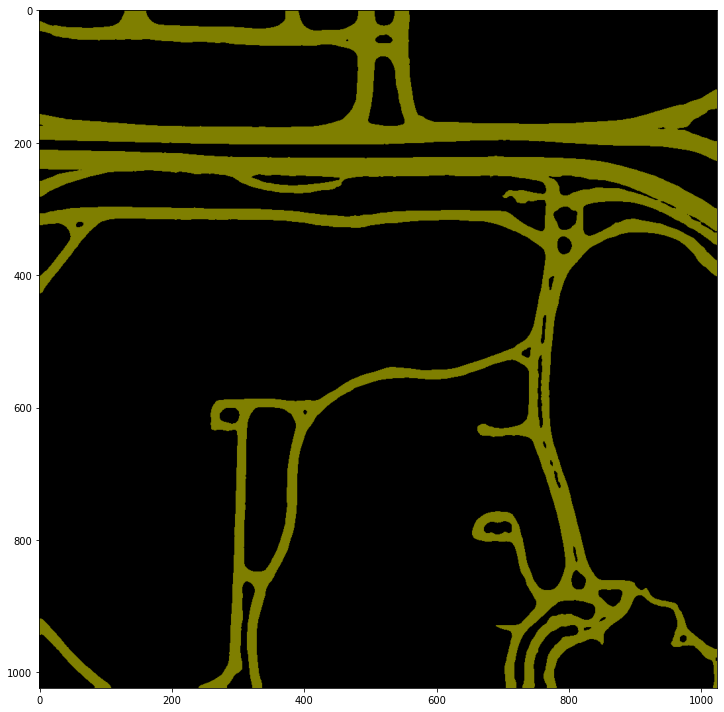

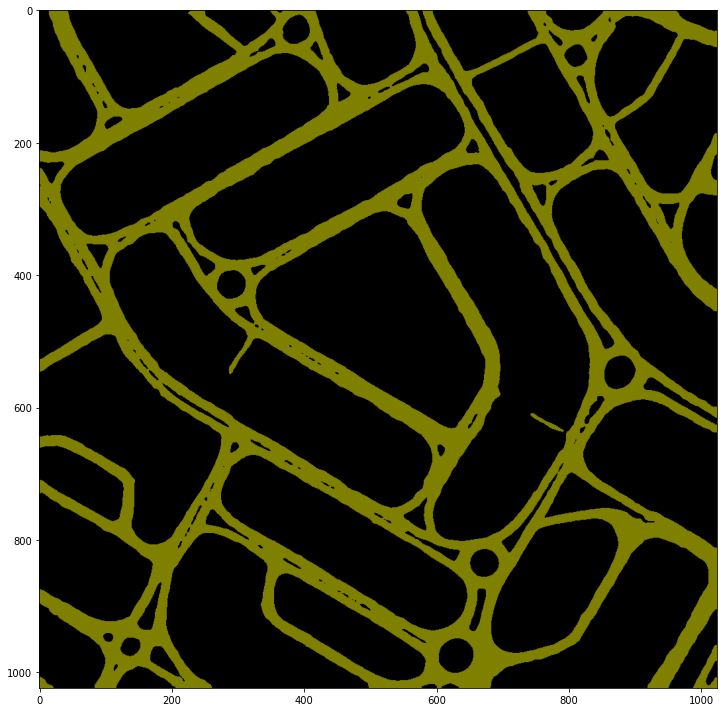

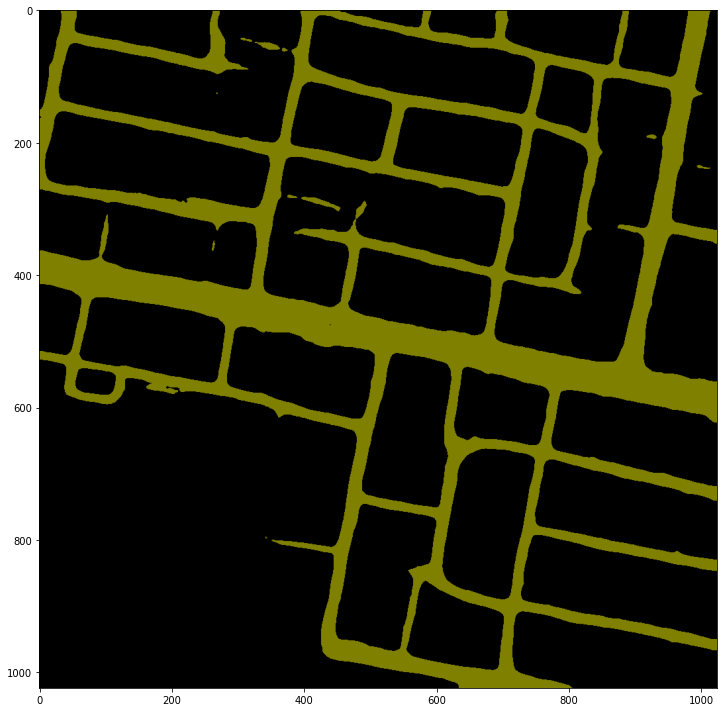

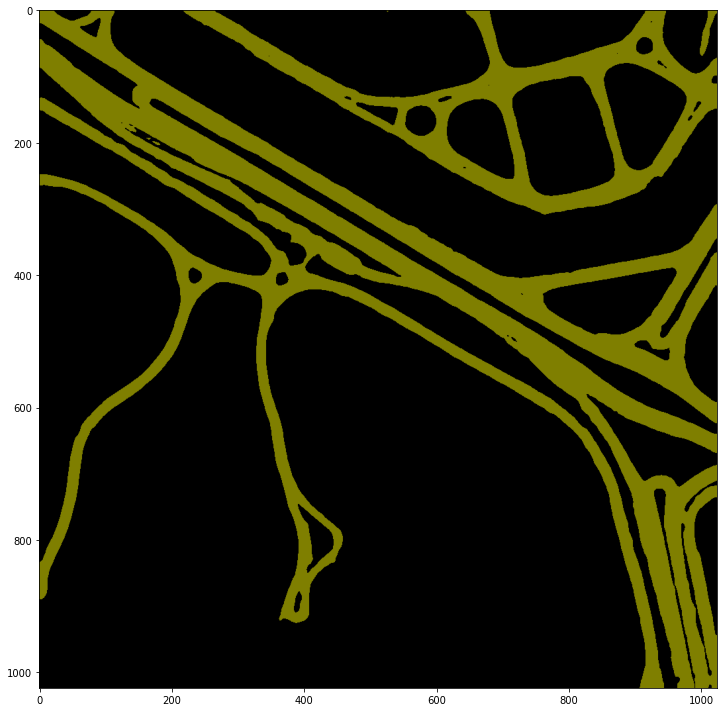

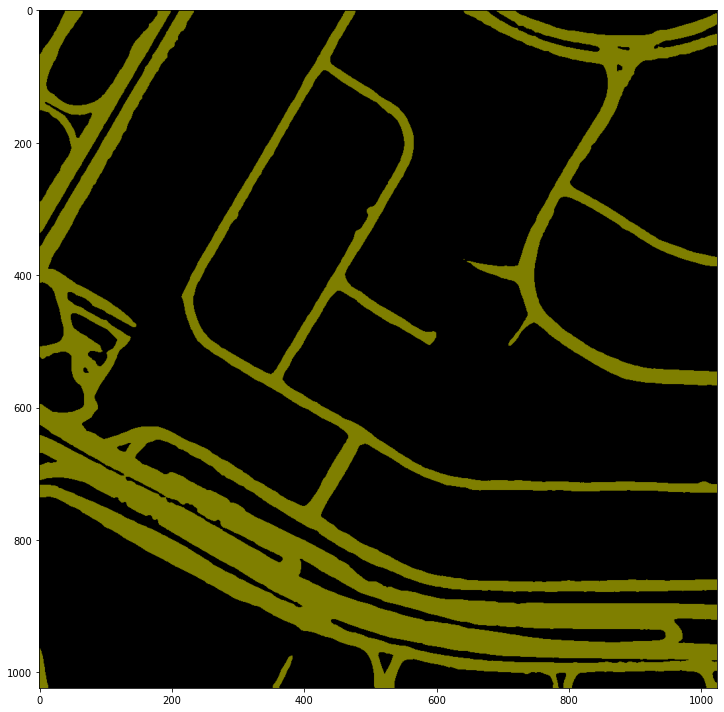

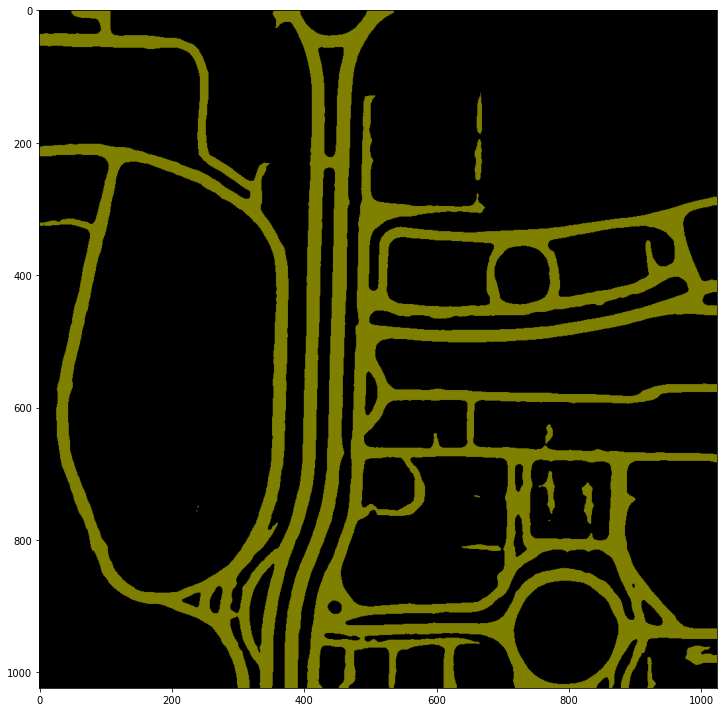

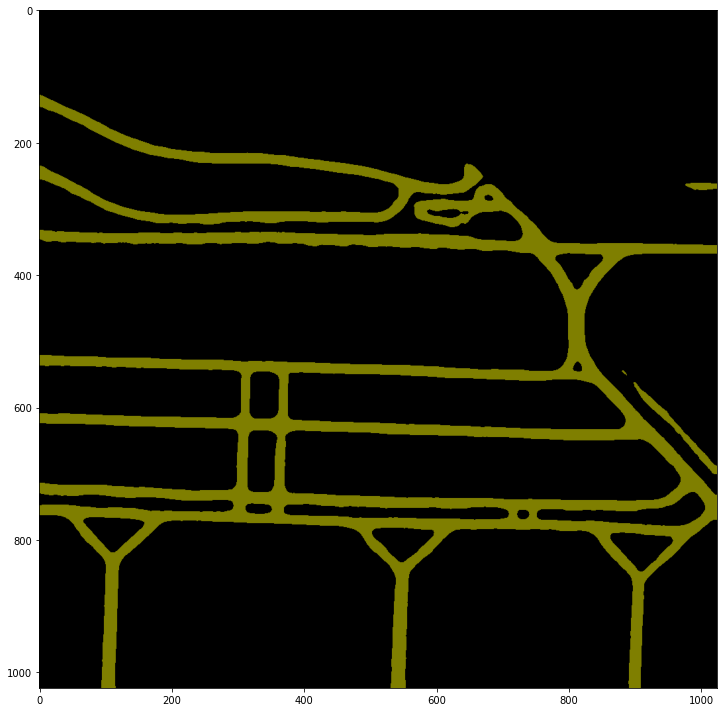

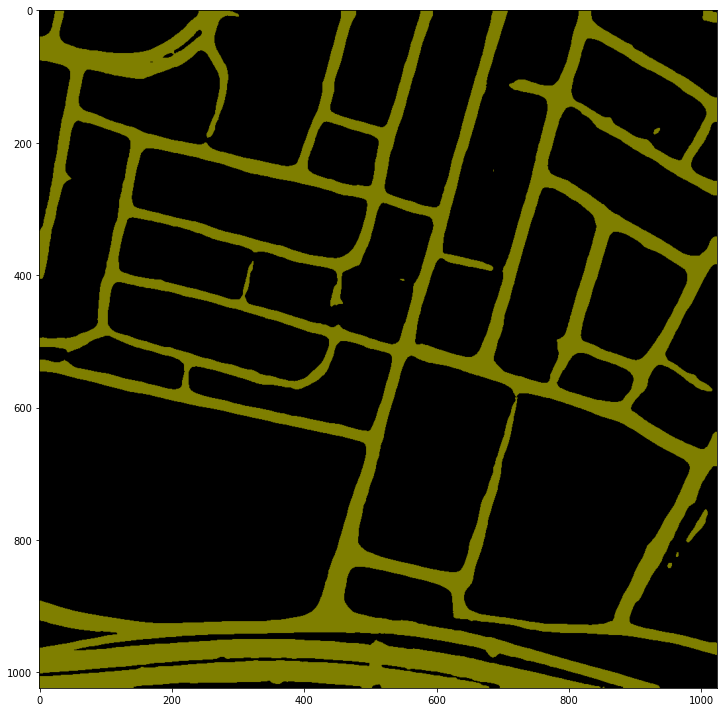

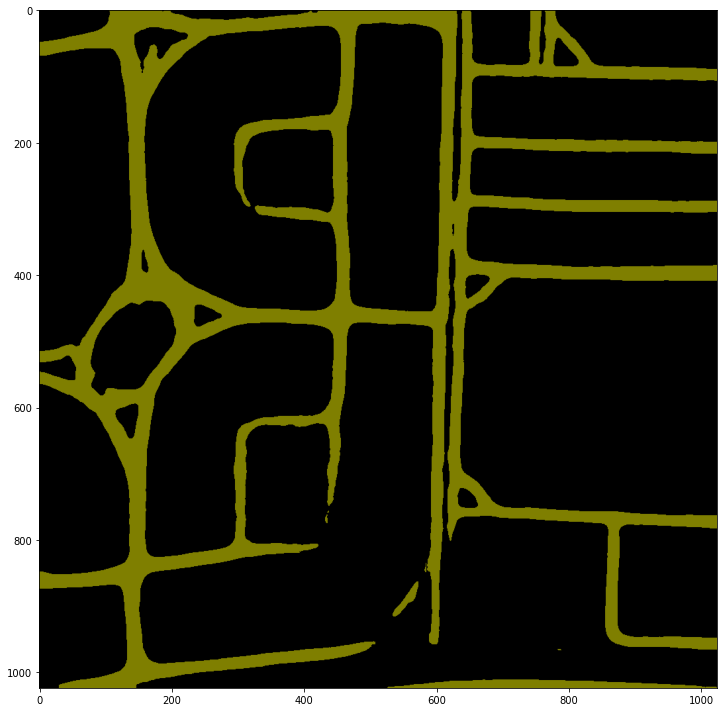

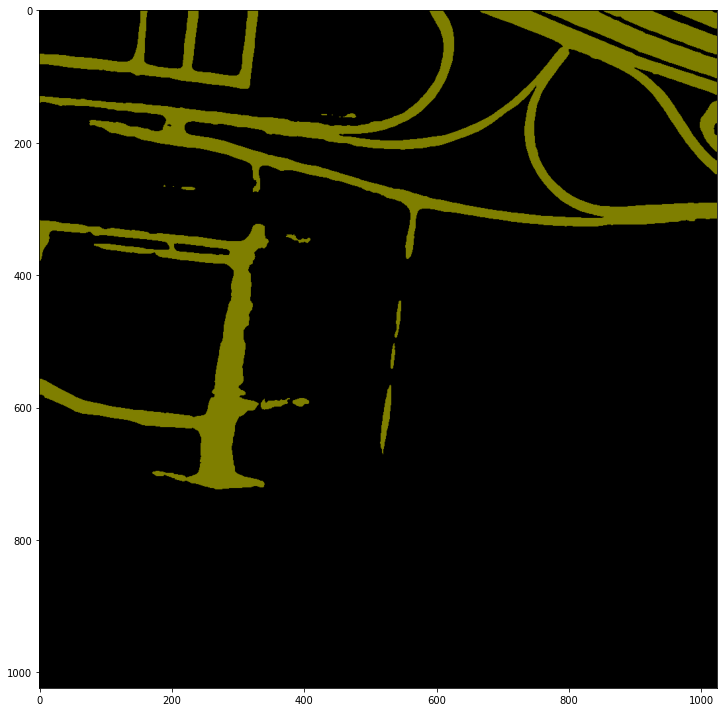

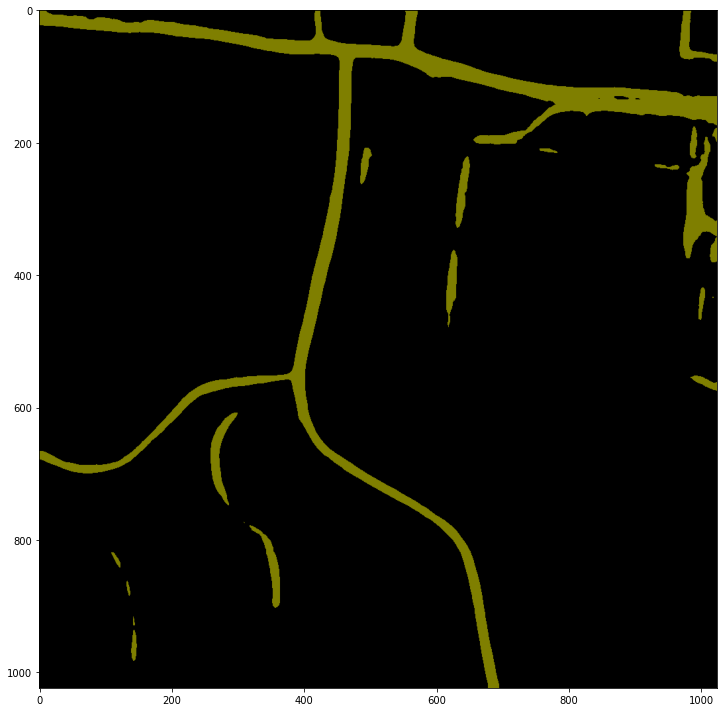

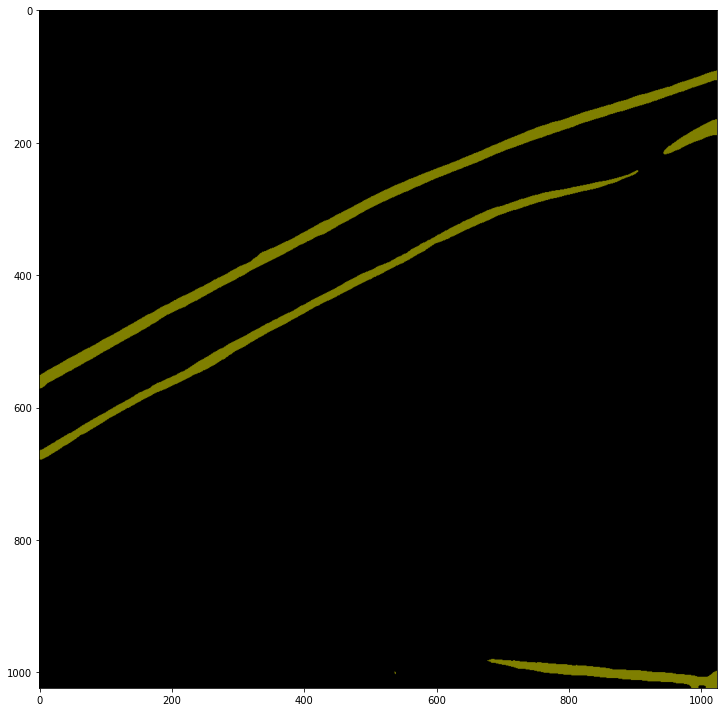

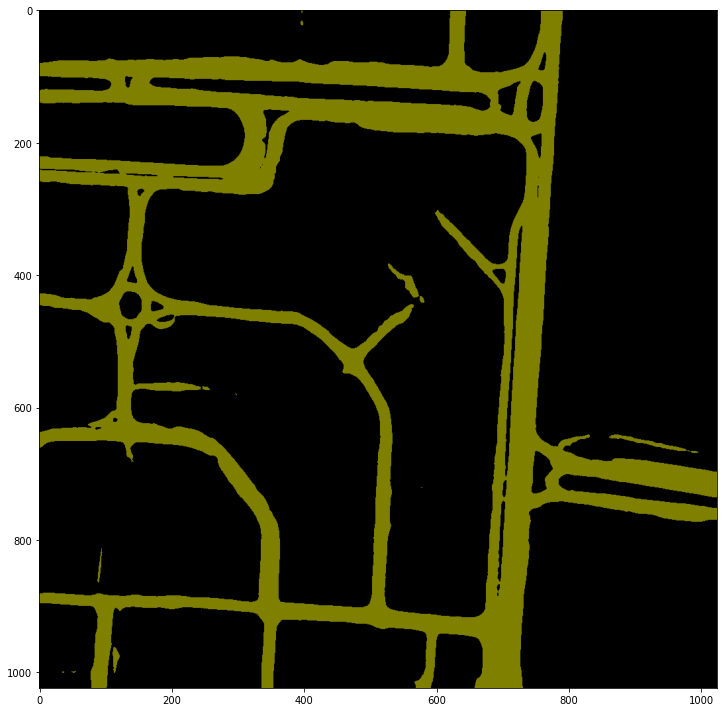

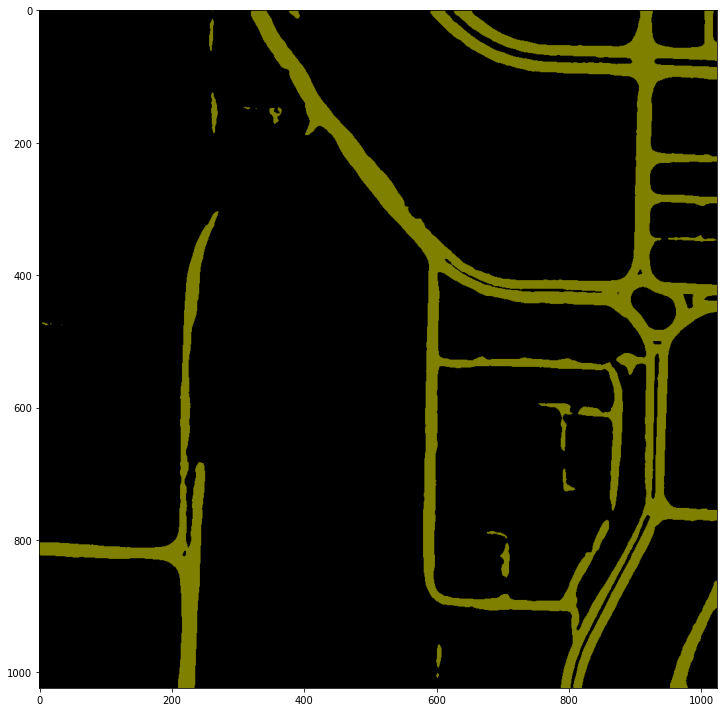

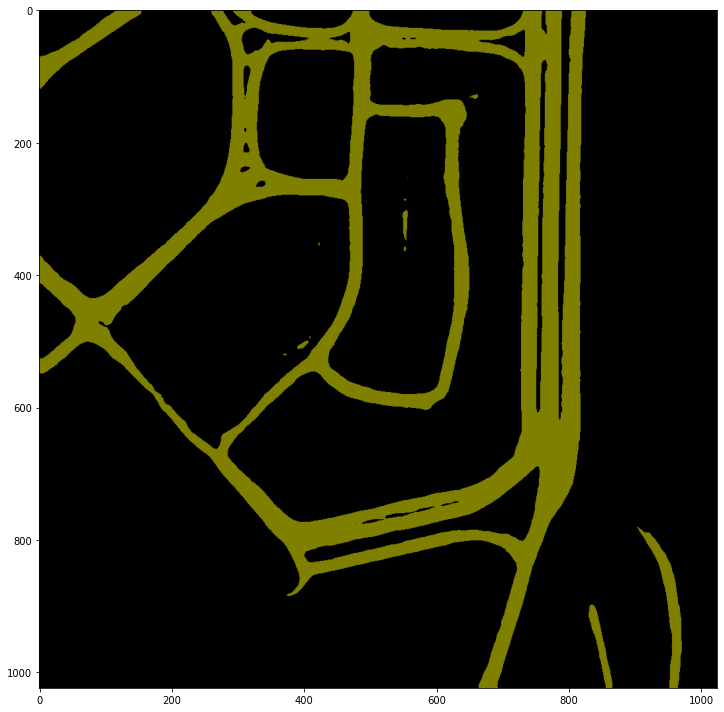

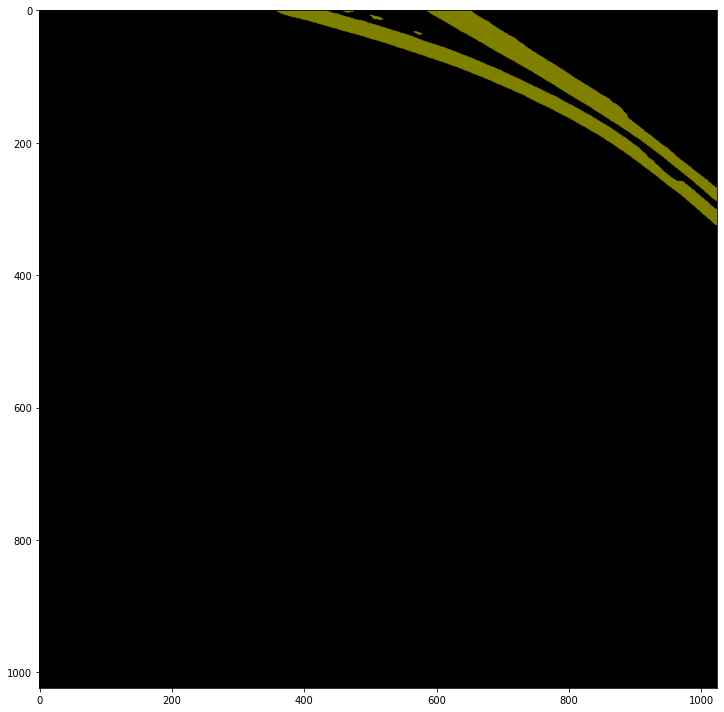

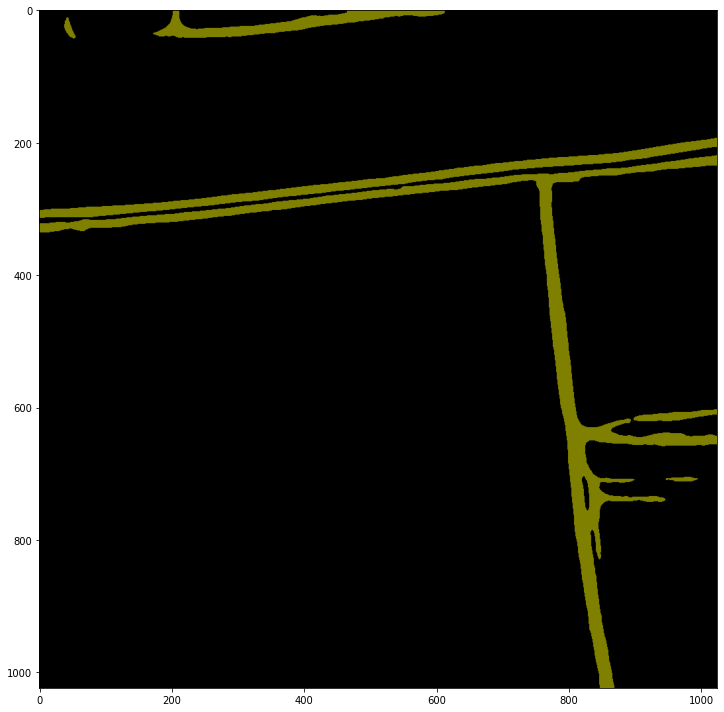

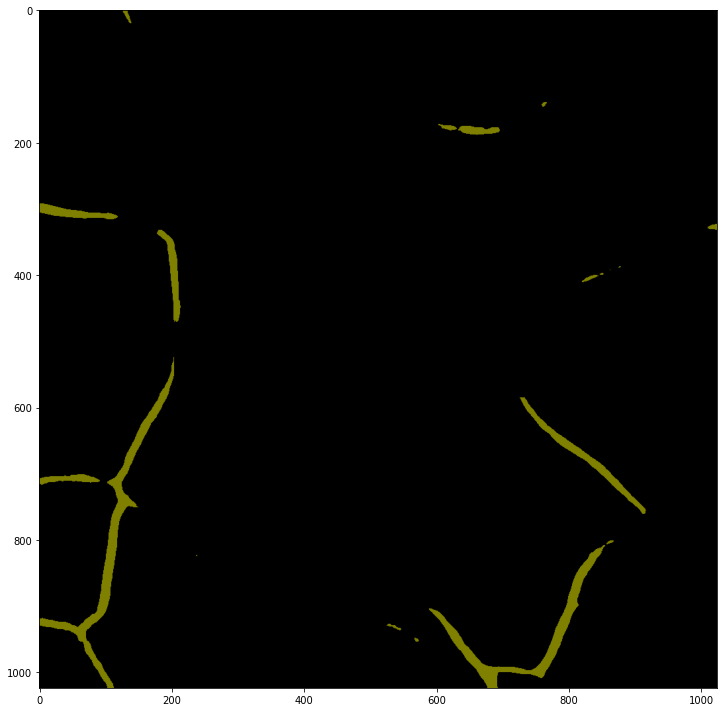

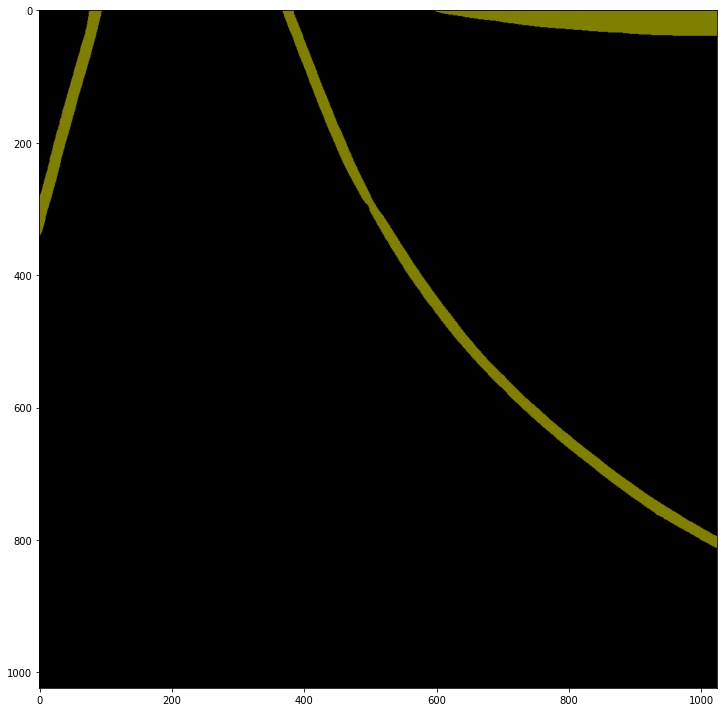

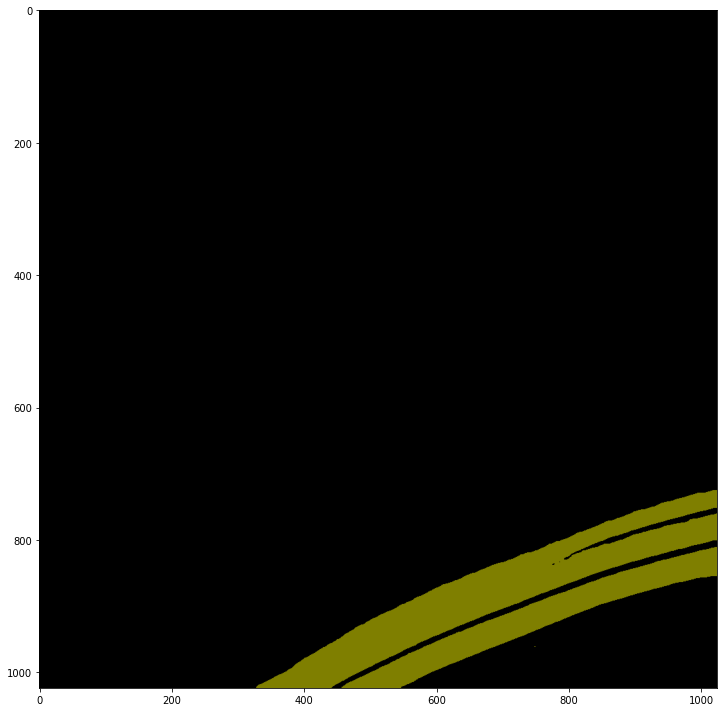

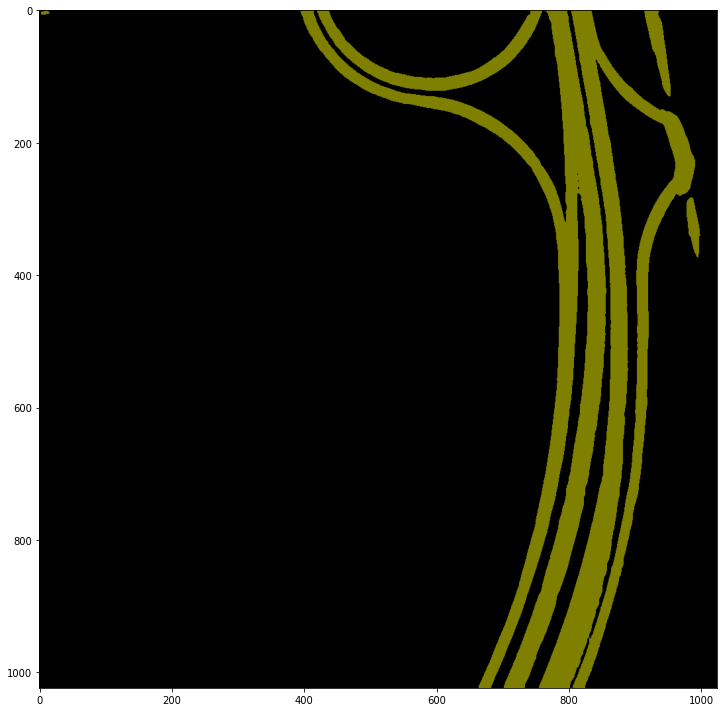

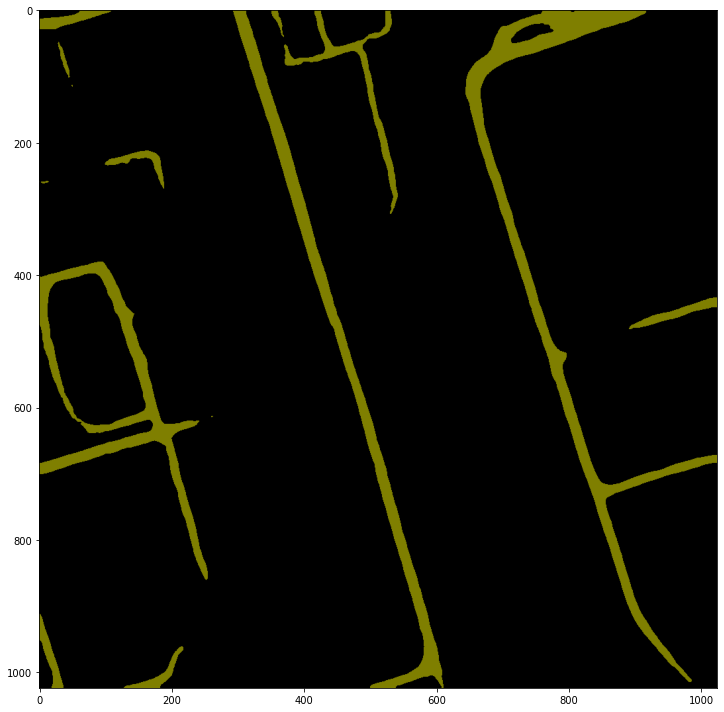

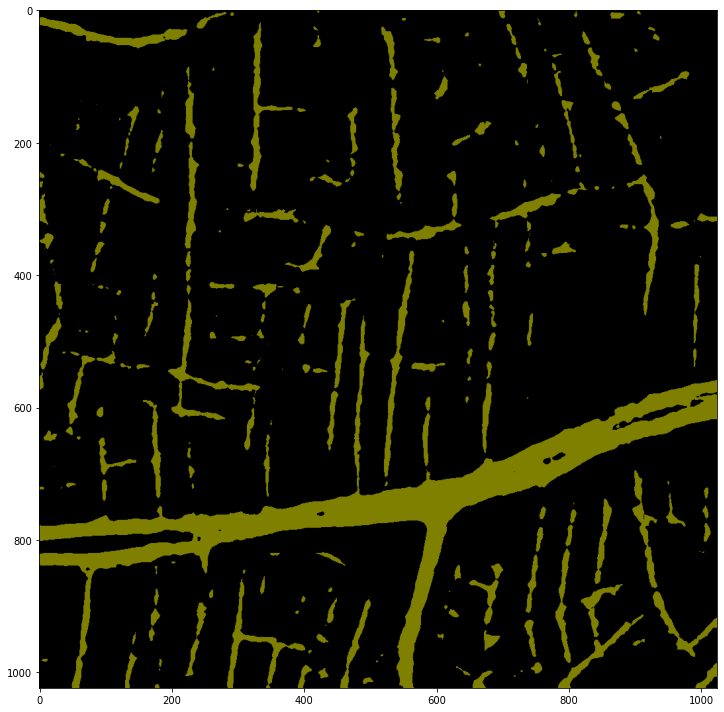

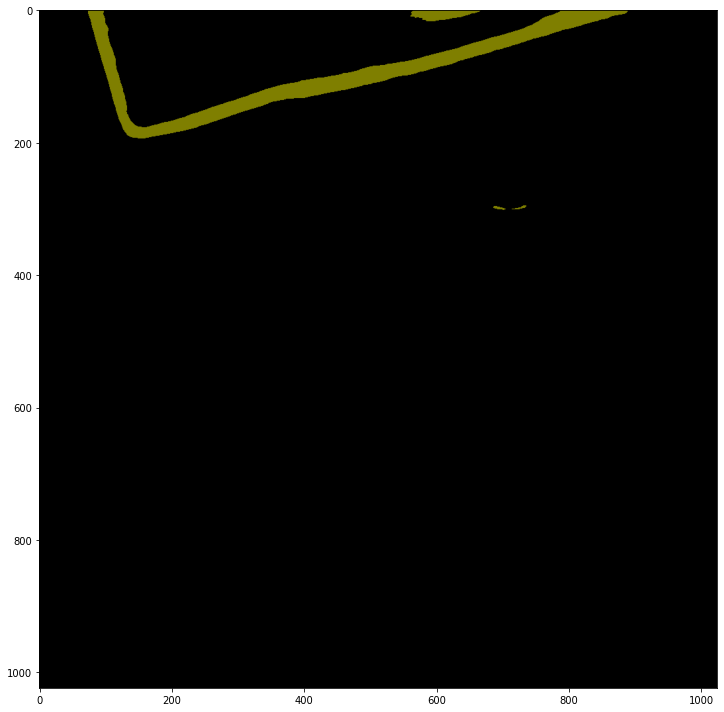

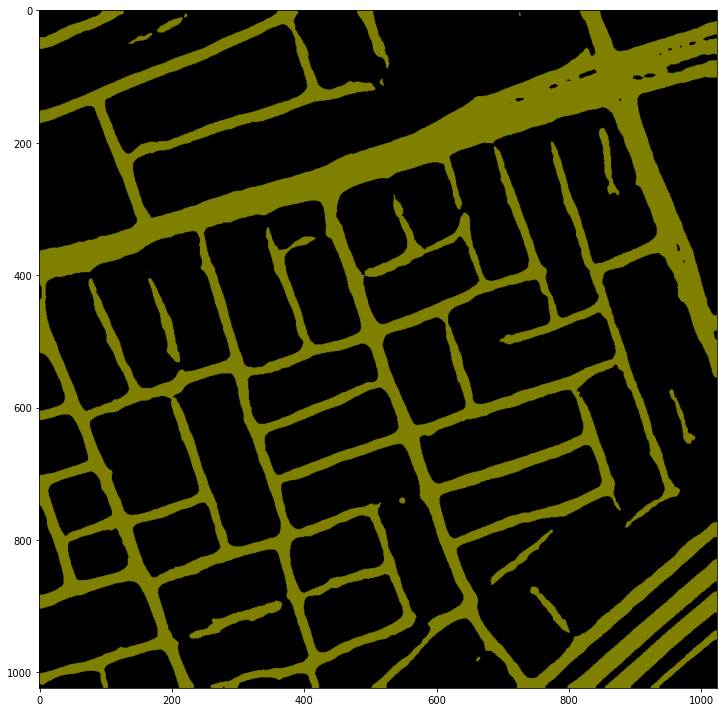

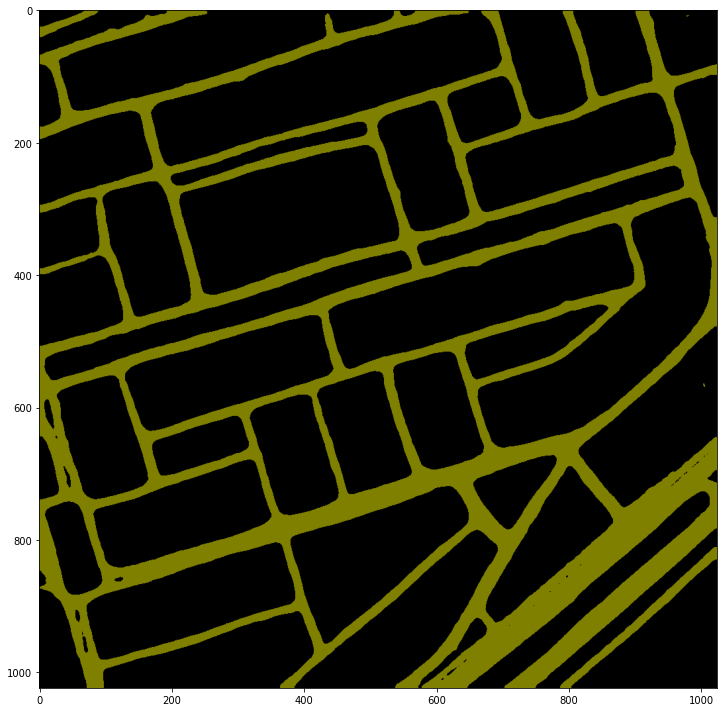

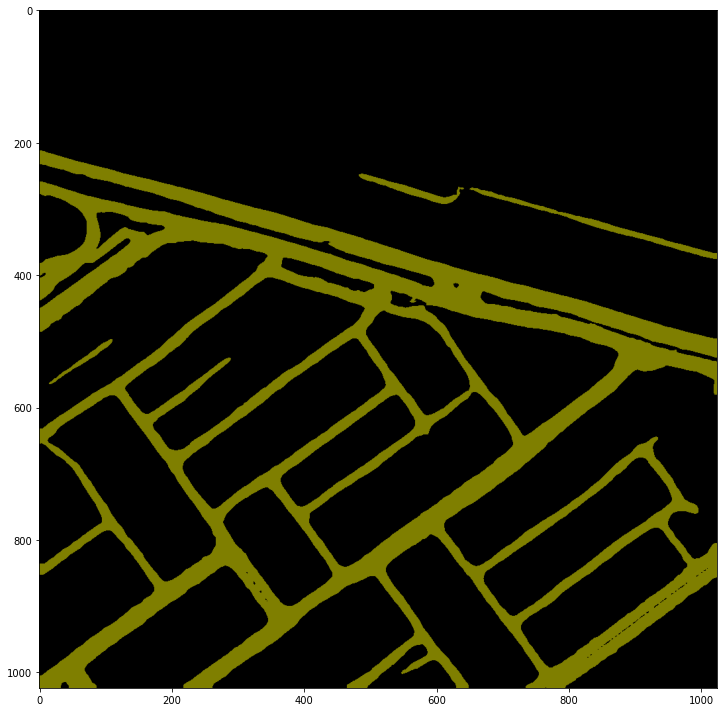

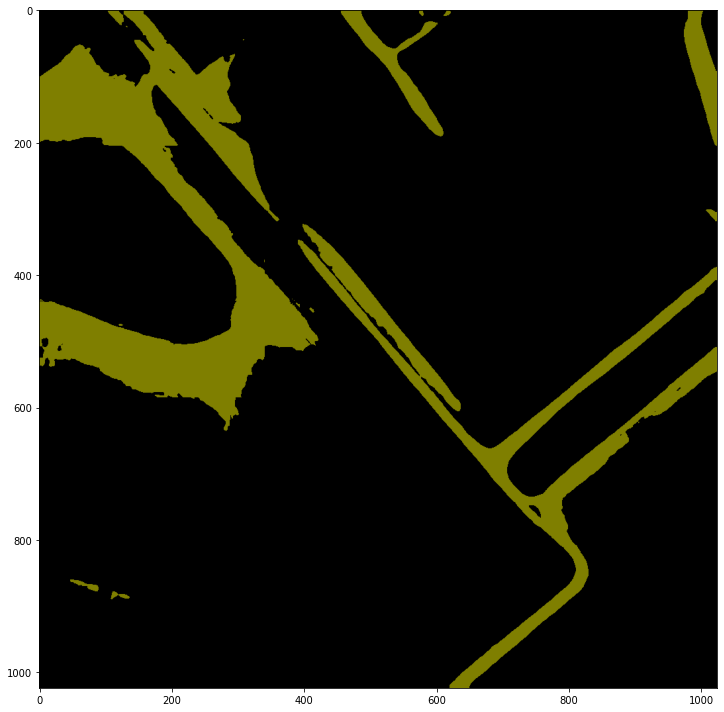

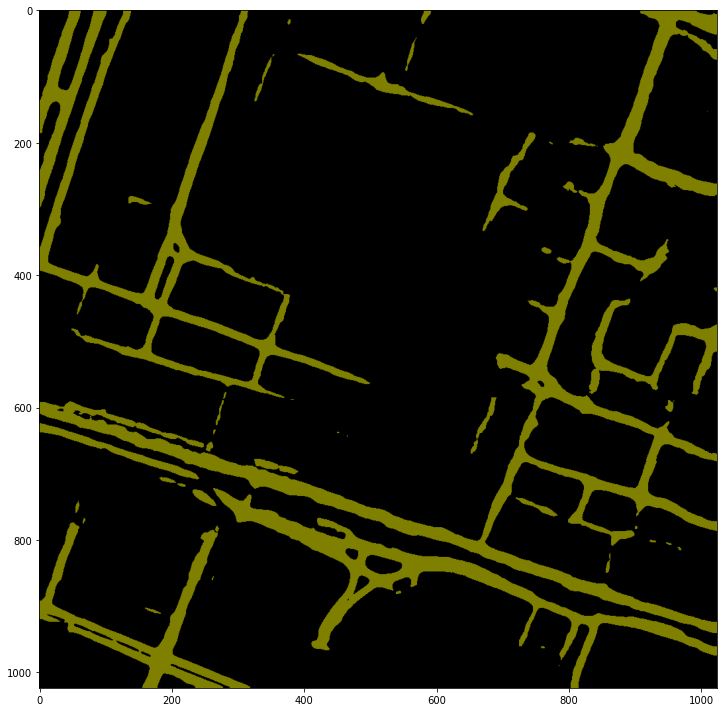

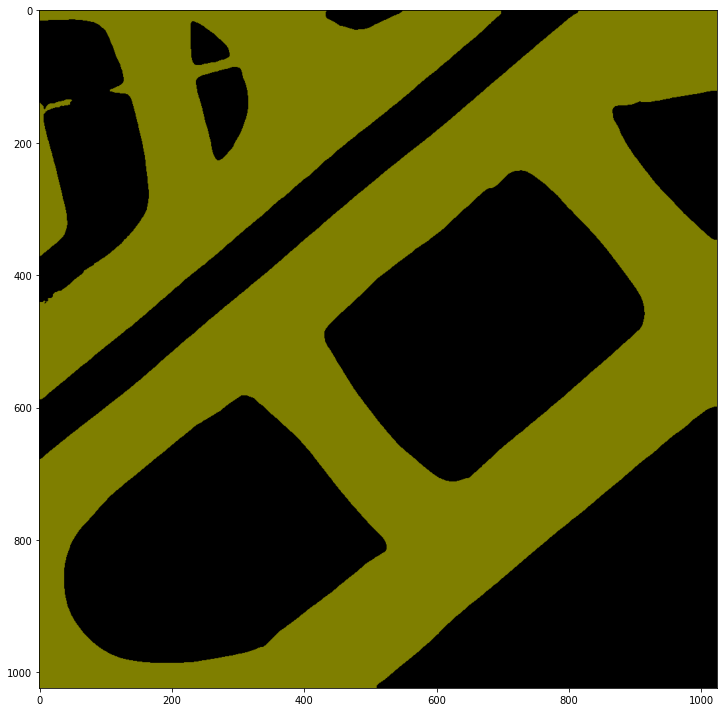

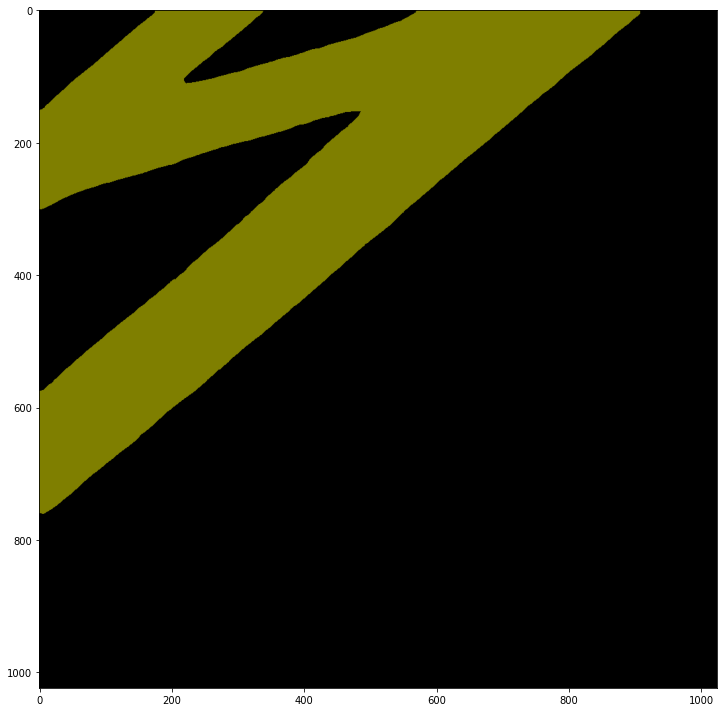

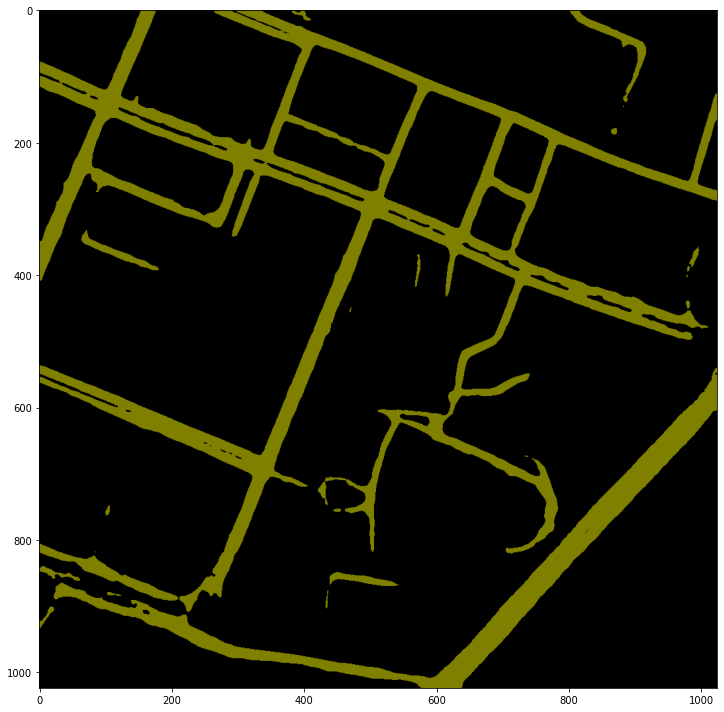

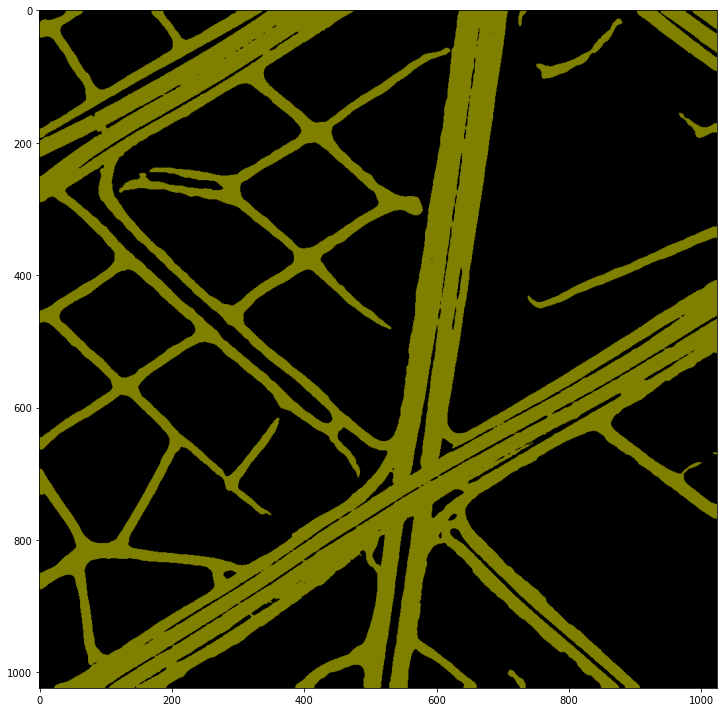

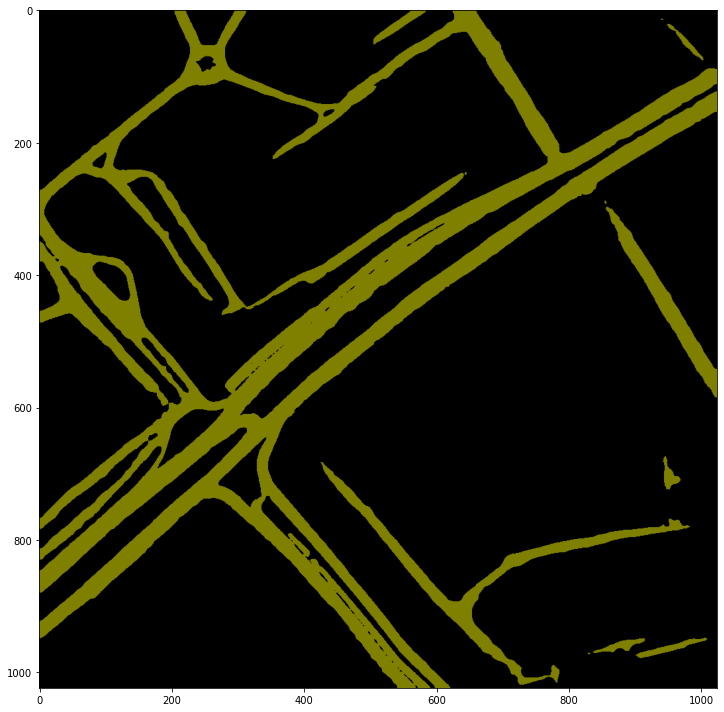

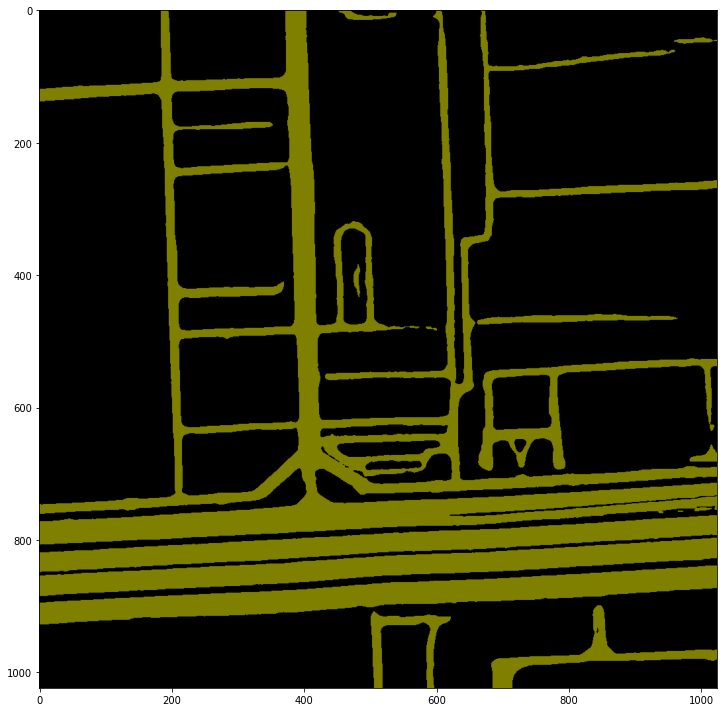

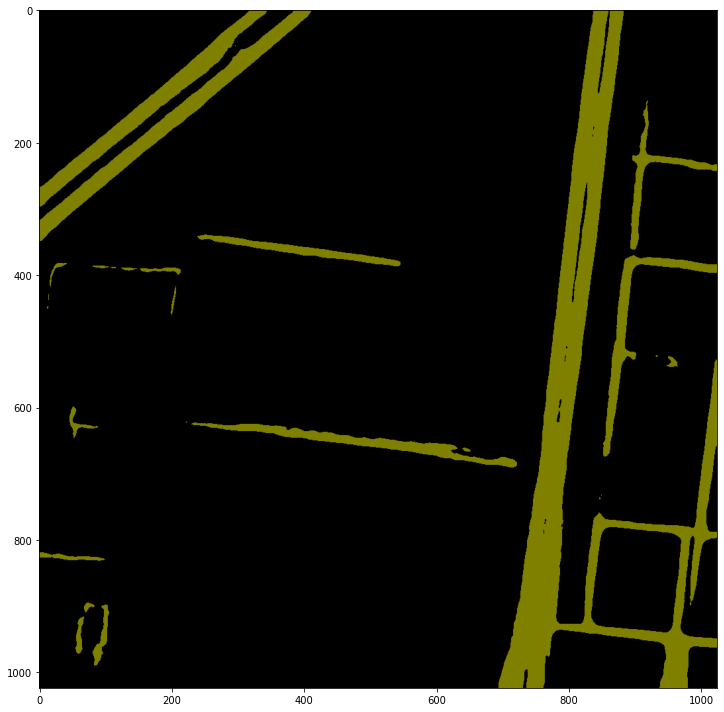

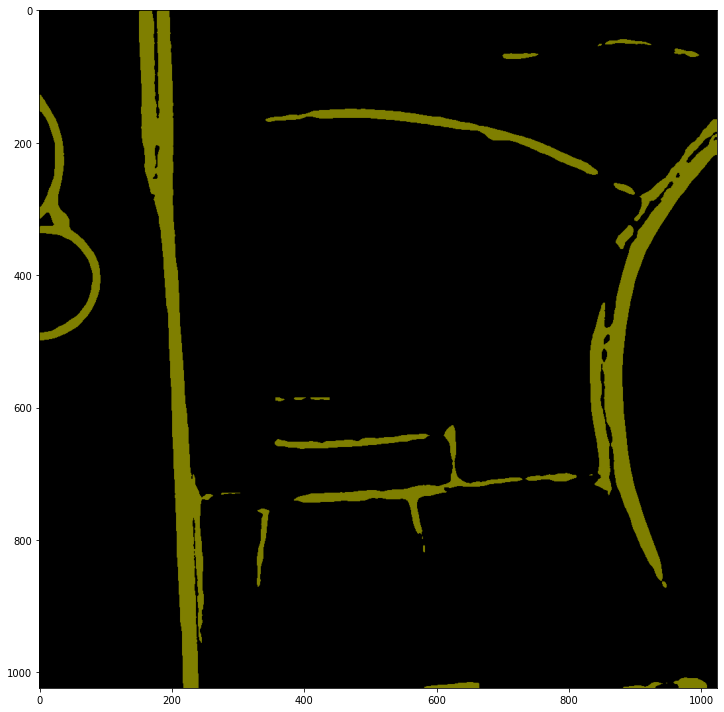

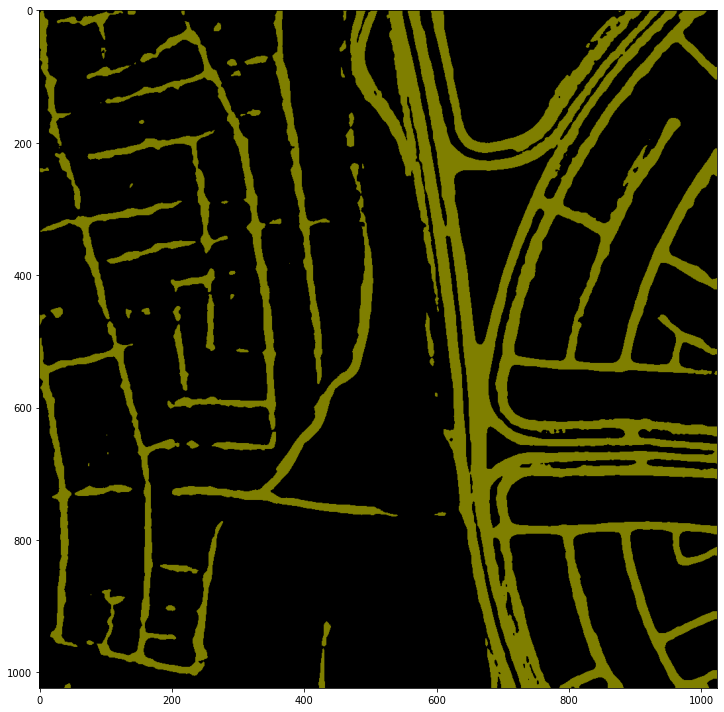

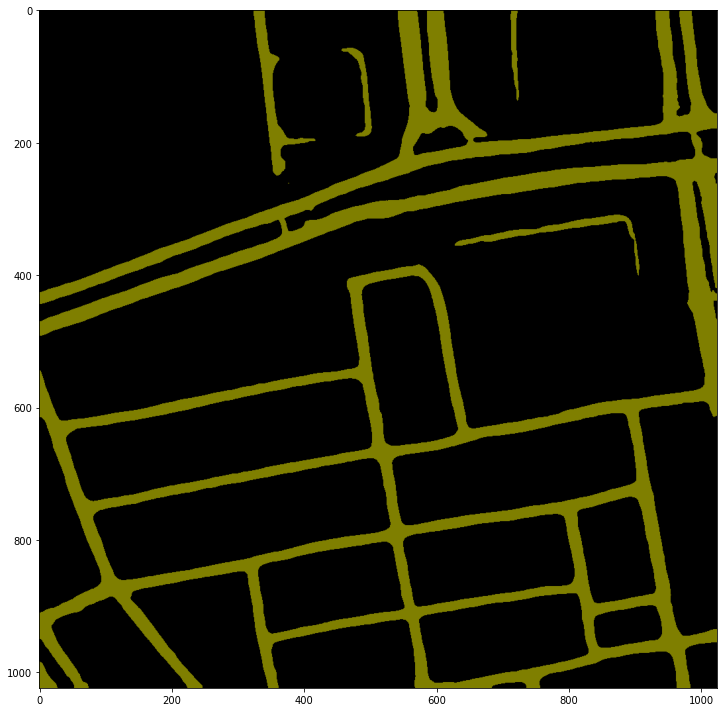

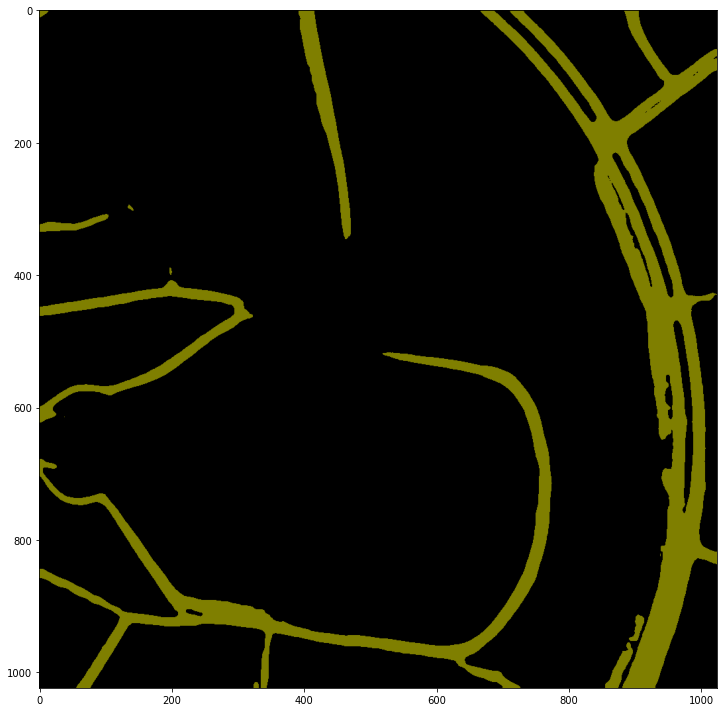

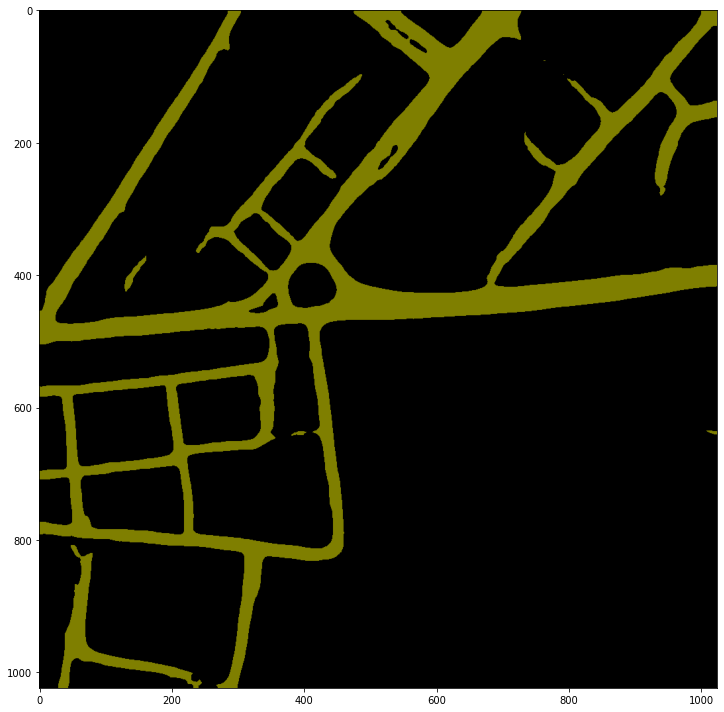

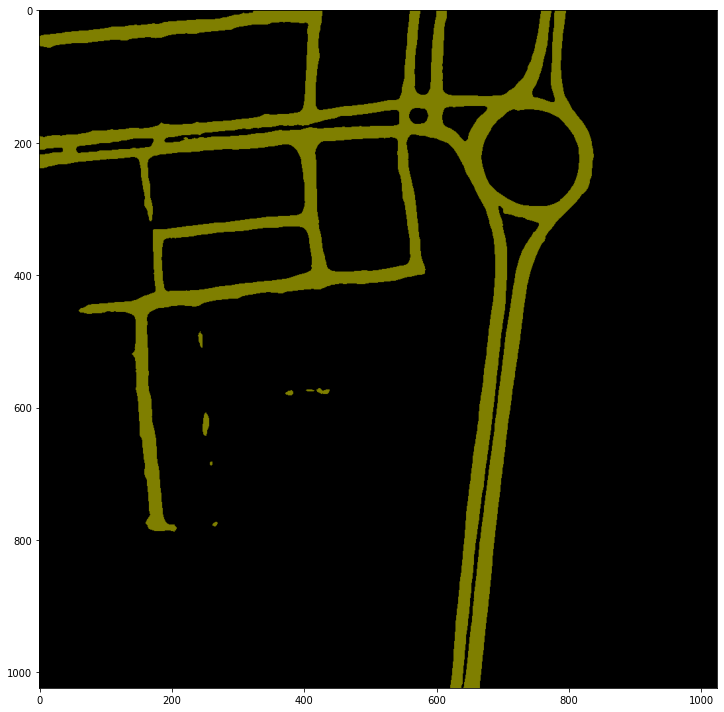

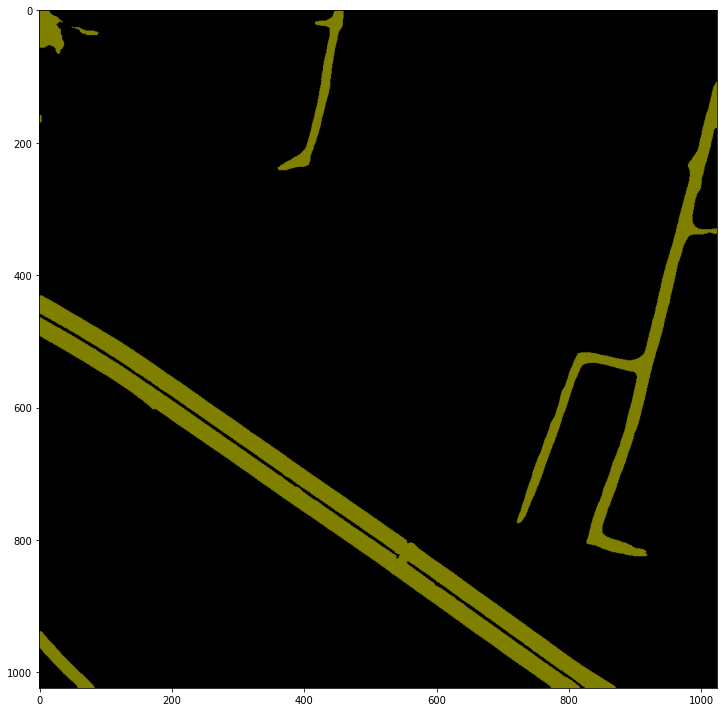

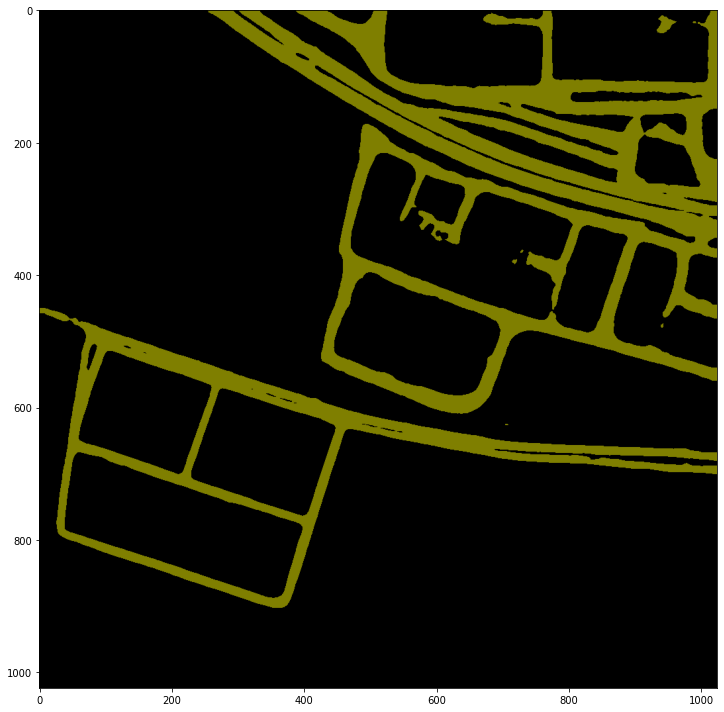

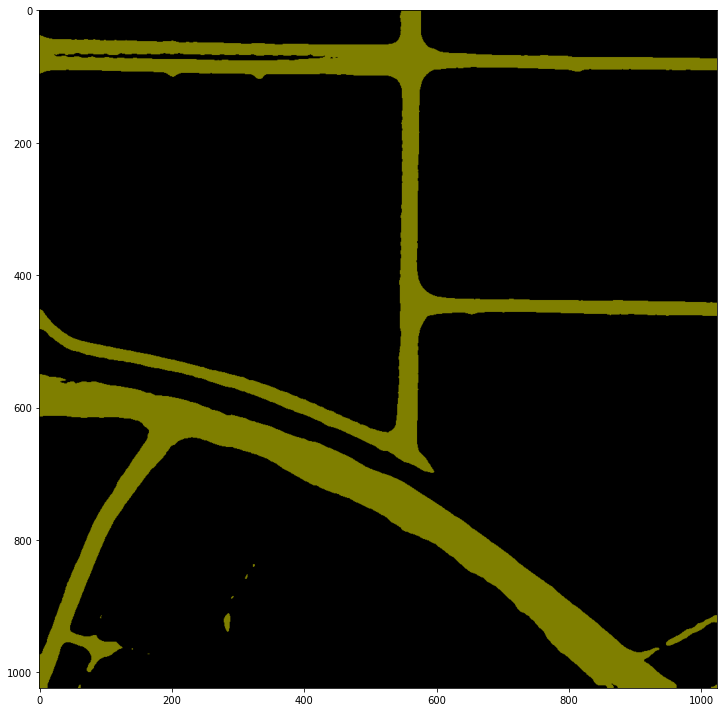

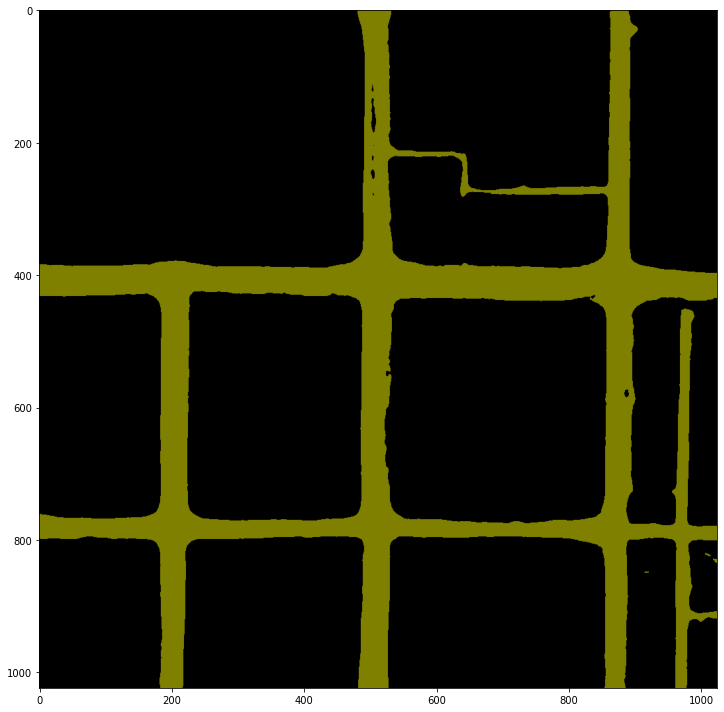

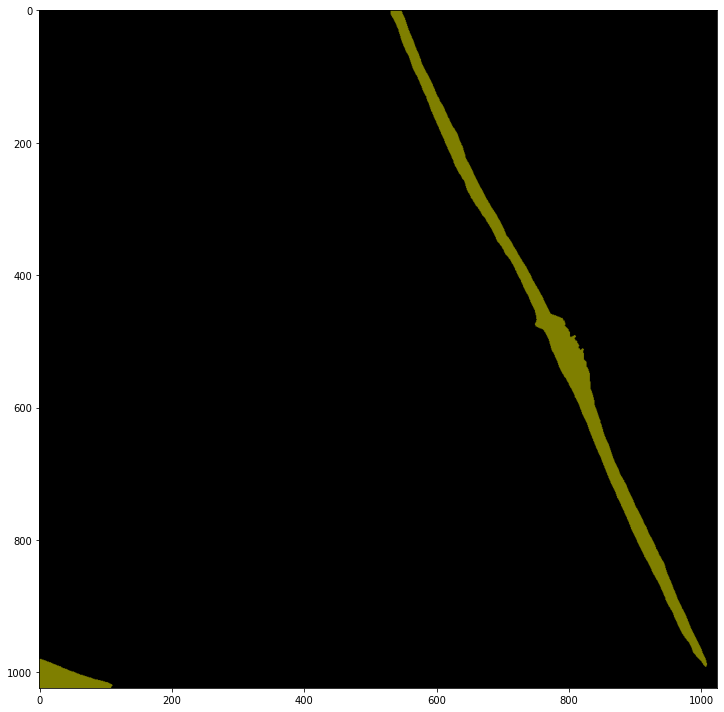

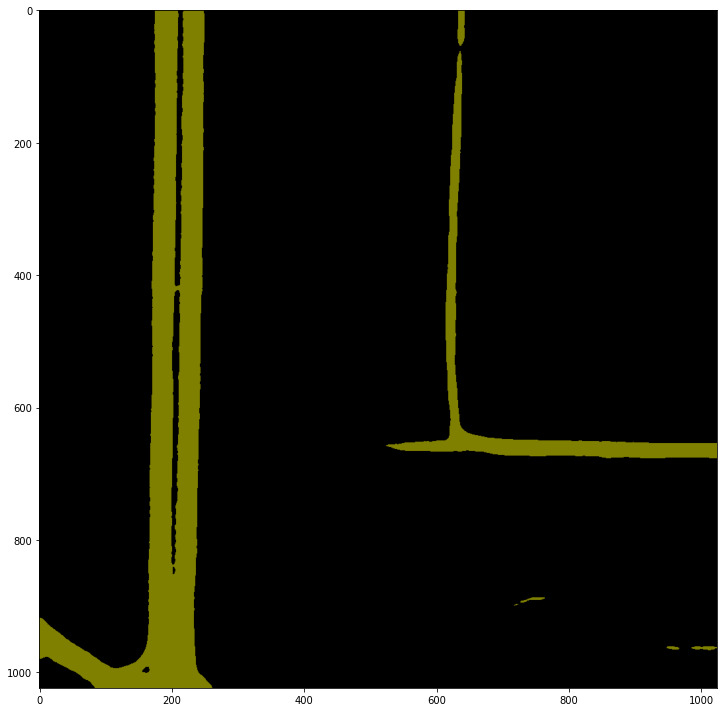

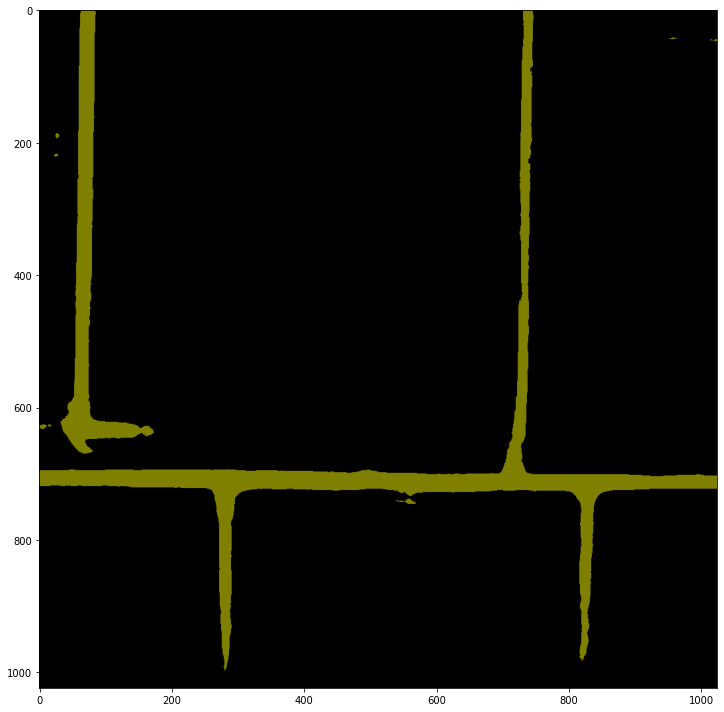

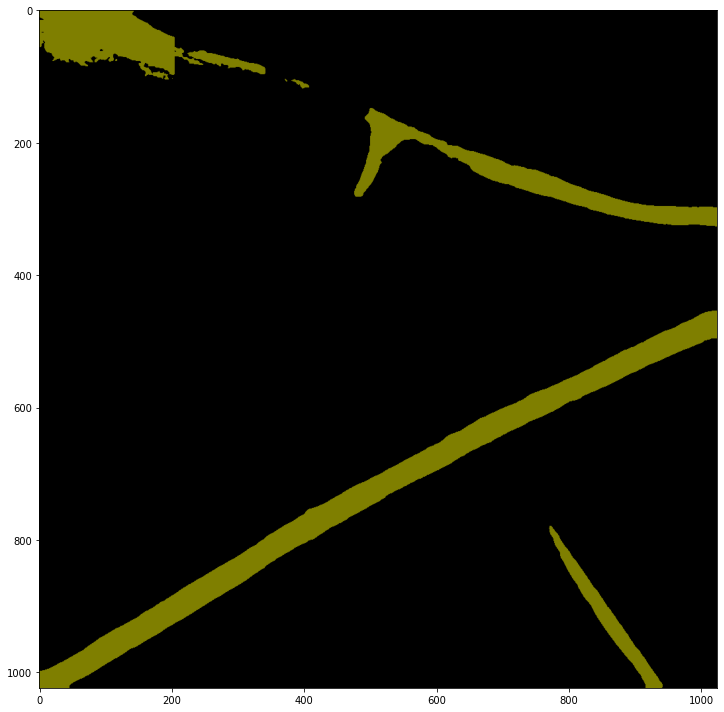

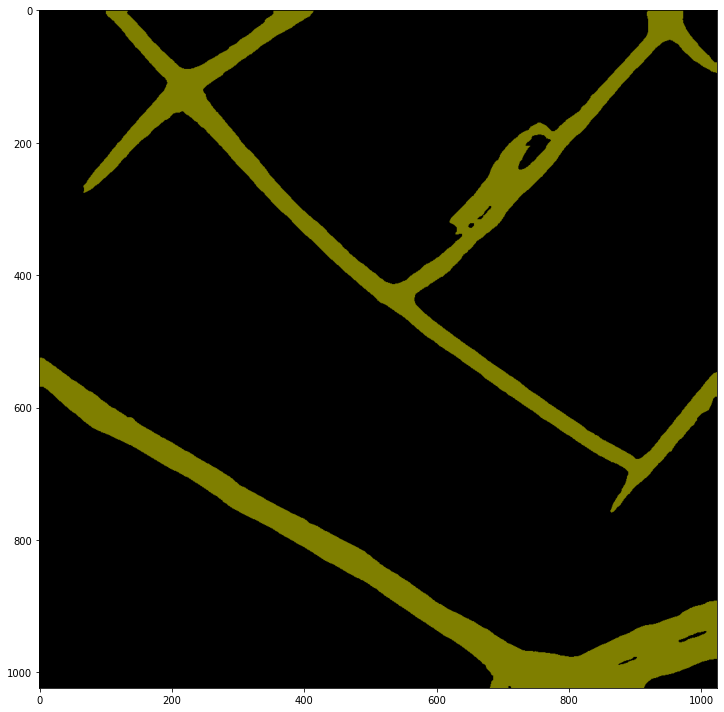

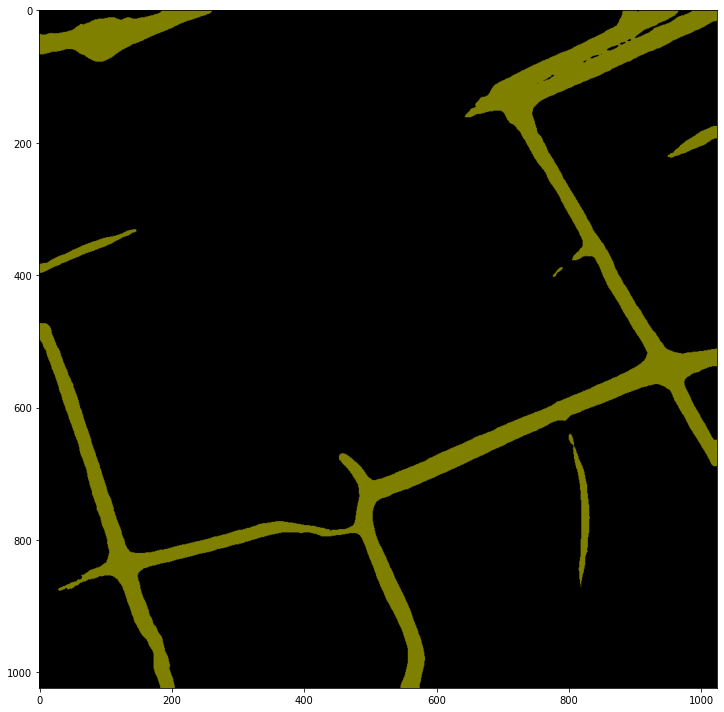

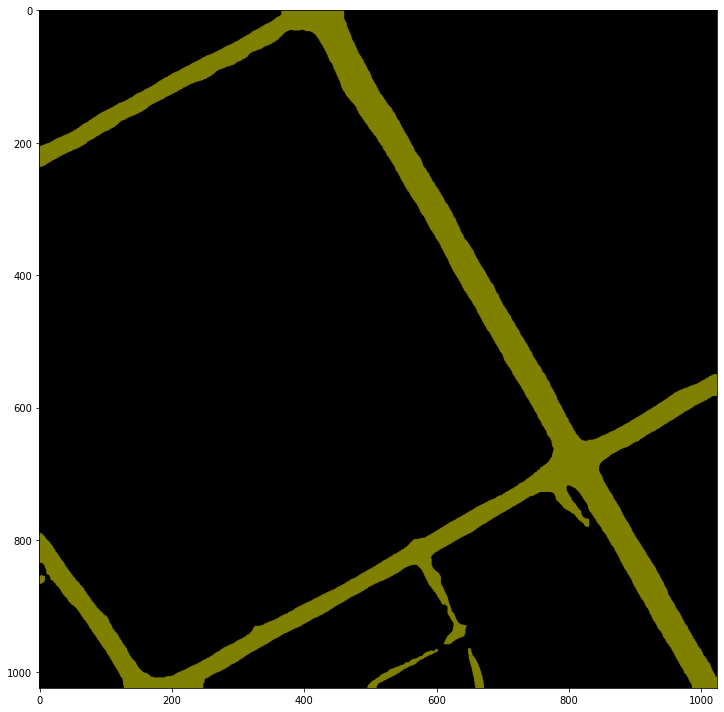

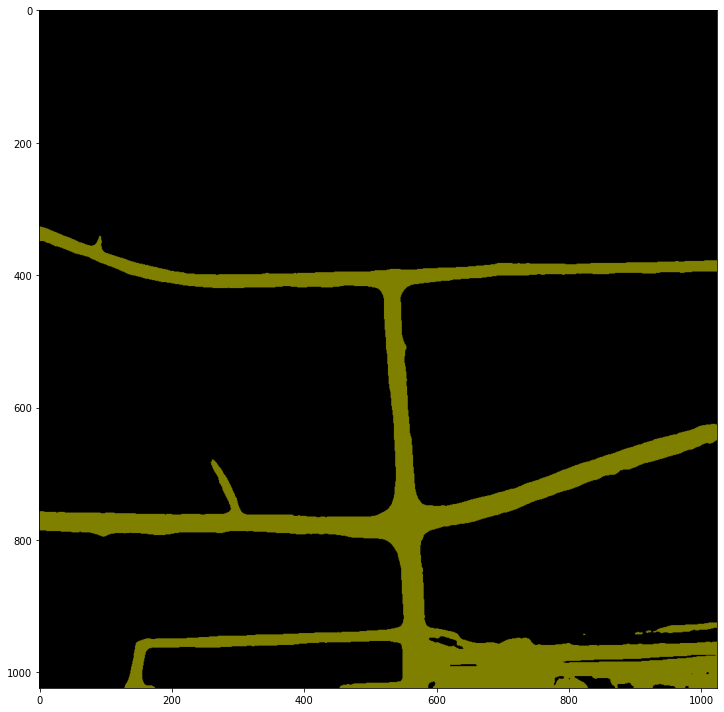

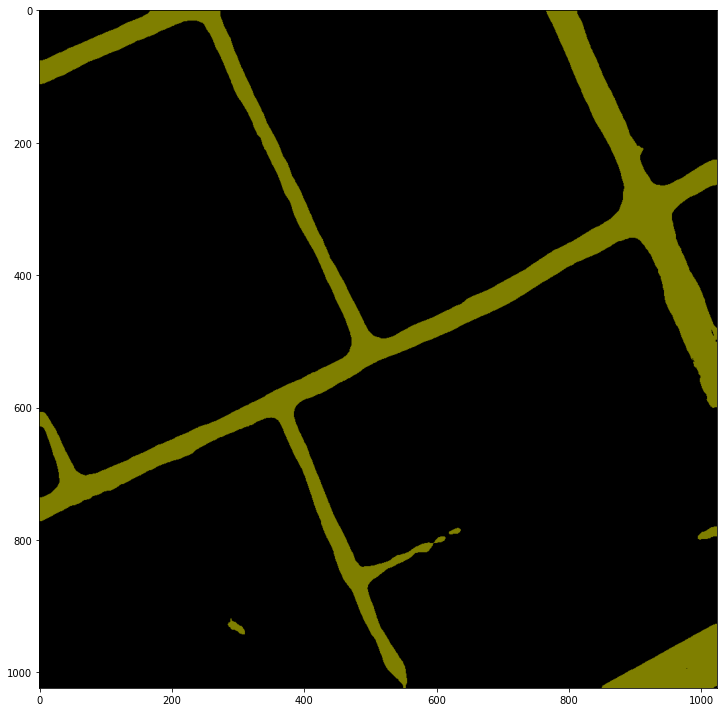

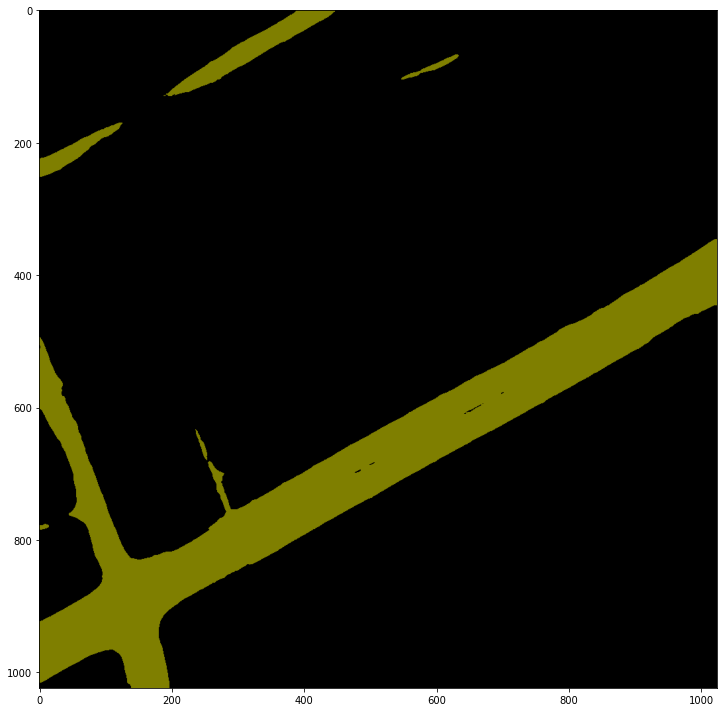

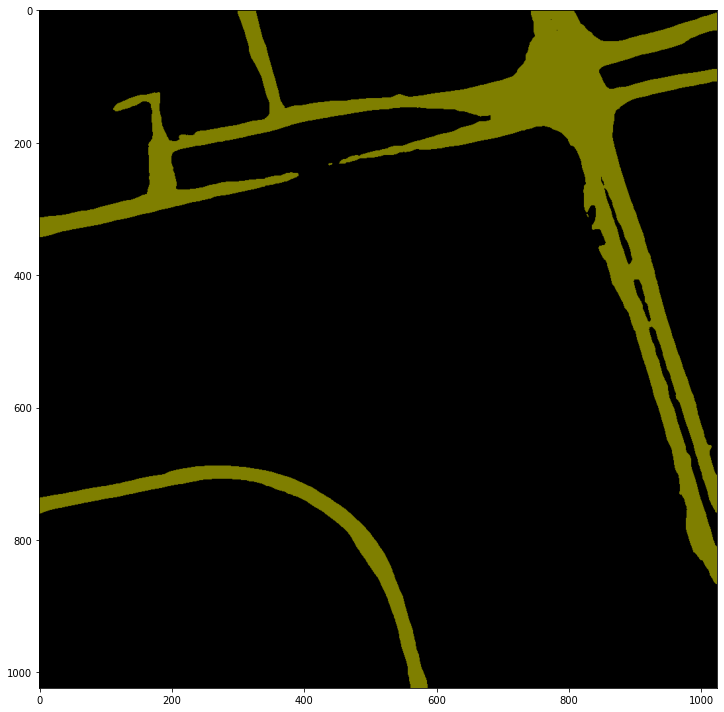

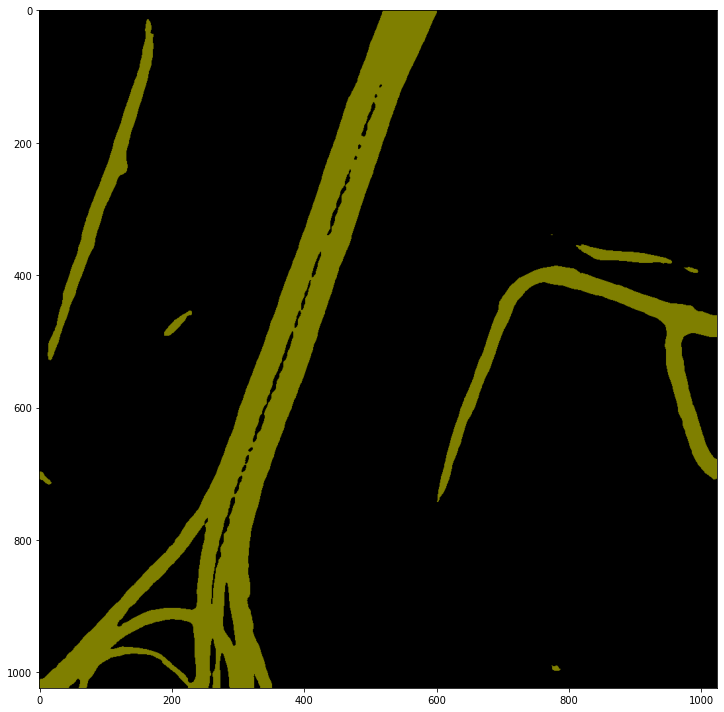

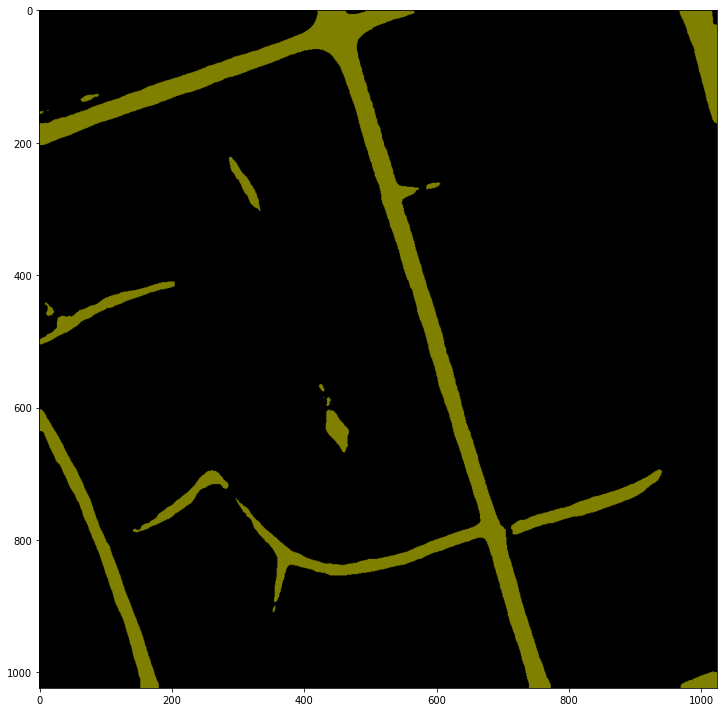

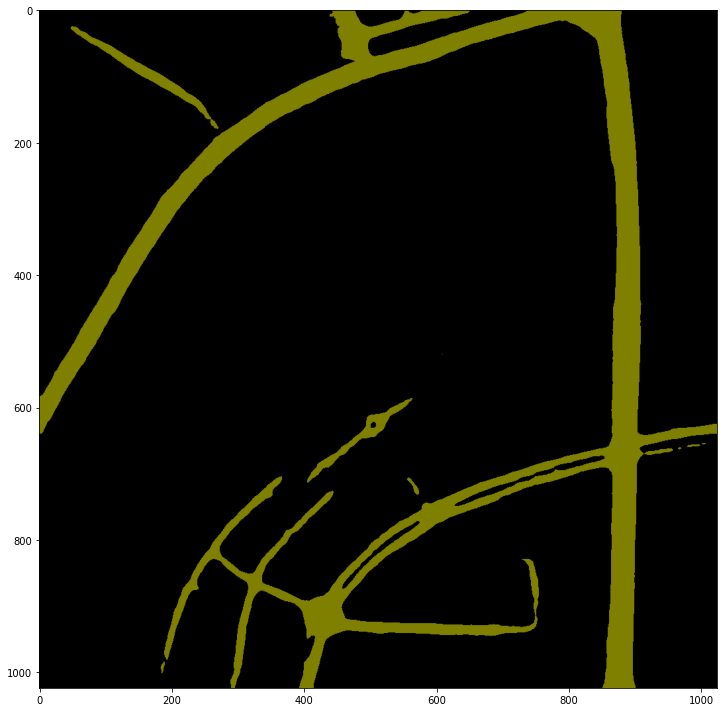

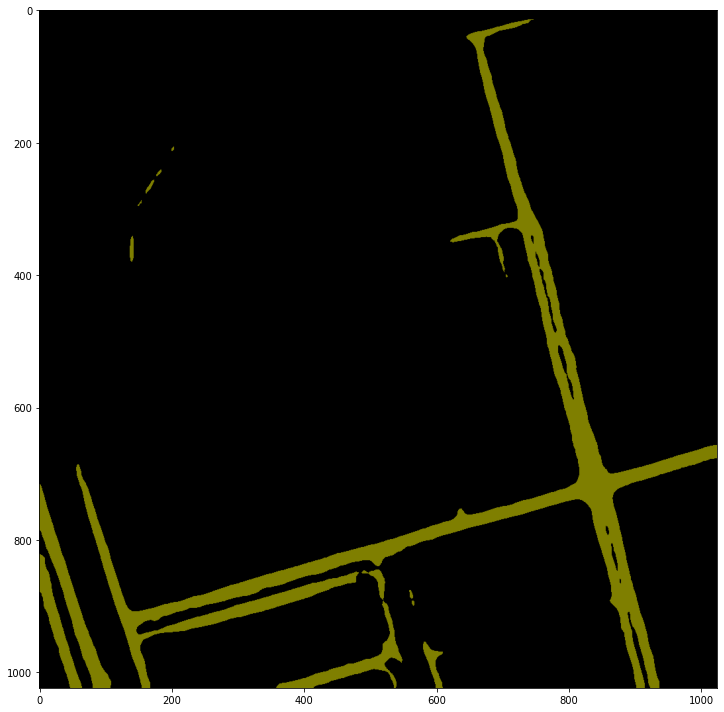

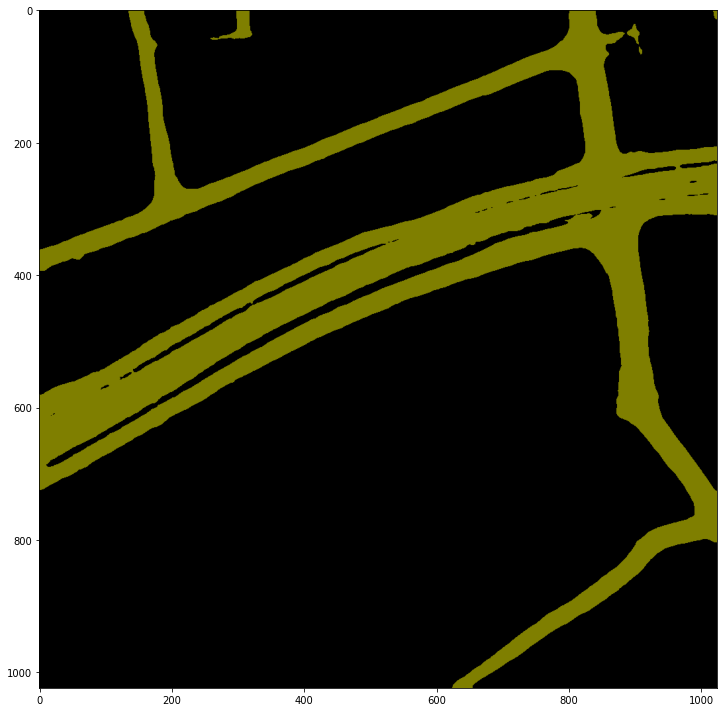

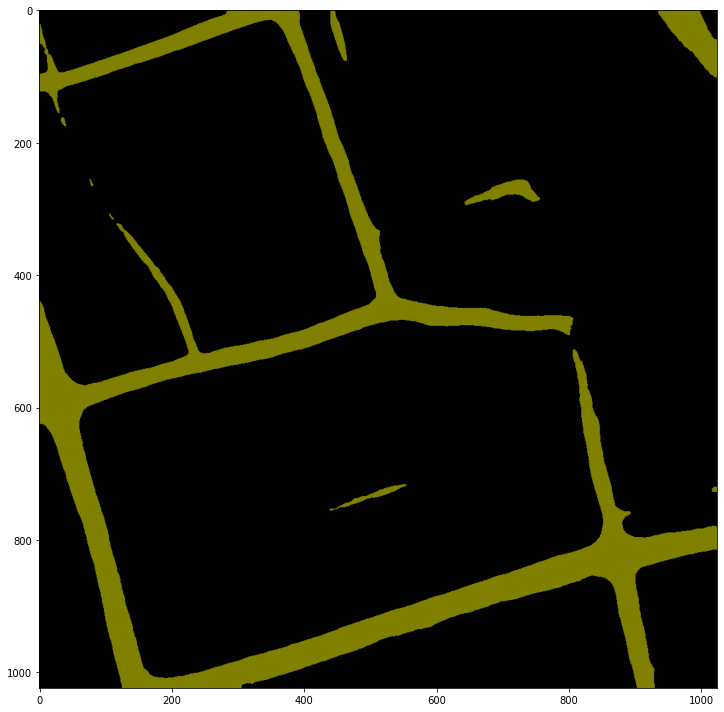

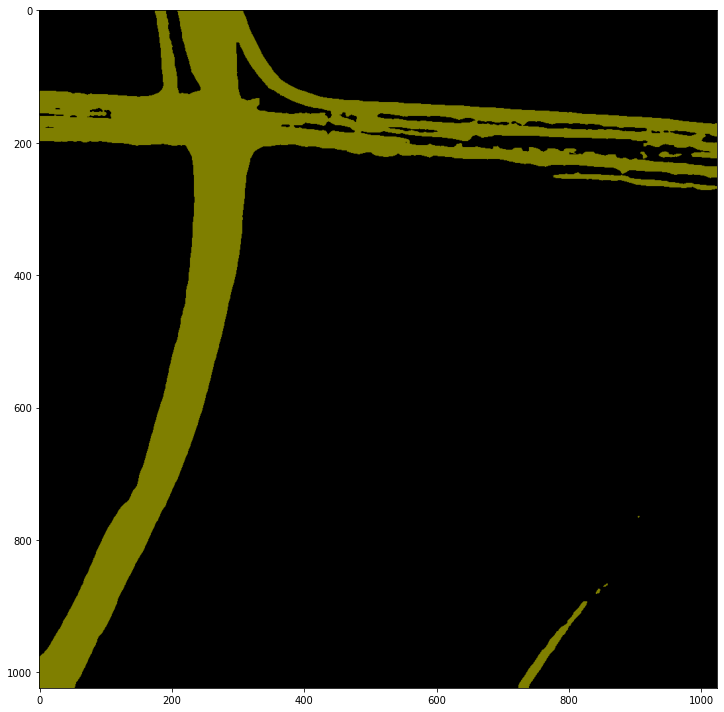

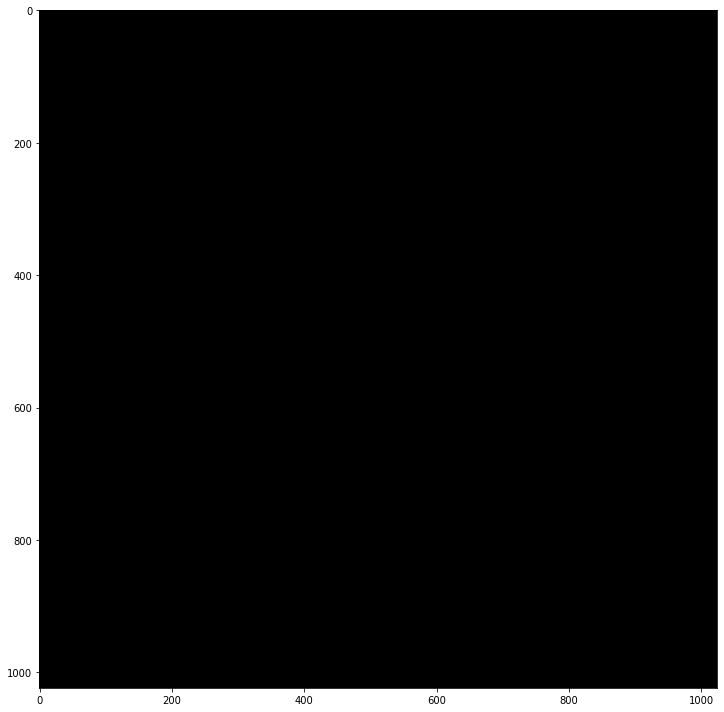

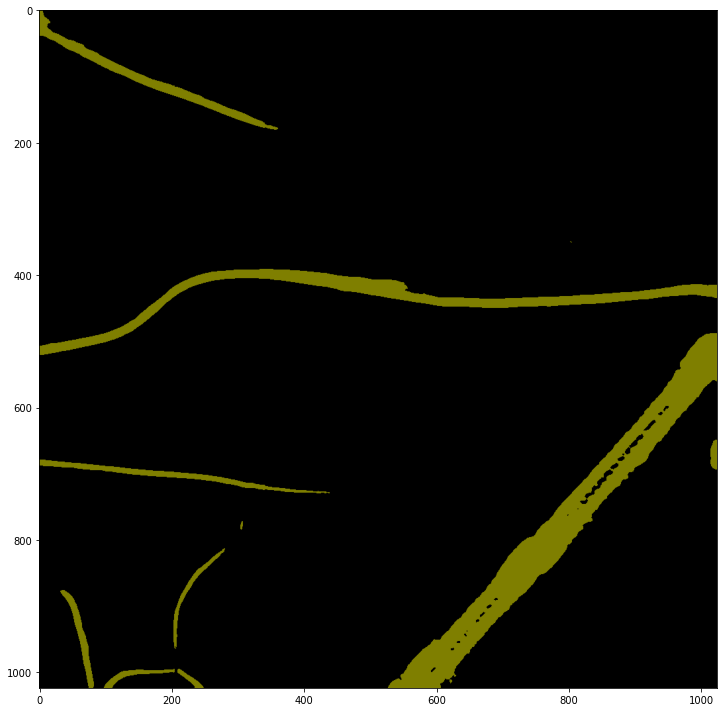

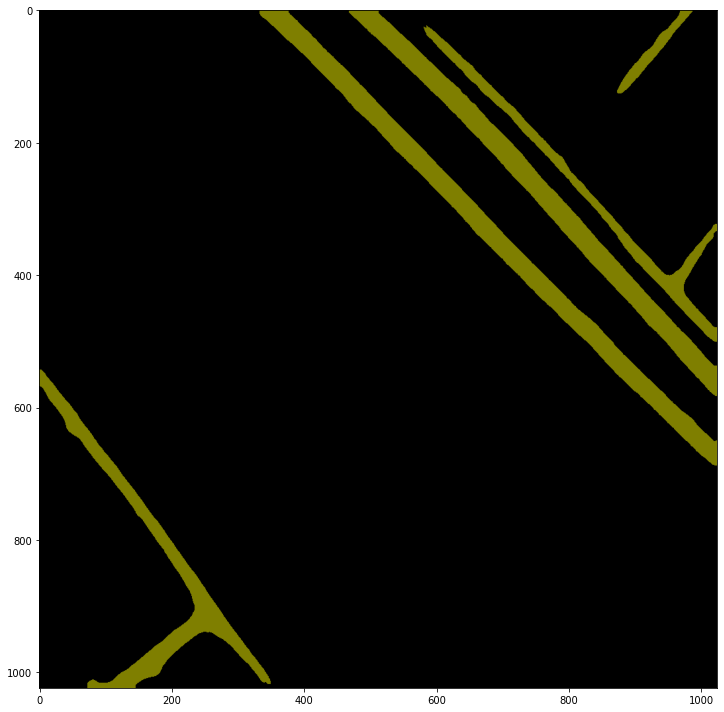

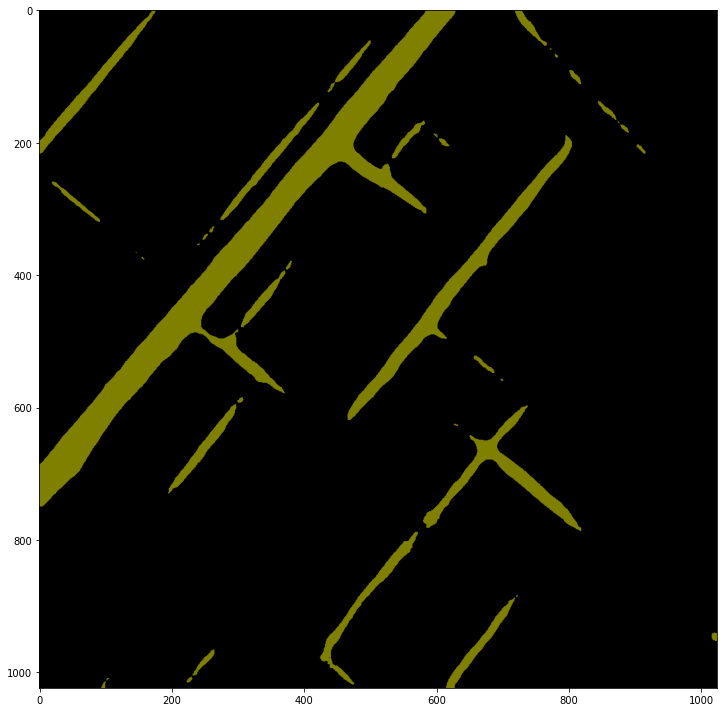

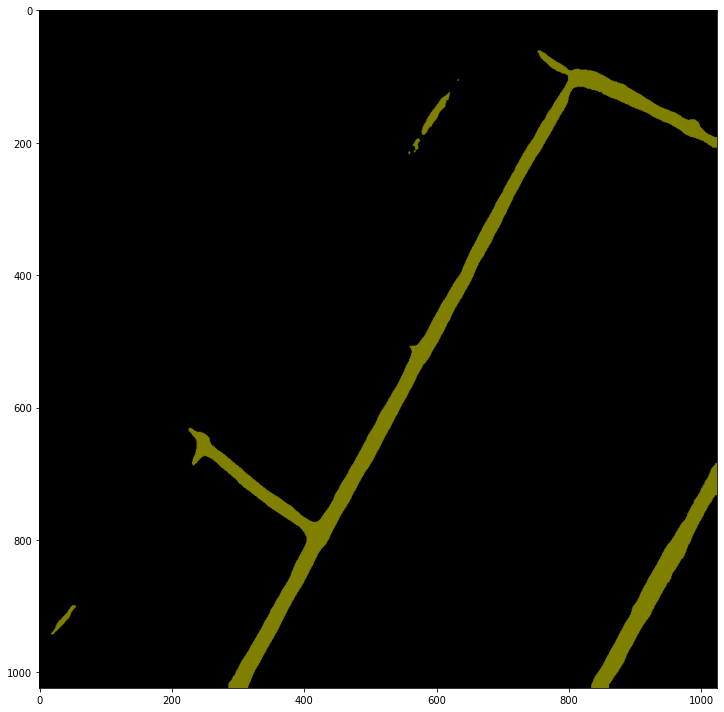

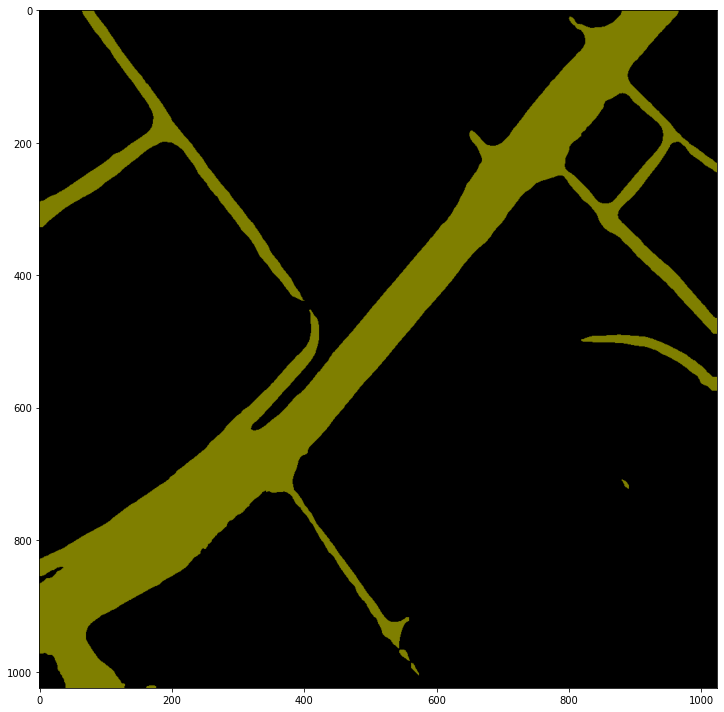

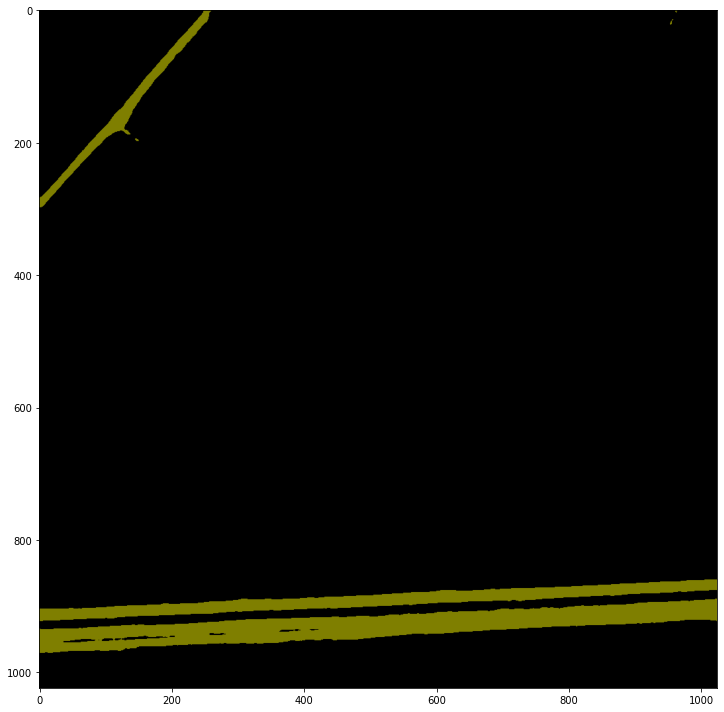

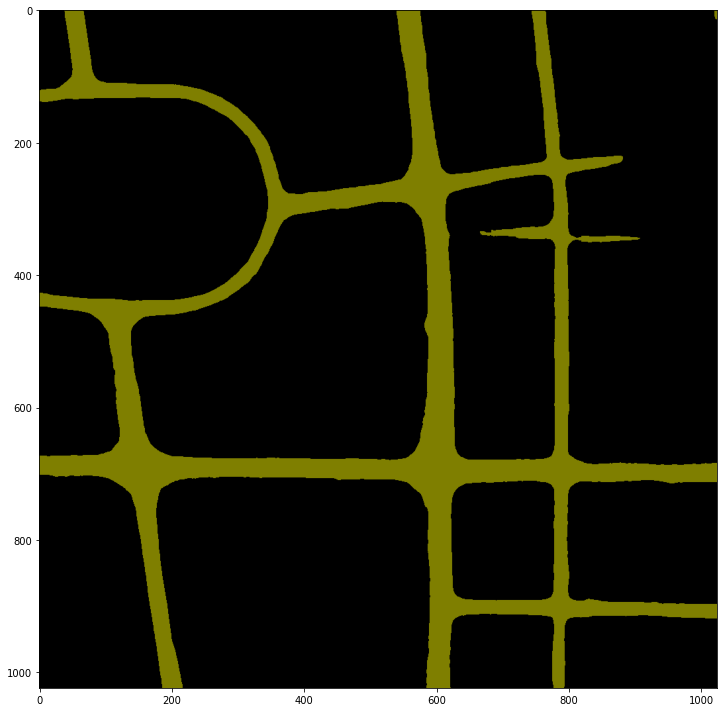

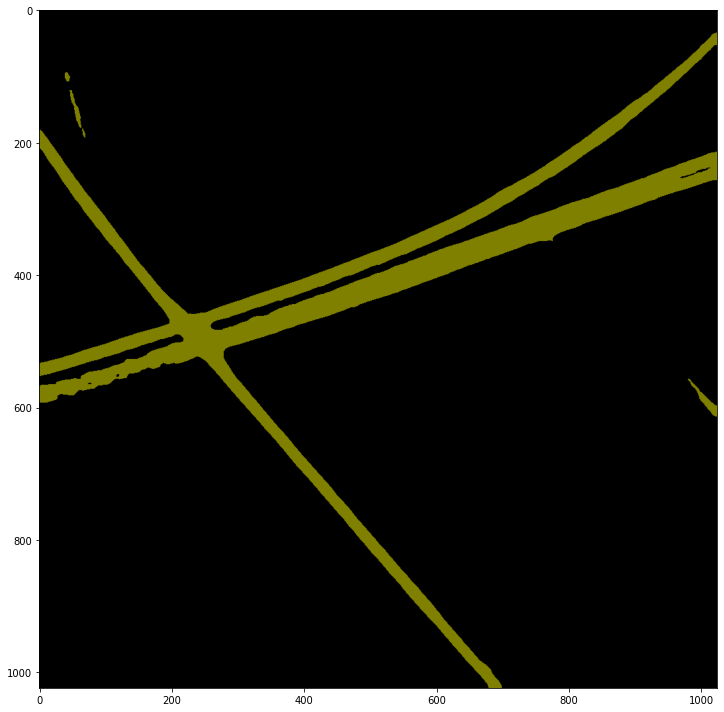

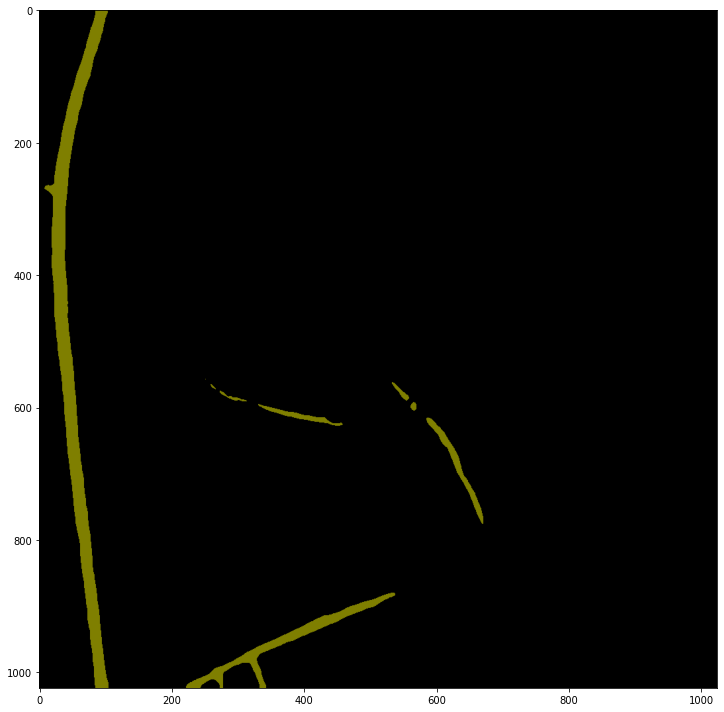

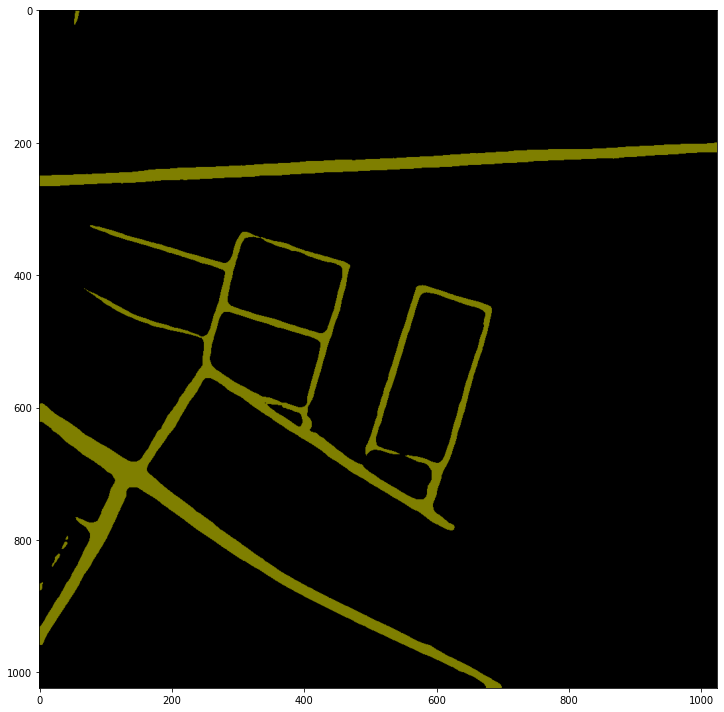

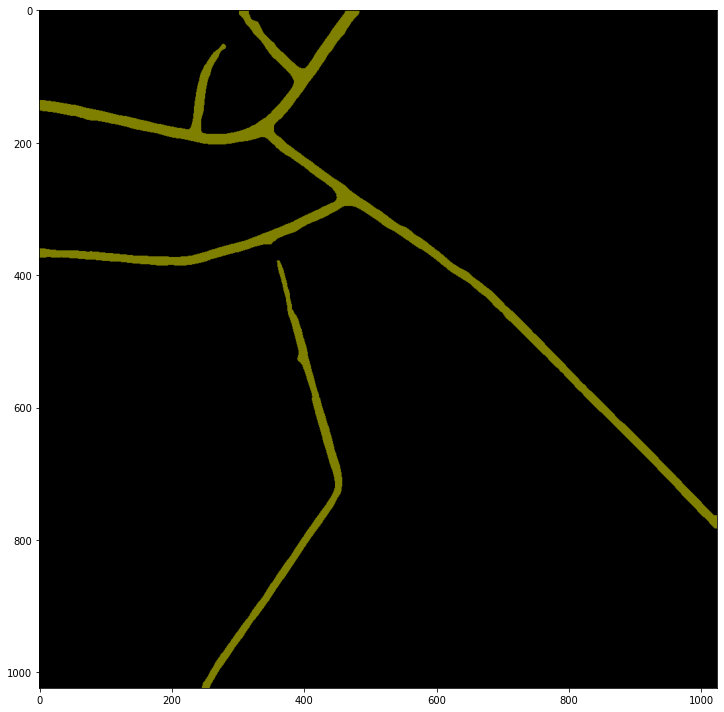

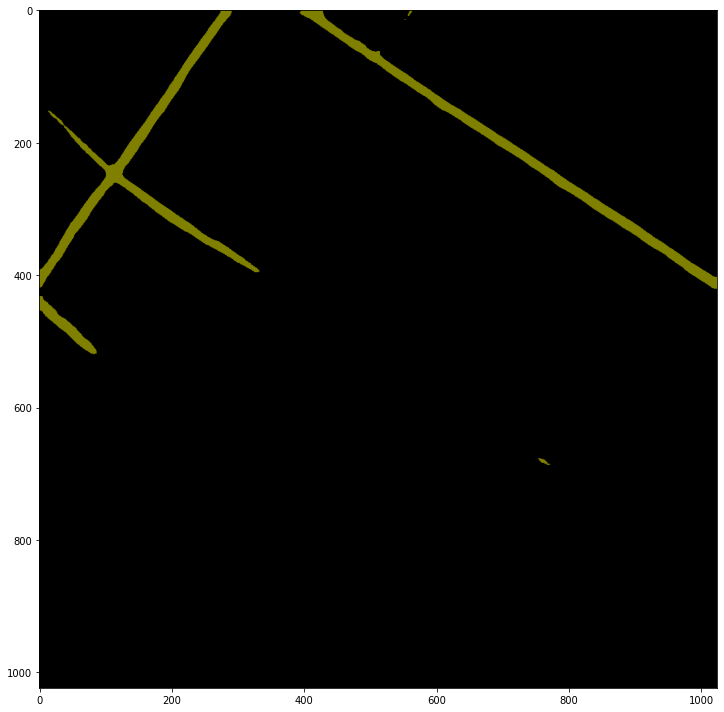

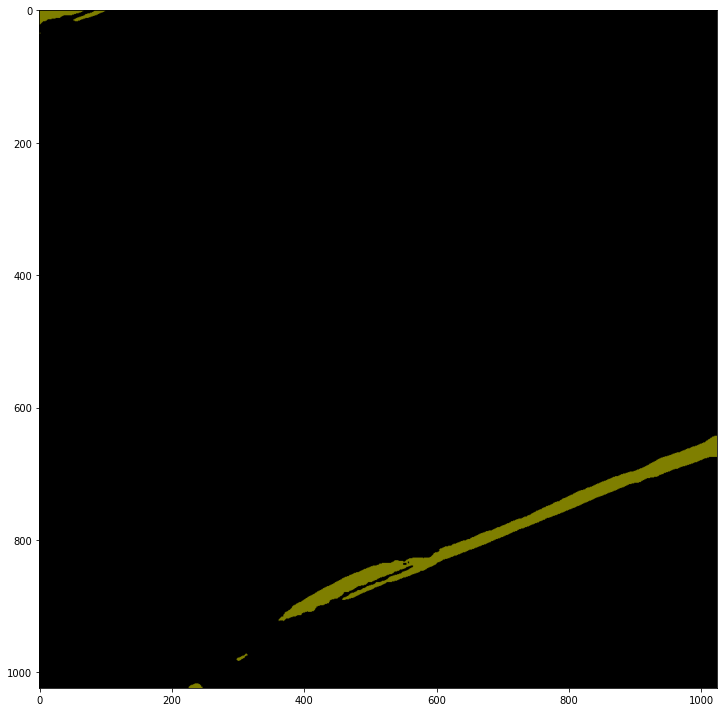

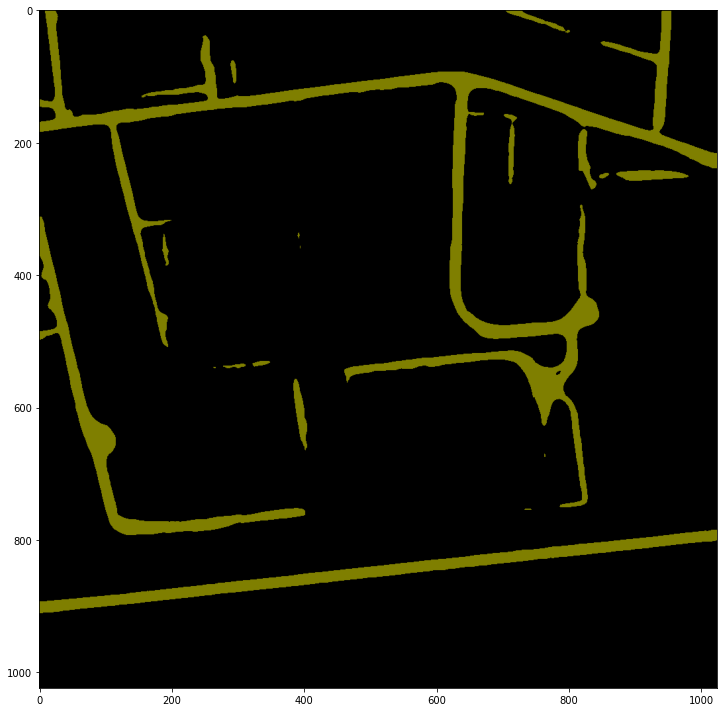

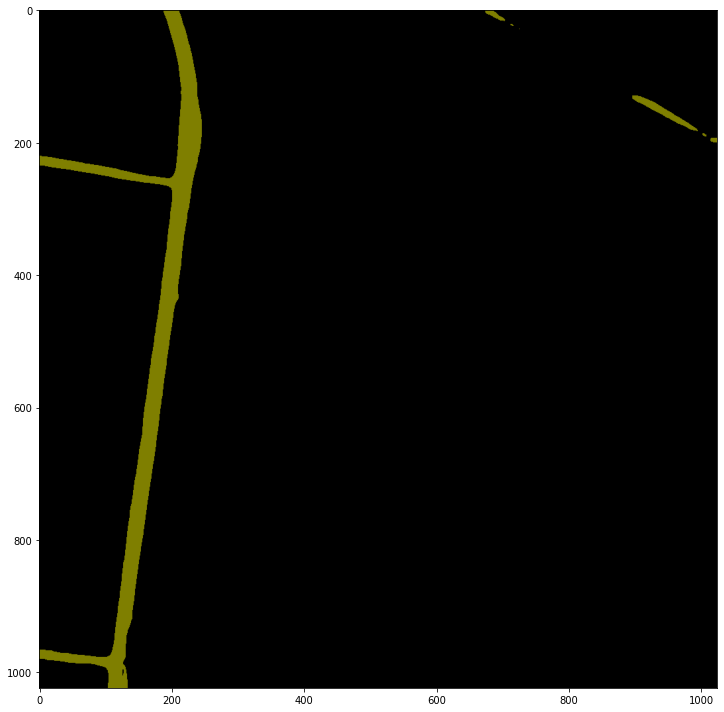

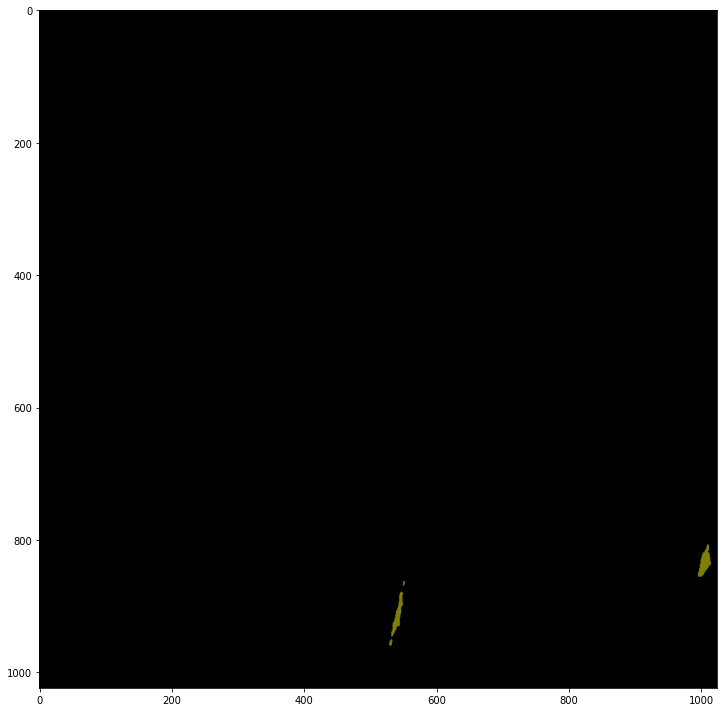

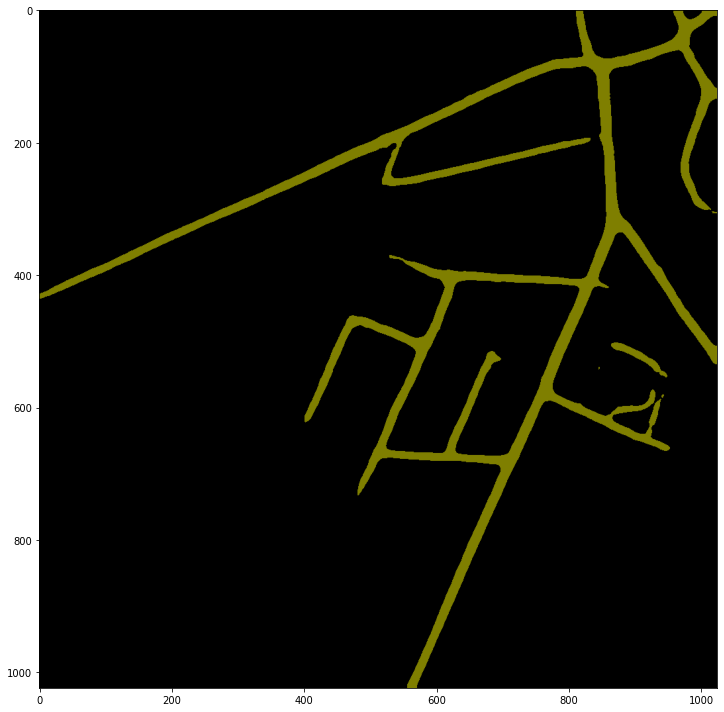

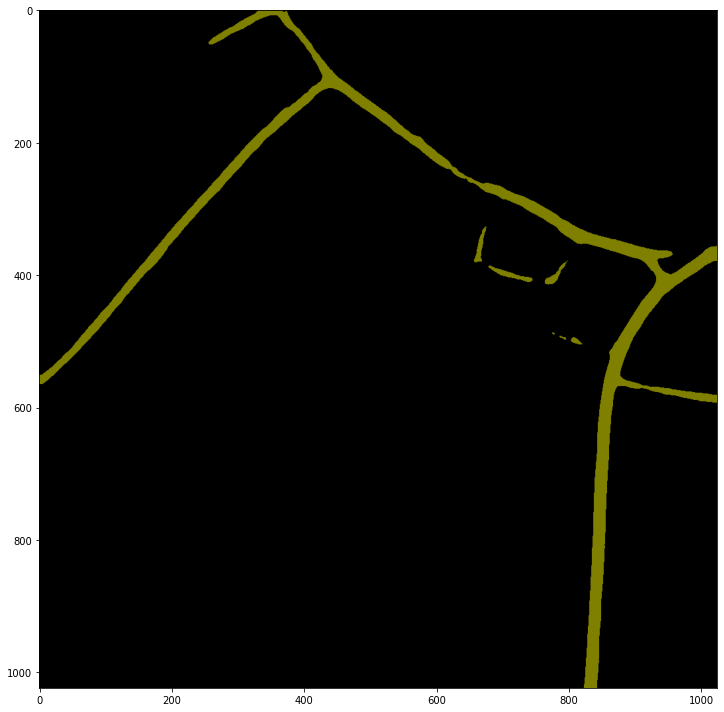

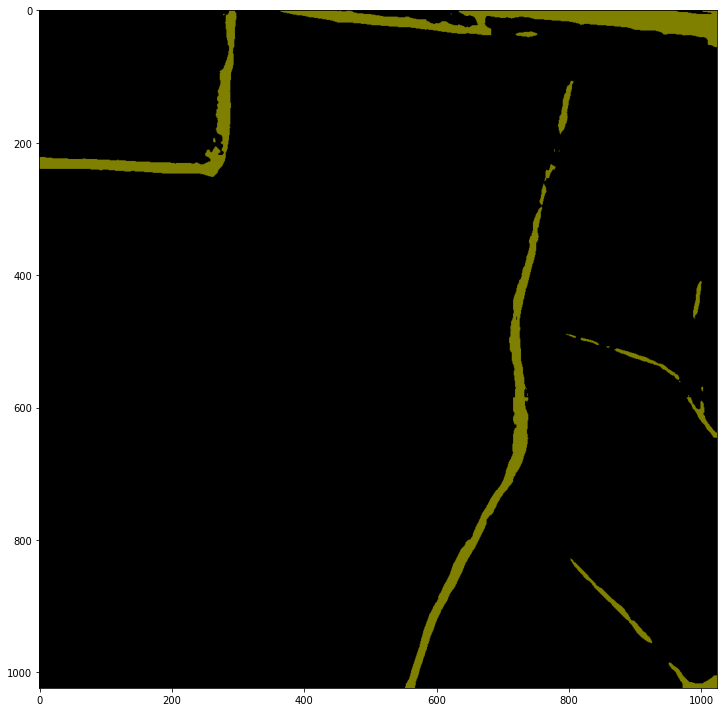

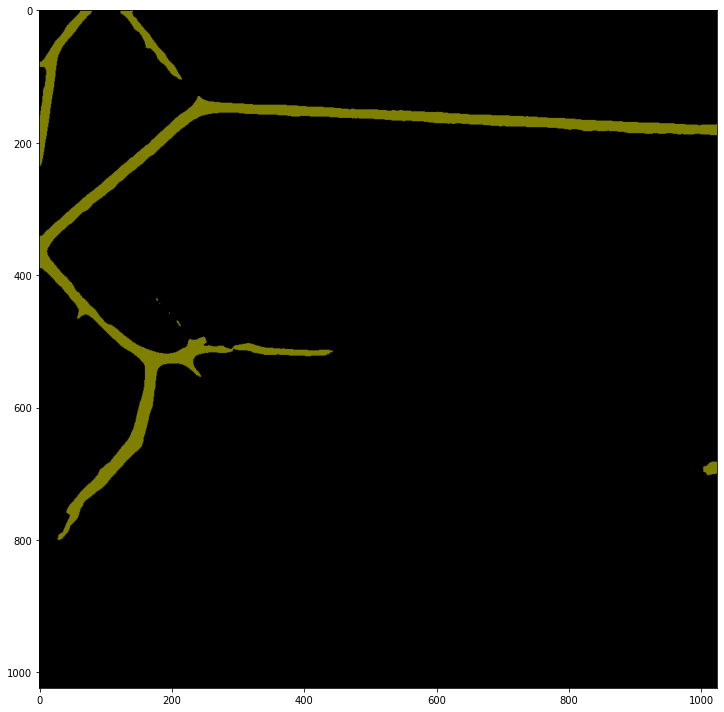

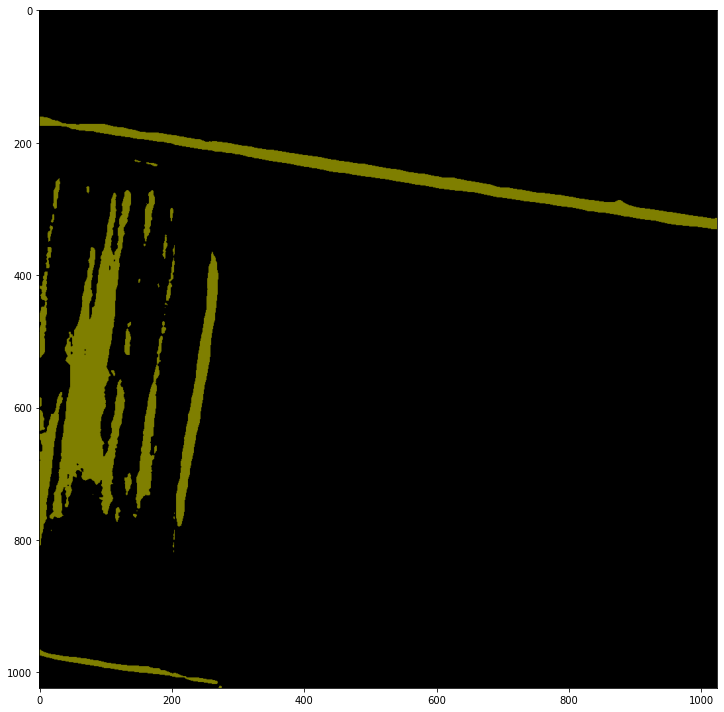

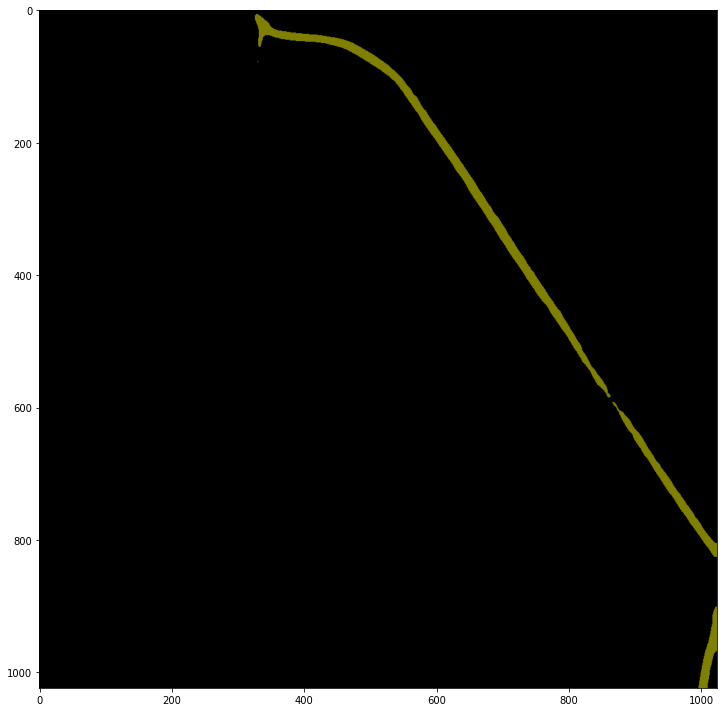

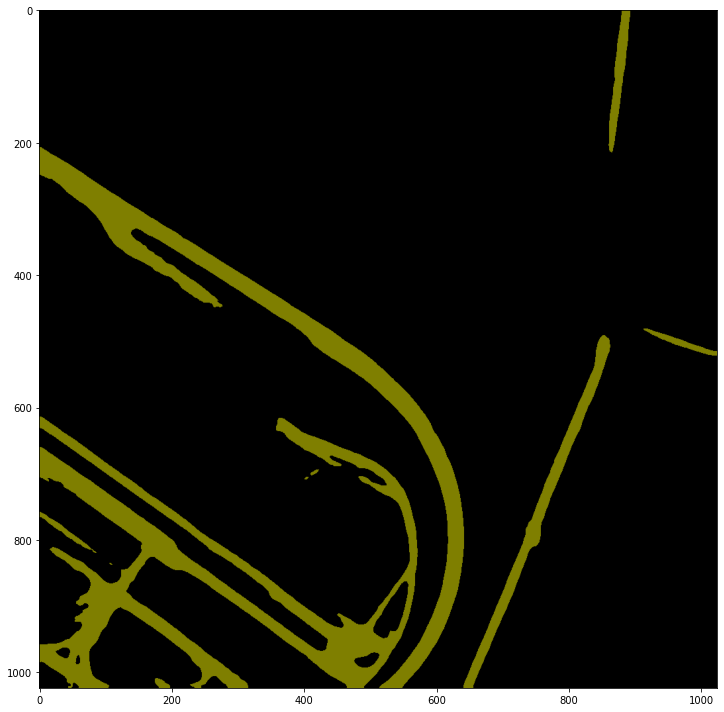

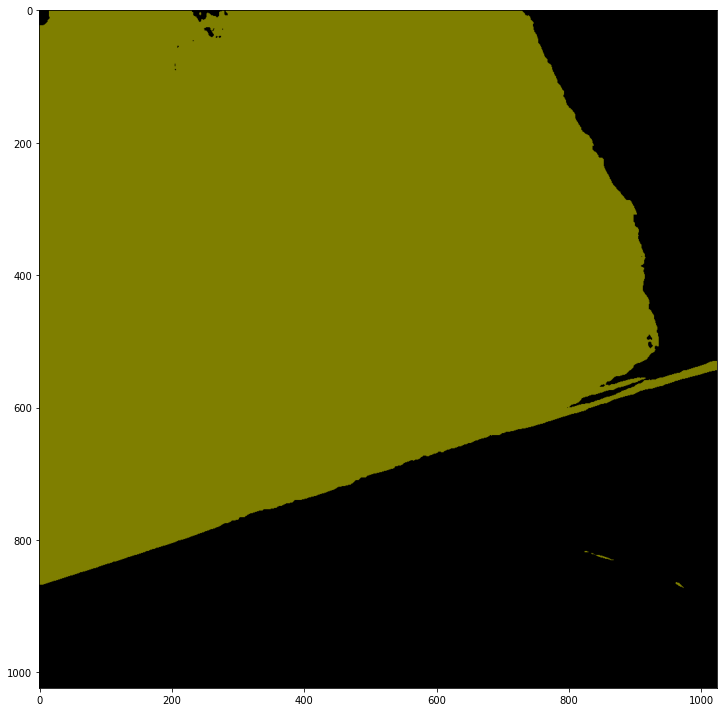

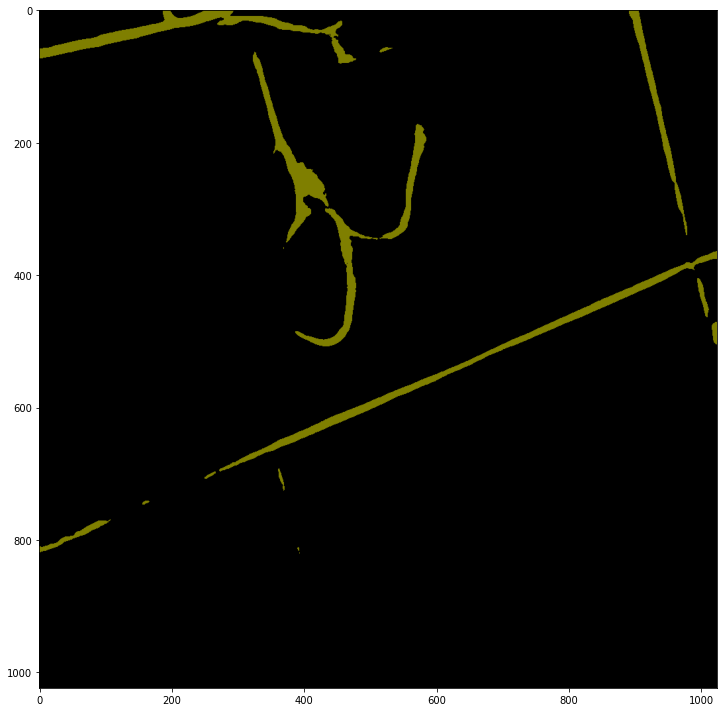

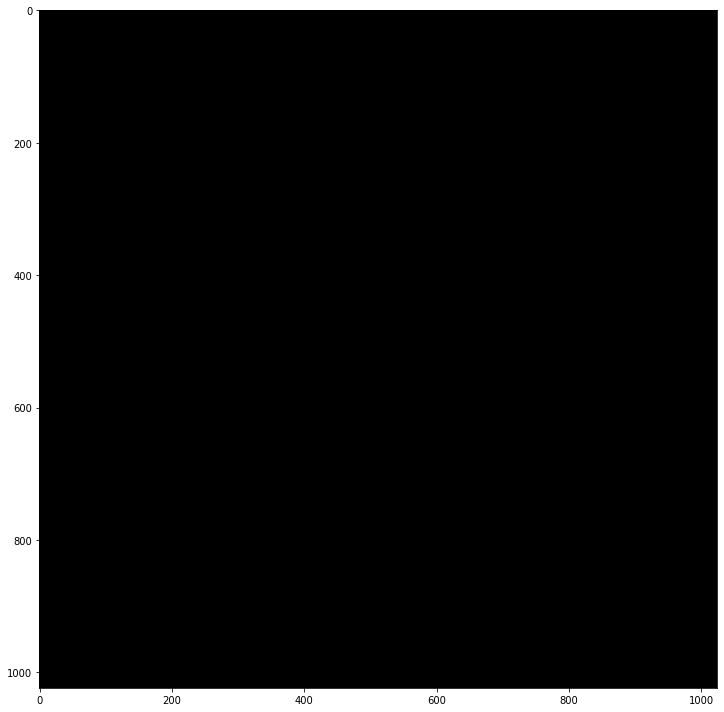

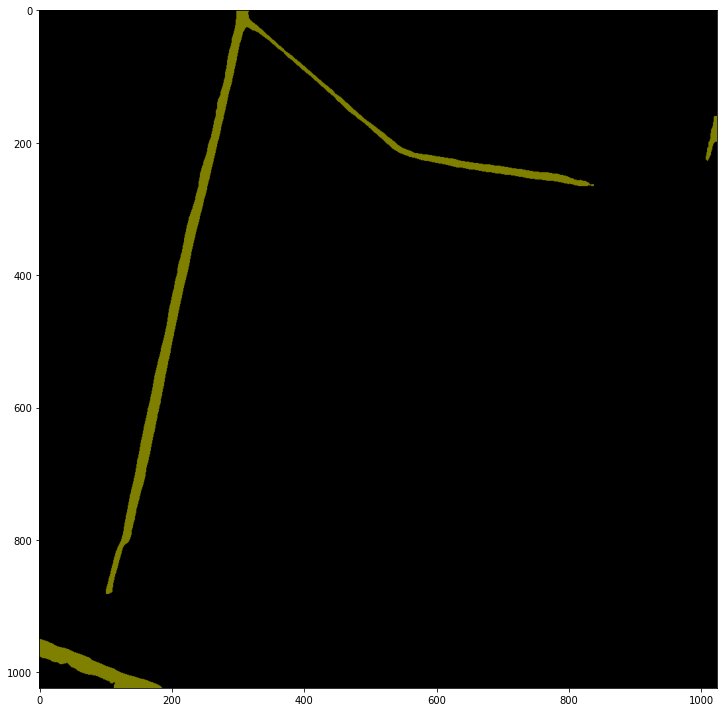

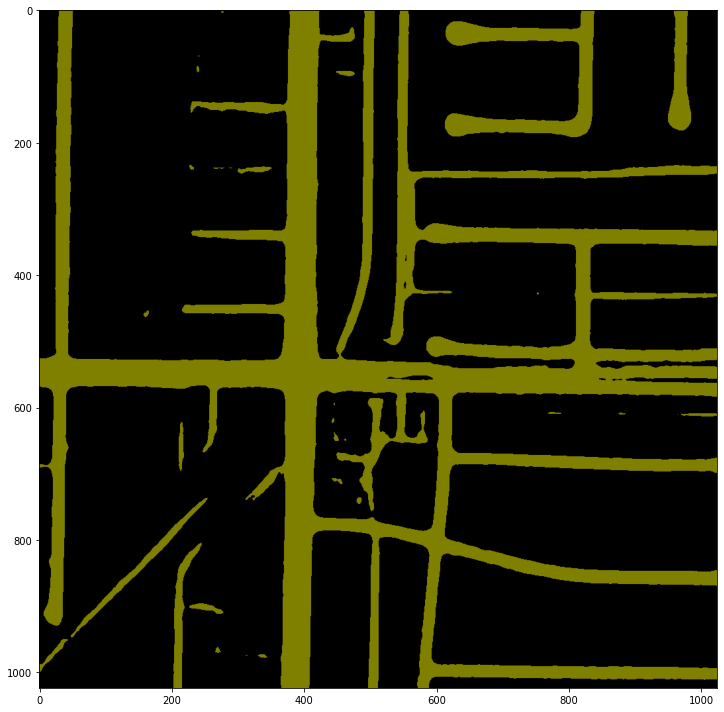

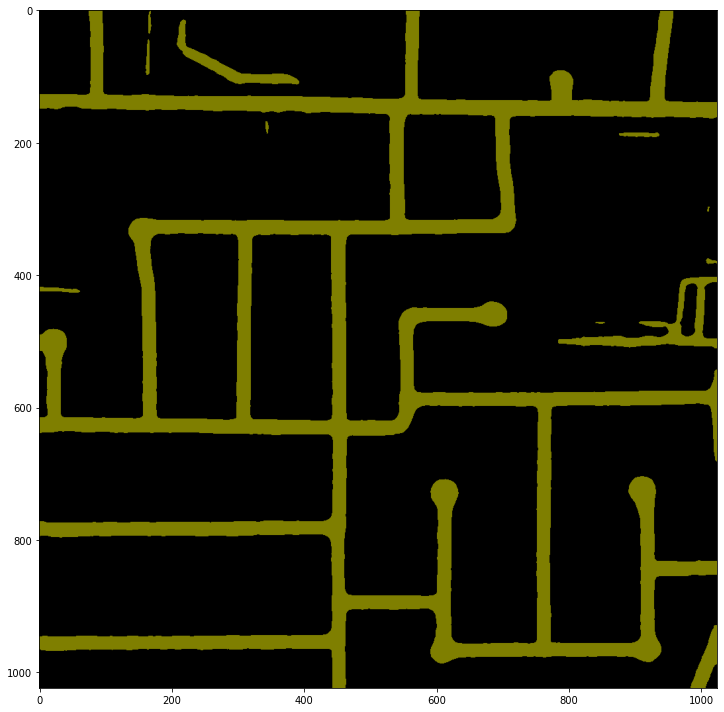

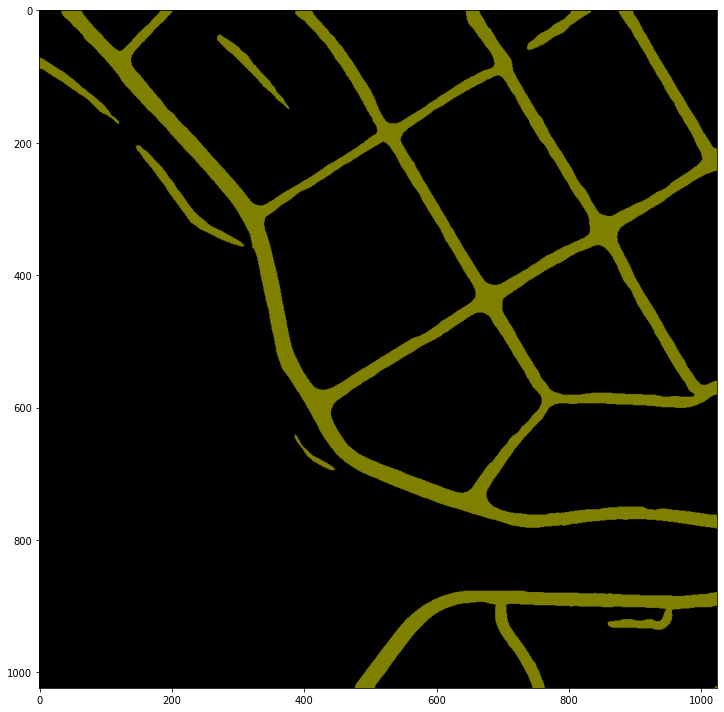

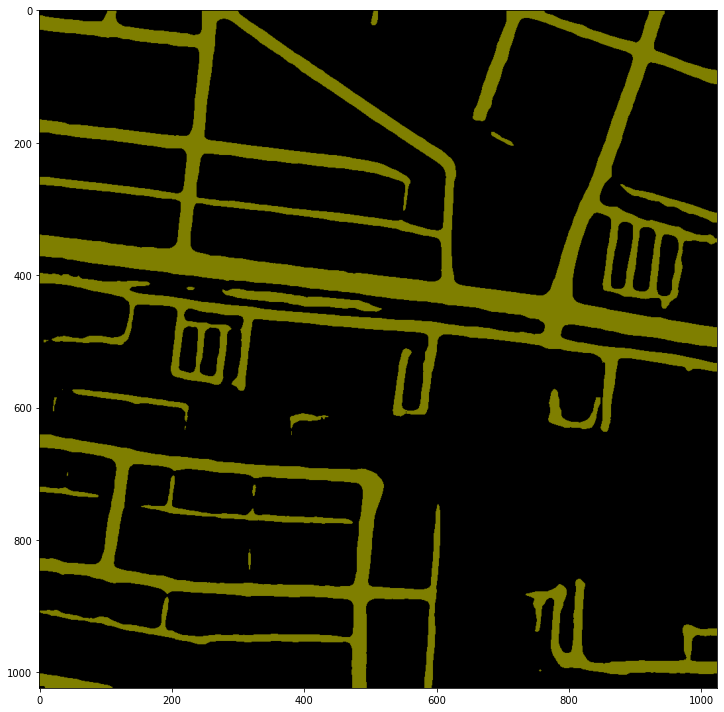

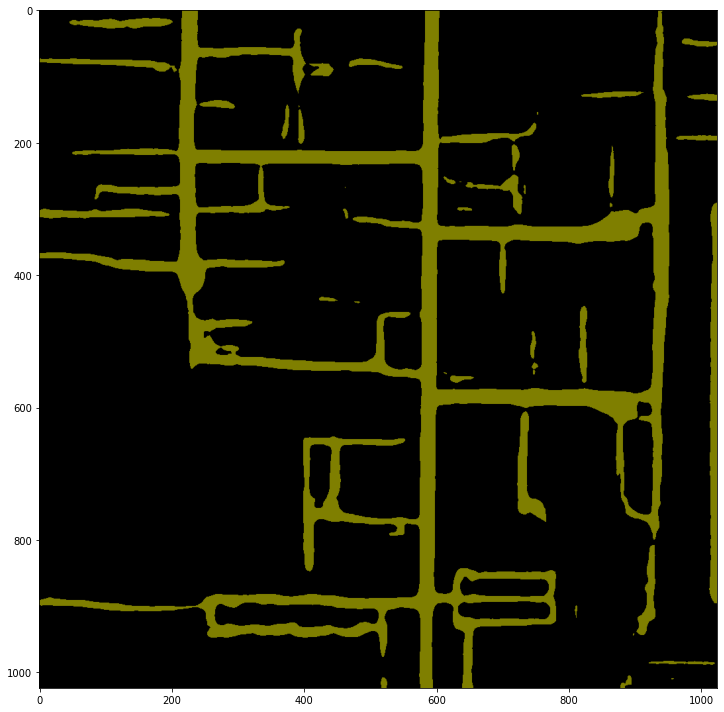

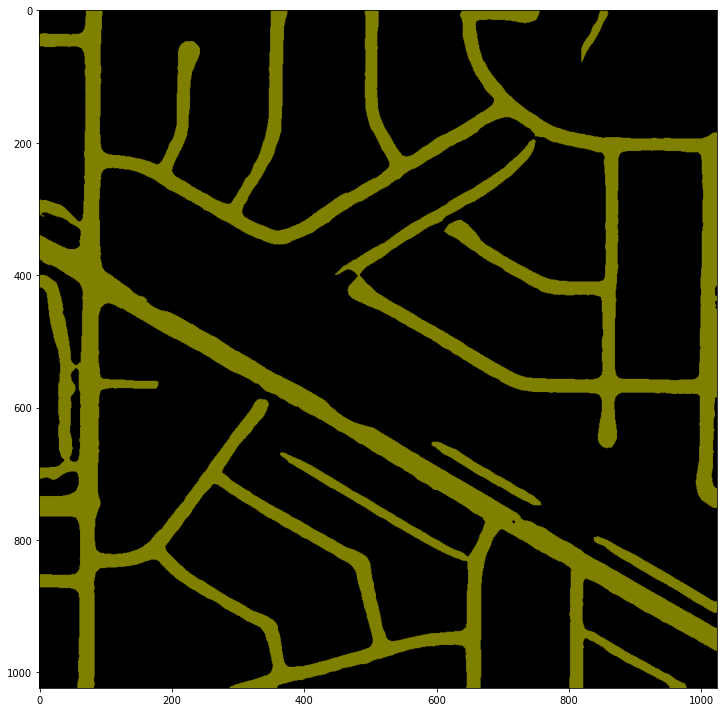

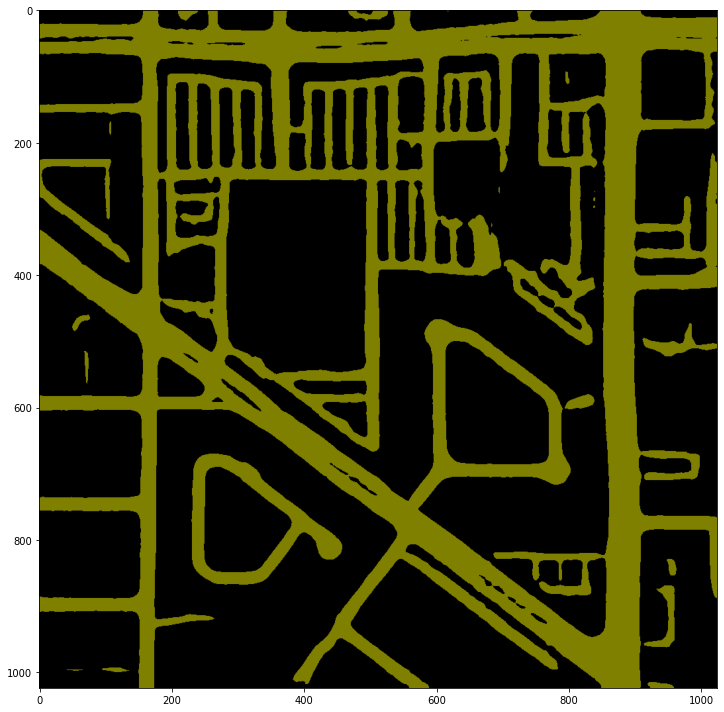

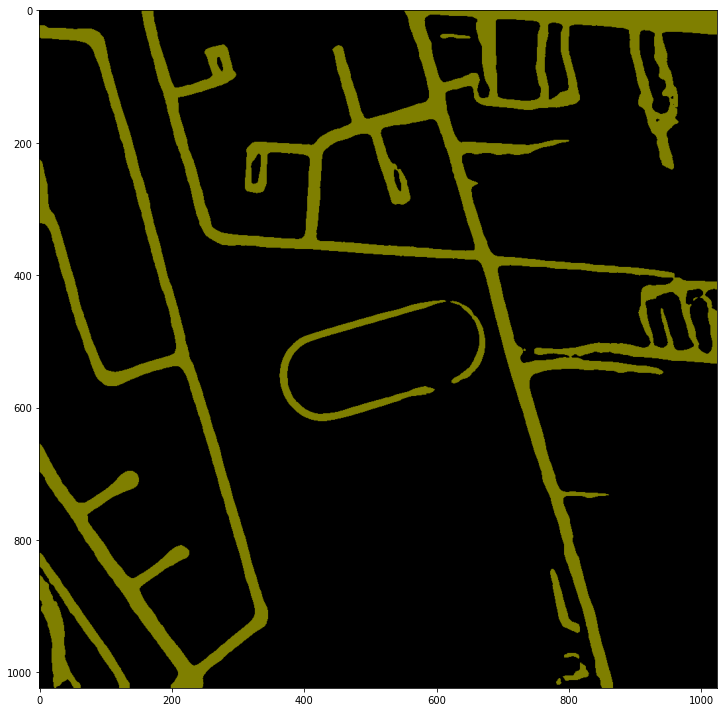

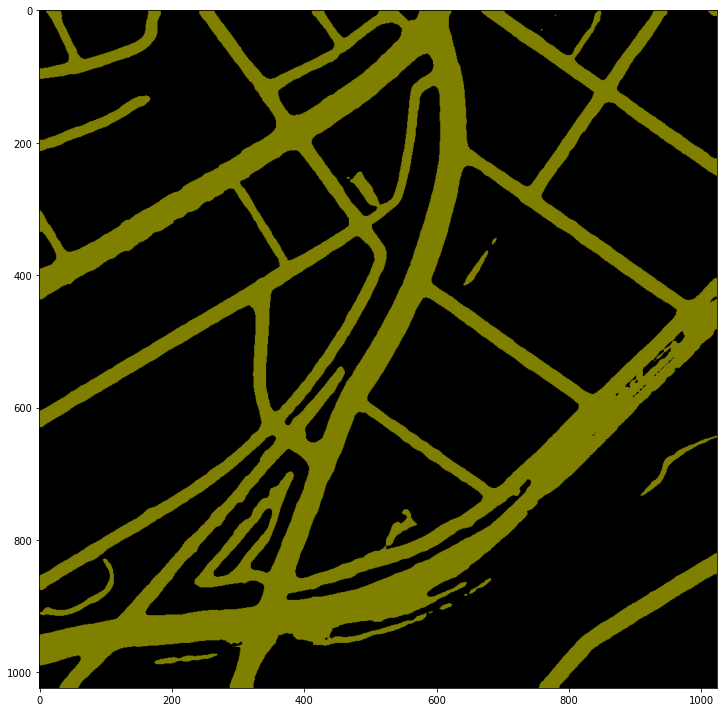

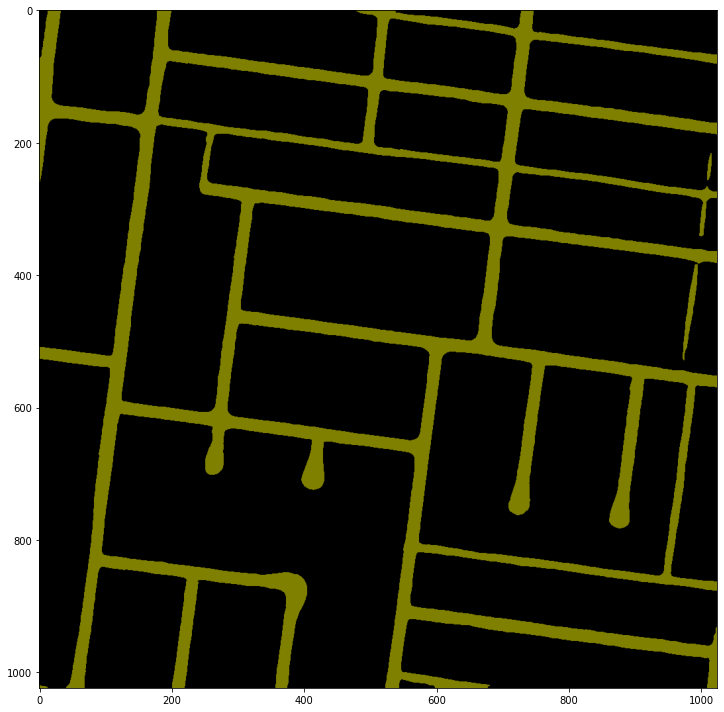

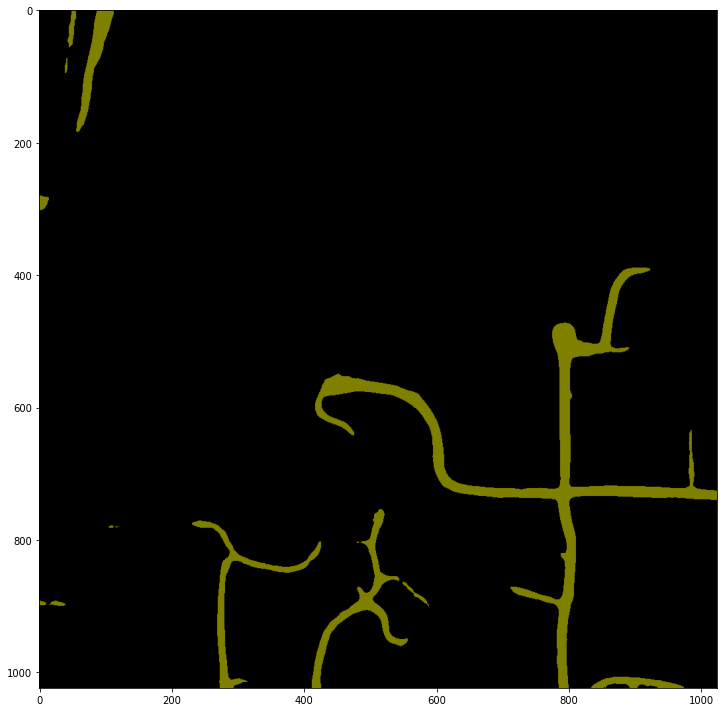

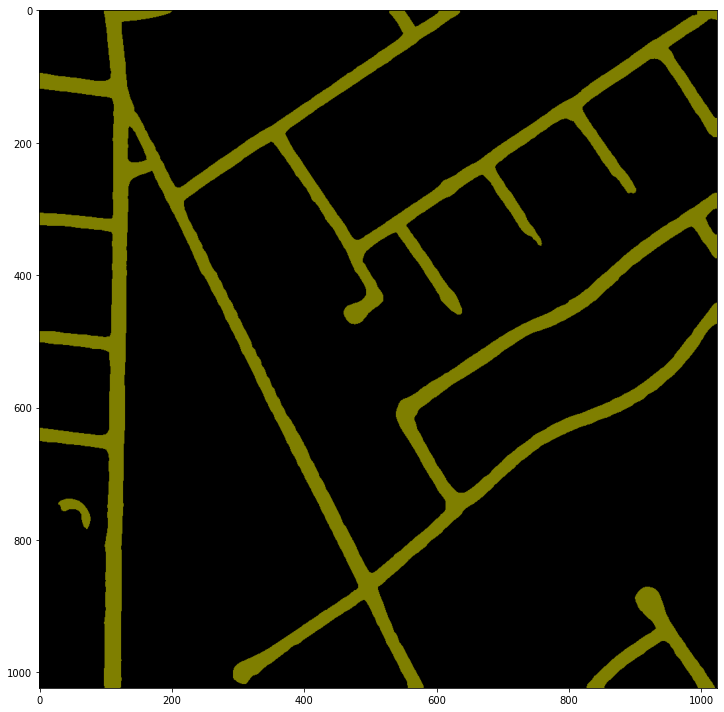

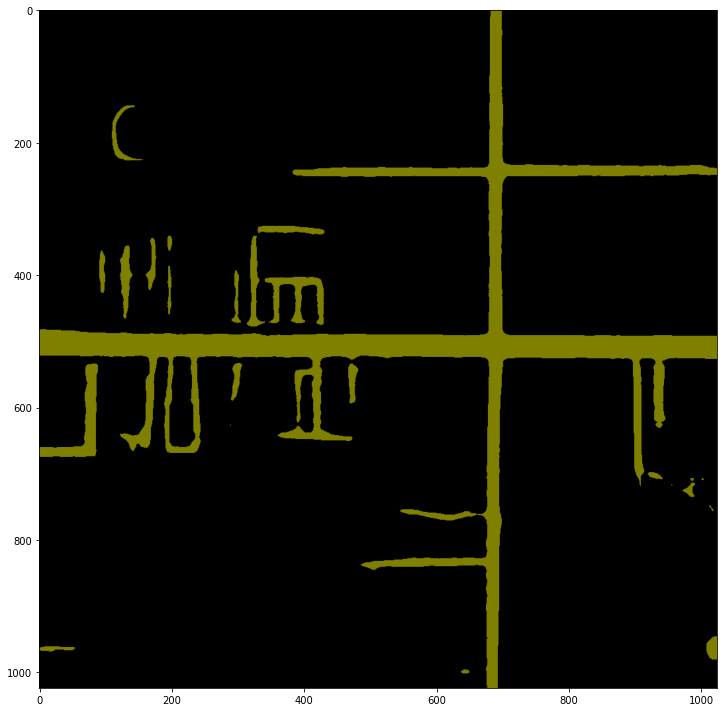

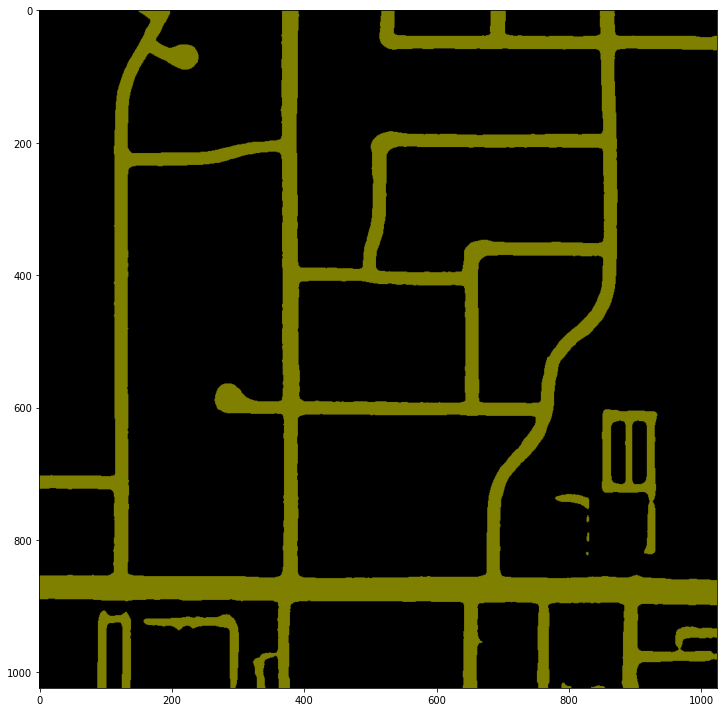

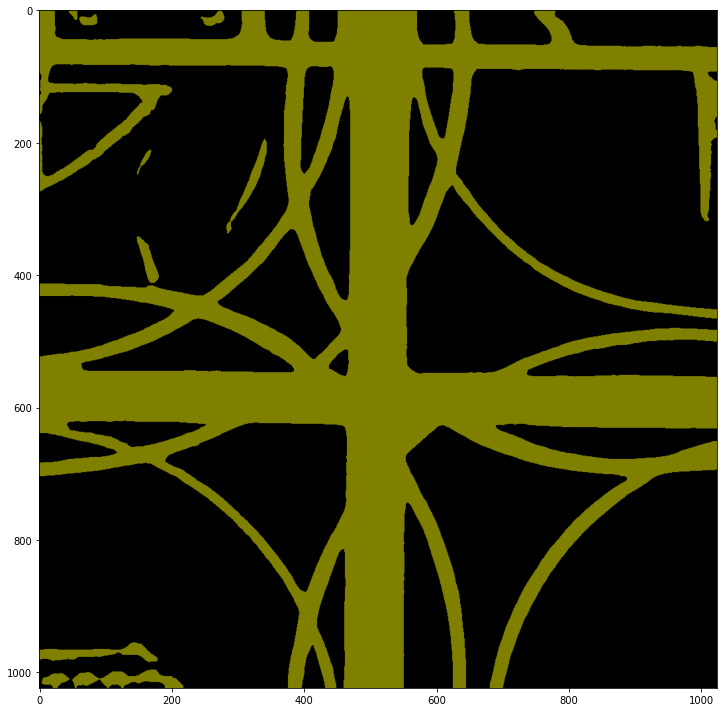

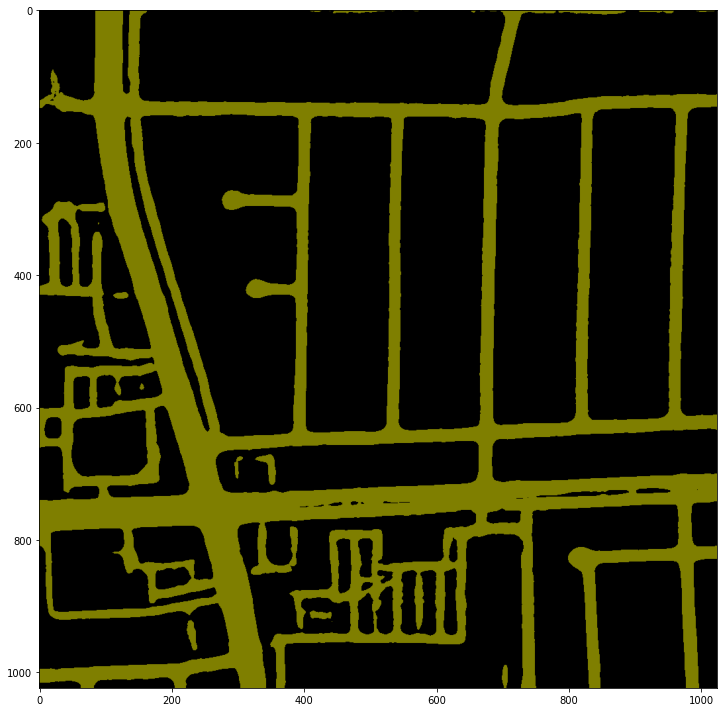

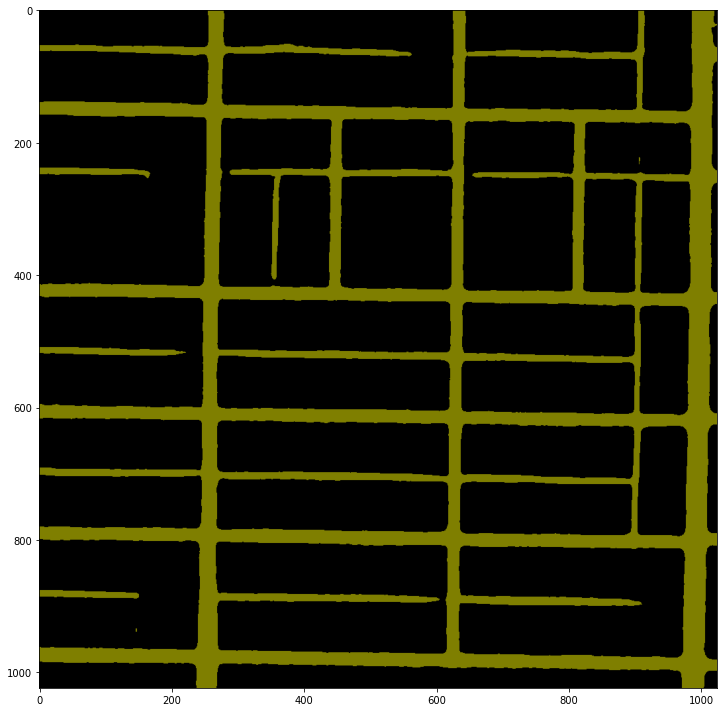

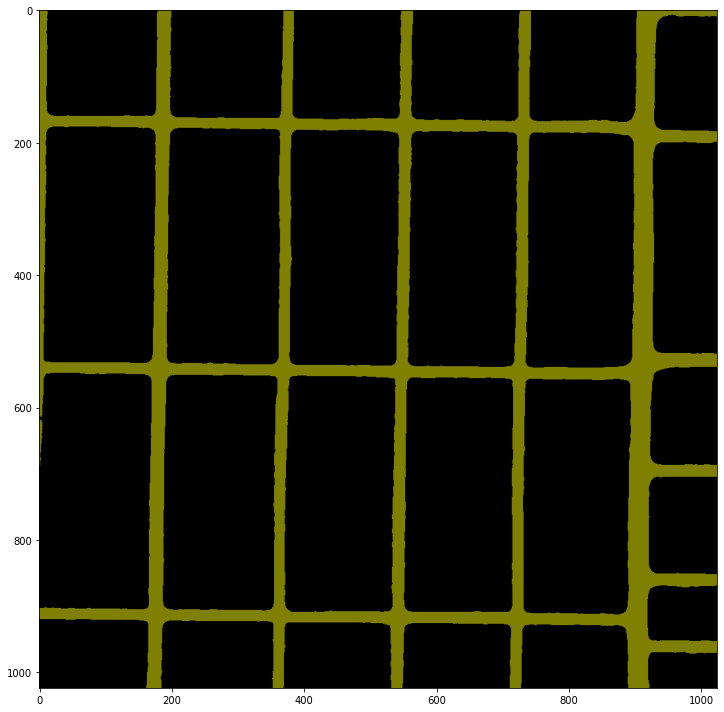

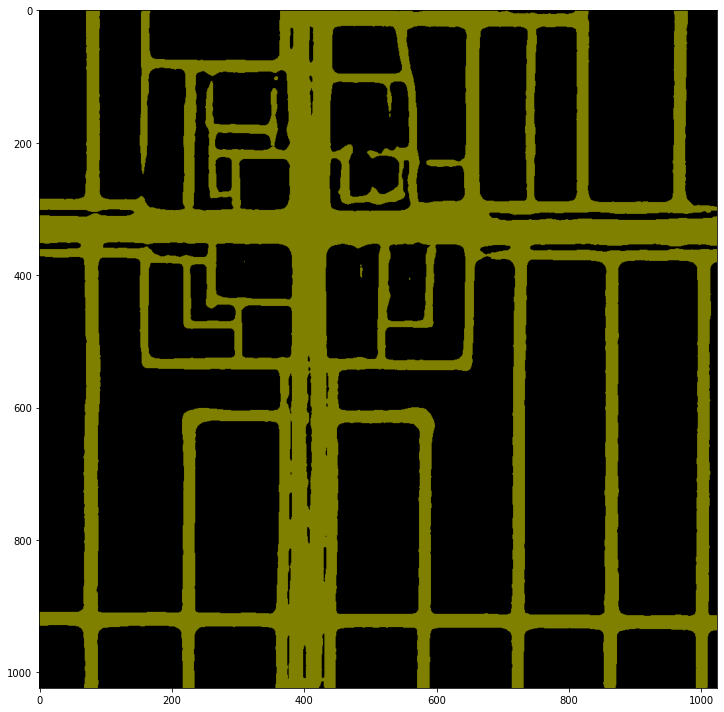

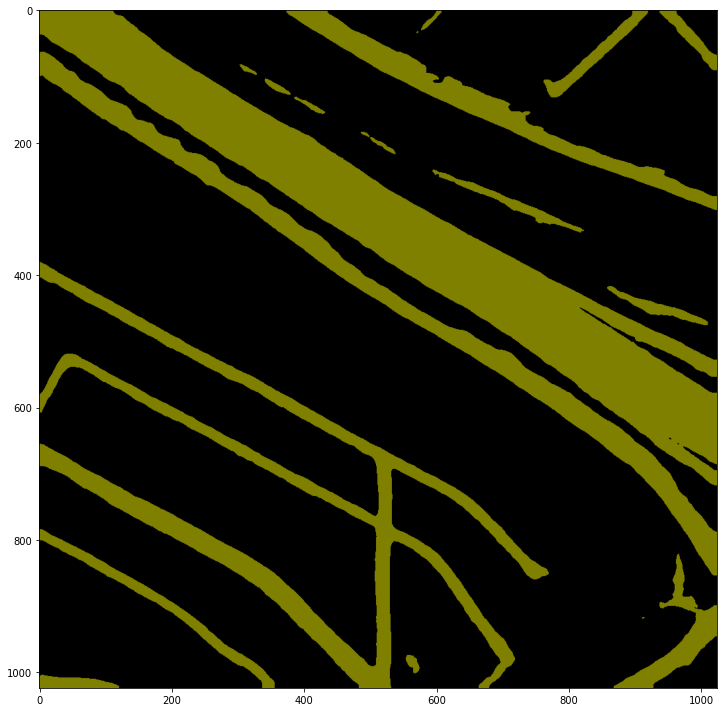

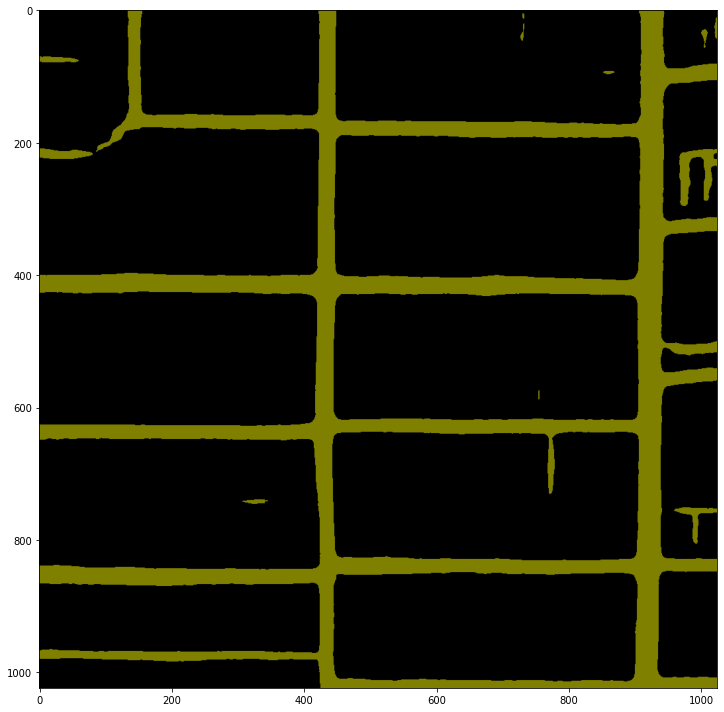

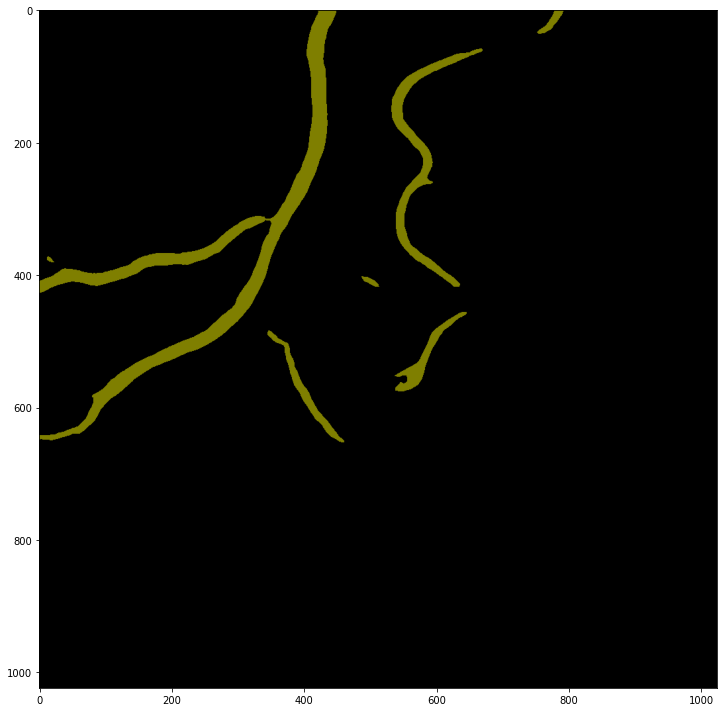

In [20]:
import os
file_list = os.listdir('/content/drive/MyDrive/SIA/Data_set/road_dataset/img_dir/val')
test_png = []
for i in file_list:
  if '.png' in i:
    test_png.append(i)

checkpoint_file = '/content/drive/MyDrive/SIA/semantic_checkpoint/Segformer/road/DL_cutout_sampler/iter_20000.pth'  #학습된 모델  #change point
model_ckpt = init_segmentor(cfg, checkpoint_file, device='cuda:0')  #cuda gpu 사용
img2 = np.zeros((1024,1024,3),np.uint8)

for j in test_png:
  img = mmcv.imread('/content/drive/MyDrive/SIA/Data_set/road_dataset/img_dir/val/'+j)
  result = inference_segmentor(model_ckpt, img)
  show_result_pyplot(model_ckpt, img2, result, palette)
  model_ckpt.show_result(img2, result, out_file= '/content/drive/MyDrive/SIA/Morphological/DL/cutout_sampler/Dataset/'+j) #change point